In [1]:
from analysis.datasets import load_entsoe
from analysis.transformations import minute_to_daily
from analysis.splits import to_train_validation_test_data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from ngboost import NGBRegressor
from sklearn.metrics import mean_squared_error
from ngboost.scores import LogScore, CRPScore
from ngboost.distns import Normal
from ngboost.distns import LogNormal
from ngboost.distns.normal import NormalCRPScore

In [2]:
def get_columns_by_time(df, time: str):
    time = time.replace(':', '_')
    #columns = [c.removesuffix(f"_{time}") for c in df.columns if c.endswith(time)]
    columns = [c for c in df.columns if c.endswith(time)]

    selection = df.loc[:, columns]
    selection.columns = [c.removesuffix(f"_{time}") for c in selection.columns]
    return selection

def delay(df, delays: int | list[int], columns: None | str | list[str] = None):

    if columns is None:
        columns = df.columns
    elif isinstance(columns, str):
        columns = [columns]
        
    if isinstance(df, pd.Series):
        df = df.to_frame()

    dfs = [df]

    if isinstance(delays, int):
        delays = range(1, delays + 1)
    for t in delays:
        delayed_df = df.loc[:, columns].shift(t)
        delayed_df.columns = [f"{c}_t-{t}" for c in delayed_df.columns]
        dfs.append(delayed_df)
    vstacked_df = pd.concat(reversed(dfs), axis=1).dropna()
    return vstacked_df


import numpy as np

def prepare_and_select_features(time_interval, columns_to_include):

    df = load_entsoe()  # Load the dataframe containing aggregated power and wind speed at 10 locations and at geographic mean

    # Rename and drop "offshore" column
    df = df.rename(columns={"onshore": "power"})
    df = df.drop(columns=["offshore"])

    # Resample to daily data (each column represents a 15 minute time interval)
    df_daily = minute_to_daily(df)

    # Select by time interval
    df_daily_time = get_columns_by_time(df_daily, time_interval)

    # Delay the power column for lagged features
    df_daily_time_delay = delay(df_daily_time, delays=1, columns="power")  # delay the "power" column

    selected_columns = []


    if 'only_power' in columns_to_include:
        selected_columns = ['power_t-1']  # Always include power_t-1 as a baseline
    
    # Add additional columns based on the input argument 'columns_to_include'
    if 'all_wind_speeds' in columns_to_include:
        selected_columns = ['power_t-1']  # Always include power_t-1 as a baseline
        selected_columns.extend([col for col in df_daily_time_delay.columns if col.startswith('ws')])
        

    if 'only_sin_cos' in columns_to_include:
        selected_columns = ['power_t-1']  # Always include power_t-1 as a baseline
        # Add sine and cosine transformation for annual periodicity
        selected_columns.extend(['sin_day', 'cos_day'])
        
        df_daily_time_delay['day_of_year'] = df_daily_time_delay.index.dayofyear
        df_daily_time_delay['sin_day'] = np.sin(2 * np.pi * df_daily_time_delay['day_of_year'] / 365)
        df_daily_time_delay['cos_day'] = np.cos(2 * np.pi * df_daily_time_delay['day_of_year'] / 365)
        df_daily_time_delay = df_daily_time_delay.drop(columns="day_of_year")
    
    if 'only_mean_wind' in columns_to_include:
        selected_columns = ['power_t-1']  # Always include power_t-1 as a baseline
        # Add mean wind speed columns
        selected_columns.extend(['ws_100m_loc_mean', 'ws_10m_loc_mean'])

    # If no specific selection criteria are met, use the full dataframe (excluding 'power' column)


    if "max" in columns_to_include:

        selected_columns.extend([col for col in df_daily_time_delay.columns if col != "power"])
        #df_daily_time_delay = df_daily_time_delay.drop(columns=['power'])  # Exclude 'power' column
        df_daily_time_delay['day_of_year'] = df_daily_time_delay.index.dayofyear
        df_daily_time_delay['sin_day'] = np.sin(2 * np.pi * df_daily_time_delay['day_of_year'] / 365)
        df_daily_time_delay['cos_day'] = np.cos(2 * np.pi * df_daily_time_delay['day_of_year'] / 365)

        df_daily_time_delay = df_daily_time_delay.drop(columns="day_of_year")
        selected_columns.extend(['sin_day', 'cos_day'])



    
    # Ensure that only the columns that exist in the dataframe are included
    selected_columns = [col for col in selected_columns if col in df_daily_time_delay.columns]

    # Split the data into training and validation sets
    train, validation, test = to_train_validation_test_data(df_daily_time_delay, "2022-12-31", "2023-12-31")
    
    # Filter the training and validation sets to only the selected columns
    X_train = train[selected_columns]
    X_validation = validation[selected_columns]

    # Separate target variable 'power' for training and validation
    y_train = train['power']
    y_validation = validation['power']

    return X_train, y_train, X_validation, y_validation

def model_NGBoost(time, columns_to_include, epochs, lr, distribution, natural_gradient=True):

    random_seed = 42
    X_train, y_train, X_validation, y_validation = prepare_and_select_features(time, columns_to_include)
    
    model = NGBRegressor(Dist=distribution, Score=CRPScore, n_estimators=epochs, learning_rate=lr, verbose_eval=True, natural_gradient=natural_gradient, random_state=random_seed)

    model.fit(X_train, y_train, X_val=X_validation, Y_val=y_validation)

    # Predict on training data
    y_train_pred = model.predict(X_train)
    y_train_dists = model.pred_dist(X_train)


    y_val_pred = model.predict(X_validation)
    y_val_dists = model.pred_dist(X_validation)

    # Calculate Mean Squared Error (MSE) for training and validation
    train_mse = mean_squared_error(y_train, y_train_pred)
    val_mse = mean_squared_error(y_validation, y_val_pred)

    # Print the results
    print(f"Training features: {[c for c in X_train.columns]} -> {y_train.name}")
    print(f"Train MSE:\t {train_mse}")
    print(f"Validation MSE:\t {val_mse}")

    return y_train_pred, y_train_dists, y_val_pred, y_val_dists, X_train, y_train, X_validation, y_validation


def visualize_predictions_with_uncertainty(y_validation, y_val_pred, y_val_dists):
    start = 0
    end = 90
    x = y_validation.index[start:end]
    y = y_validation[start:end]
    mu = y_val_pred[start:end]
    print(mu)
    sigma = [y.scale for y in y_val_dists][start:end]  # Normal sigma
    lower_bound = mu - sigma  # Normal uncertainty band
    upper_bound = mu + sigma  # Normal uncertainty band

    # Plot
    plt.figure(figsize=(12, 8))
    plt.plot(x, y, label="True Values (y)", color="green", alpha=0.5)
    plt.plot(x, mu, label="Predicted Values (mu)", color="red", alpha=0.5)
    plt.fill_between(x, lower_bound, upper_bound, color="orange", alpha=0.3, label="Uncertainty Band (mu ± sigma)")

    # Customize the plot
    plt.xlabel("Index")
    plt.ylabel("Value")
    plt.title(f"True Values, Predictions, and Uncertainty Band")
    plt.legend()
    plt.grid(alpha=0.3)

    # Show the plot
    plt.show()


### 00:00 only mean wind speeds

#### Log Normal Distribution

##### Training

In [86]:
y_train_pred, y_train_dists, y_val_pred, y_val_dists, X_train, y_train, X_validation, y_validation = model_NGBoost("00:00", "only_mean_wind", 100, 0.03, LogNormal)

Data loaded and transformed successfully. Shape of DataFrame: (78912, 22)
# of training observations: 2556 | 77.76%
# of validation observations: 365 | 11.10%
# of test observations: 366 | 11.13%
[iter 0] loss=0.5552 val_loss=0.5773 scale=1.0000 norm=1.1868
[iter 1] loss=0.5390 val_loss=0.5615 scale=1.0000 norm=1.1610
[iter 2] loss=0.5238 val_loss=0.5467 scale=1.0000 norm=1.1391
[iter 3] loss=0.5097 val_loss=0.5329 scale=1.0000 norm=1.1206
[iter 4] loss=0.4963 val_loss=0.5198 scale=1.0000 norm=1.1051
[iter 5] loss=0.4838 val_loss=0.5076 scale=1.0000 norm=1.0920
[iter 6] loss=0.4720 val_loss=0.4962 scale=1.0000 norm=1.0811
[iter 7] loss=0.4608 val_loss=0.4853 scale=1.0000 norm=1.0723
[iter 8] loss=0.4502 val_loss=0.4750 scale=1.0000 norm=1.0652
[iter 9] loss=0.4402 val_loss=0.4650 scale=1.0000 norm=1.0598
[iter 10] loss=0.4307 val_loss=0.4556 scale=1.0000 norm=1.0558
[iter 11] loss=0.4216 val_loss=0.4468 scale=1.0000 norm=1.0530
[iter 12] loss=0.4129 val_loss=0.4381 scale=1.0000 norm=1.

c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\lognormal.py:108: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\lognormal.py:64: RuntimeWarning: invalid value encountered in multiply
  return (1 - E) * crps_cens + E * crps_uncens
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\lognormal.py:108: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\lognormal.py:64: RuntimeWarning: invalid value encountered in multiply
  return (1 - E) * crps_cens + E * crps_uncens
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\lognormal.py:108: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\lognormal.p

[iter 98] loss=0.2265 val_loss=0.2568 scale=0.0002 norm=0.0023
[iter 99] loss=0.2265 val_loss=0.2568 scale=0.0002 norm=0.0021
Training features: ['power_t-1', 'ws_100m_loc_mean', 'ws_10m_loc_mean'] -> power
Train MSE:	 1074973.4365652981
Validation MSE:	 1699967.129983052


In [87]:
results = pd.DataFrame({
    'y': y_validation,
    'median': y_val_pred, 
    "sigma": [y.scale for y in y_val_dists], 
    'mean': [y_val_pred[i] * np.exp(0.5 * (y.scale ** 2)) for i, y in enumerate(y_val_dists)]})

results


y        median     sigma          mean
date                                                     
2023-01-01   9898.0  12490.318038  0.195645  12731.666944
2023-01-02   5146.0   1288.542023  0.569157   1515.100051
2023-01-03   7413.0   5956.161742  0.160070   6032.958314
2023-01-04   7421.0   7613.596908  0.211785   7786.271516
2023-01-05  12678.0  12451.688911  0.195645  12692.291391
...             ...           ...       ...           ...
2023-12-27   9581.0   9028.685957  0.148898   9129.328447
2023-12-28  11063.0  10693.887295  0.203647  10917.950523
2023-12-29  11821.0  10878.198946  0.169509  11035.609872
2023-12-30  11653.0  10599.345814  0.140083  10703.854814
2023-12-31   4106.0   4566.655848  0.284352   4755.059990

[365 rows x 4 columns]

##### Plot true values and uncertainty band of prediction

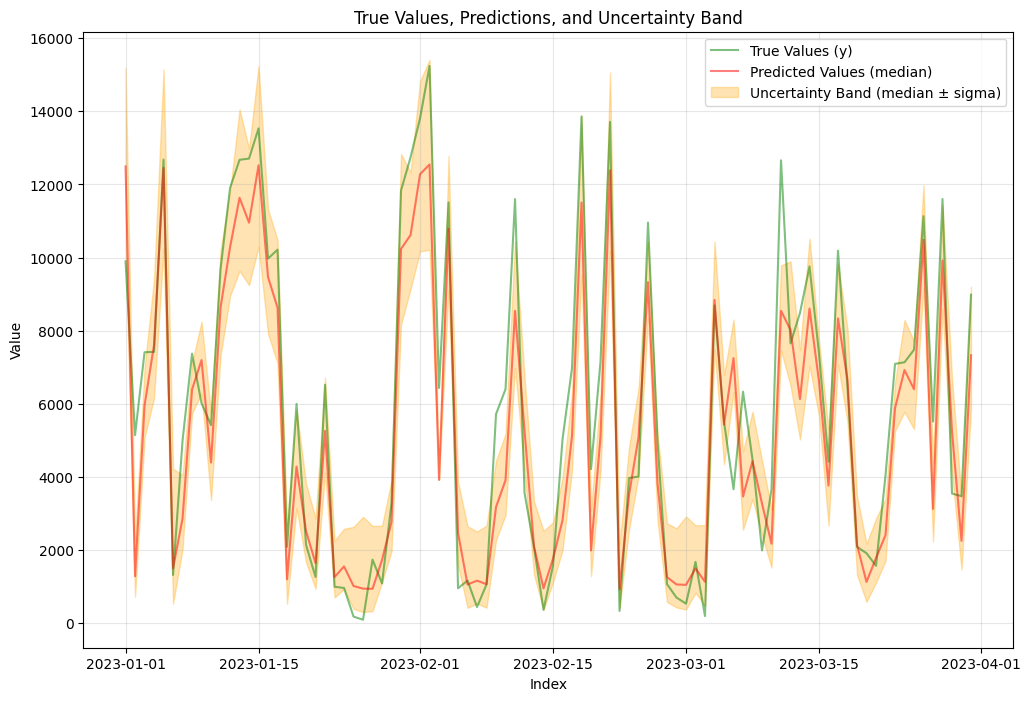

In [88]:
start = 0
end = 90
x = y_validation.index[start:end]
y = y_validation[start:end]
median = y_val_pred[start:end]
sigma_all = np.array([y.scale for y in y_val_dists])
sigma = sigma_all[start:end]

lower_bound = median * np.exp(-sigma)
upper_bound = median * np.exp(sigma)

# Plot
plt.figure(figsize=(12, 8))
plt.plot(x, y, label="True Values (y)", color="green", alpha=0.5)
plt.plot(x, median, label="Predicted Values (median)", color="red", alpha=0.5)
plt.fill_between(x, lower_bound, upper_bound, color="orange", alpha=0.3, label="Uncertainty Band (median ± sigma)")

# Customize the plot
plt.xlabel("Index")
plt.ylabel("Value")
plt.title(f"True Values, Predictions, and Uncertainty Band")
plt.legend()
plt.grid(alpha=0.3)

# Show the plot
plt.show()

##### Probability Integram Transform (PIT)

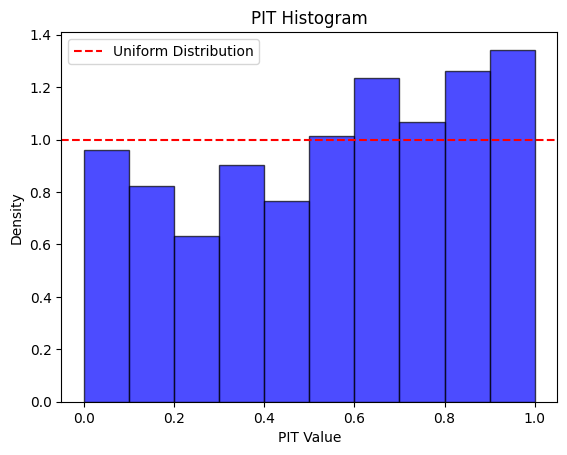

In [89]:
from scipy.stats import lognorm


pit_scores = lognorm.cdf(results['y'], s=results['sigma'], scale=results['median'])

plt.hist(pit_scores, bins=10, range=(0, 1), density=True, alpha=0.7, color='blue', edgecolor='black')
plt.axhline(1, color='red', linestyle='--', label='Uniform Distribution')
plt.title('PIT Histogram')
plt.xlabel('PIT Value')
plt.ylabel('Density')
plt.legend()
plt.show()

#### Normal Distribution

##### Training

In [90]:
y_train_pred, y_train_dists, y_val_pred, y_val_dists, X_train, y_train, X_validation, y_validation = model_NGBoost("00:00", "only_mean_wind", 500, 0.03, Normal)

Data loaded and transformed successfully. Shape of DataFrame: (78912, 22)
# of training observations: 2556 | 77.76%
# of validation observations: 365 | 11.10%
# of test observations: 366 | 11.13%
[iter 0] loss=1735.1167 val_loss=2024.0642 scale=512.0000 norm=449.1209
[iter 1] loss=1726.2357 val_loss=2014.1590 scale=512.0000 norm=447.7525
[iter 2] loss=1717.4336 val_loss=2004.3367 scale=512.0000 norm=446.3911
[iter 3] loss=1708.7099 val_loss=1994.6216 scale=512.0000 norm=445.0350
[iter 4] loss=1700.0636 val_loss=1984.9876 scale=512.0000 norm=443.6878
[iter 5] loss=1691.4936 val_loss=1975.4310 scale=512.0000 norm=442.3483
[iter 6] loss=1682.9951 val_loss=1965.9548 scale=512.0000 norm=441.0148
[iter 7] loss=1674.5718 val_loss=1956.5474 scale=512.0000 norm=439.6935
[iter 8] loss=1666.2326 val_loss=1947.2308 scale=512.0000 norm=438.3813
[iter 9] loss=1657.9570 val_loss=1937.9928 scale=512.0000 norm=437.0803
[iter 10] loss=1649.7545 val_loss=1928.8387 scale=512.0000 norm=435.7857
[iter 11] l

In [91]:
results = pd.DataFrame({'y': y_validation,'mu': y_val_pred, "sigma": [y.scale for y in y_val_dists]})

##### Plot true values and uncertainty band of prediction

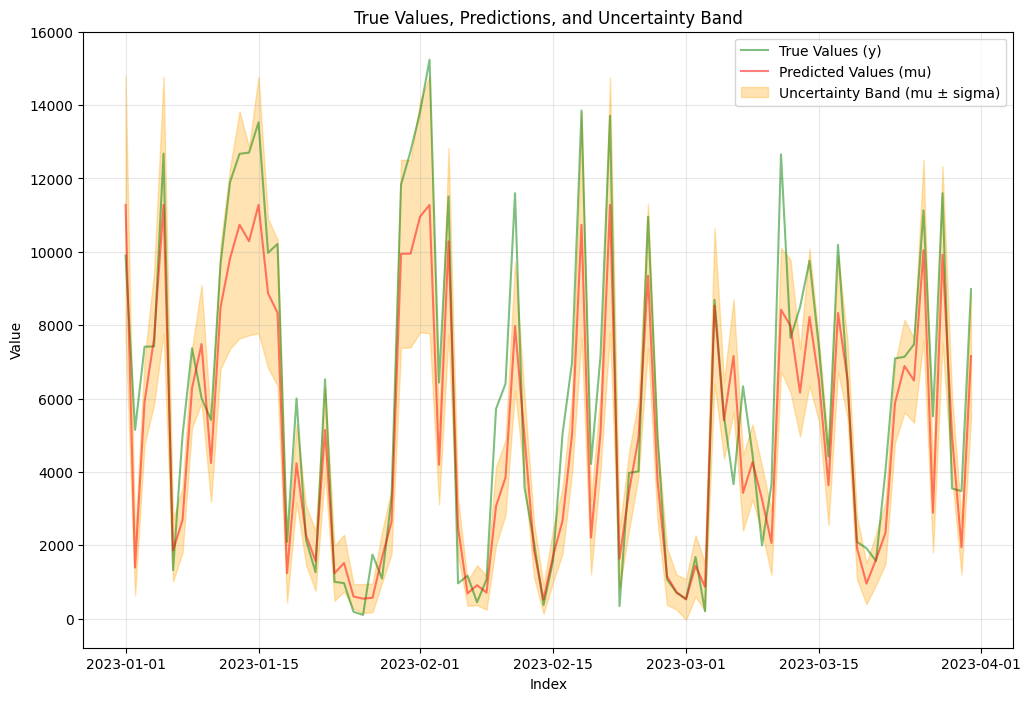

In [92]:
start = 0
end = 90
x = y_validation.index[start:end]
y = y_validation[start:end]
mu = y_val_pred[start:end]

sigma = [y.scale for y in y_val_dists][start:end]  # Normal sigma
lower_bound = mu - sigma  # Normal uncertainty band
upper_bound = mu + sigma  # Normal uncertainty band

# Plot
plt.figure(figsize=(12, 8))
plt.plot(x, y, label="True Values (y)", color="green", alpha=0.5)
plt.plot(x, mu, label="Predicted Values (mu)", color="red", alpha=0.5)
plt.fill_between(x, lower_bound, upper_bound, color="orange", alpha=0.3, label="Uncertainty Band (mu ± sigma)")

# Customize the plot
plt.xlabel("Index")
plt.ylabel("Value")
plt.title(f"True Values, Predictions, and Uncertainty Band")
plt.legend()
plt.grid(alpha=0.3)

# Show the plot
plt.show()

##### Probability Integram Transform (PIT)

In [93]:
from scipy.stats import norm

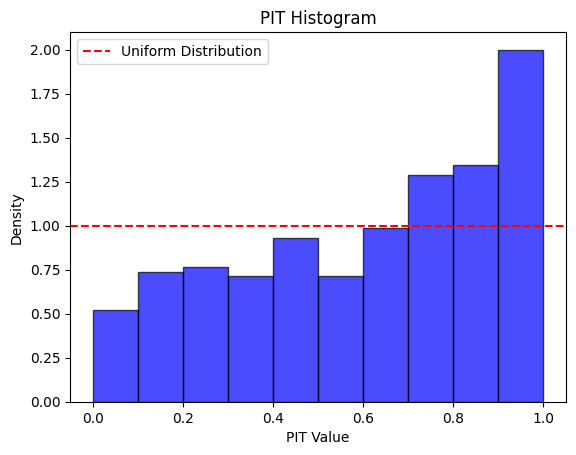

In [94]:
q = norm.cdf(y_validation, loc=y_val_pred, scale=[y.scale for y in y_val_dists])
plt.hist(q, bins=10, range=(0, 1), density=True, alpha=0.7, color='blue', edgecolor='black')
plt.axhline(1, color='red', linestyle='--', label='Uniform Distribution')
plt.title('PIT Histogram')
plt.xlabel('PIT Value')
plt.ylabel('Density')
plt.legend()
plt.show()


### 00:00 only power of today

#### Log Normal Distribution

##### Training

In [78]:
y_train_pred, y_train_dists, y_val_pred, y_val_dists, X_train, y_train, X_validation, y_validation = model_NGBoost("00:00", "only_power", 50, 0.03, LogNormal)

Data loaded and transformed successfully. Shape of DataFrame: (78912, 22)
# of training observations: 2556 | 77.76%
# of validation observations: 365 | 11.10%
# of test observations: 366 | 11.13%
[iter 0] loss=0.5552 val_loss=0.5894 scale=1.0000 norm=1.1868
[iter 1] loss=0.5511 val_loss=0.5850 scale=1.0000 norm=1.1808
[iter 2] loss=0.5472 val_loss=0.5810 scale=1.0000 norm=1.1757
[iter 3] loss=0.5437 val_loss=0.5772 scale=1.0000 norm=1.1713
[iter 4] loss=0.5403 val_loss=0.5738 scale=1.0000 norm=1.1675
[iter 5] loss=0.5371 val_loss=0.5706 scale=1.0000 norm=1.1643
[iter 6] loss=0.5341 val_loss=0.5677 scale=1.0000 norm=1.1615
[iter 7] loss=0.5313 val_loss=0.5648 scale=1.0000 norm=1.1592
[iter 8] loss=0.5287 val_loss=0.5622 scale=1.0000 norm=1.1573
[iter 9] loss=0.5262 val_loss=0.5597 scale=1.0000 norm=1.1557
[iter 10] loss=0.5238 val_loss=0.5573 scale=1.0000 norm=1.1544
[iter 11] loss=0.5216 val_loss=0.5551 scale=1.0000 norm=1.1534
[iter 12] loss=0.5194 val_loss=0.5530 scale=1.0000 norm=1.

In [79]:
results = pd.DataFrame({
    'y': y_validation,
    'median': y_val_pred, 
    "sigma": [y.scale for y in y_val_dists], 
    'mean': [y_val_pred[i] * np.exp(0.5 * (y.scale ** 2)) for i, y in enumerate(y_val_dists)]})

results

y       median     sigma          mean
date                                                    
2023-01-01   9898.0  8229.470307  0.893726  12269.232658
2023-01-02   5146.0  8633.014691  0.893726  12870.872831
2023-01-03   7413.0  4870.297553  0.788174   6644.330289
2023-01-04   7421.0  5606.731040  0.827615   7896.671826
2023-01-05  12678.0  5606.731040  0.827615   7896.671826
...             ...          ...       ...           ...
2023-12-27   9581.0  6311.526019  0.869326   9209.550178
2023-12-28  11063.0  6663.788644  0.844178   9516.302027
2023-12-29  11821.0  8213.814205  0.906354  12385.867878
2023-12-30  11653.0  9178.250235  0.751809  12175.735035
2023-12-31   4106.0  8207.863204  0.662724  10223.555629

[365 rows x 4 columns]

##### Plot true values and uncertainty band of prediction

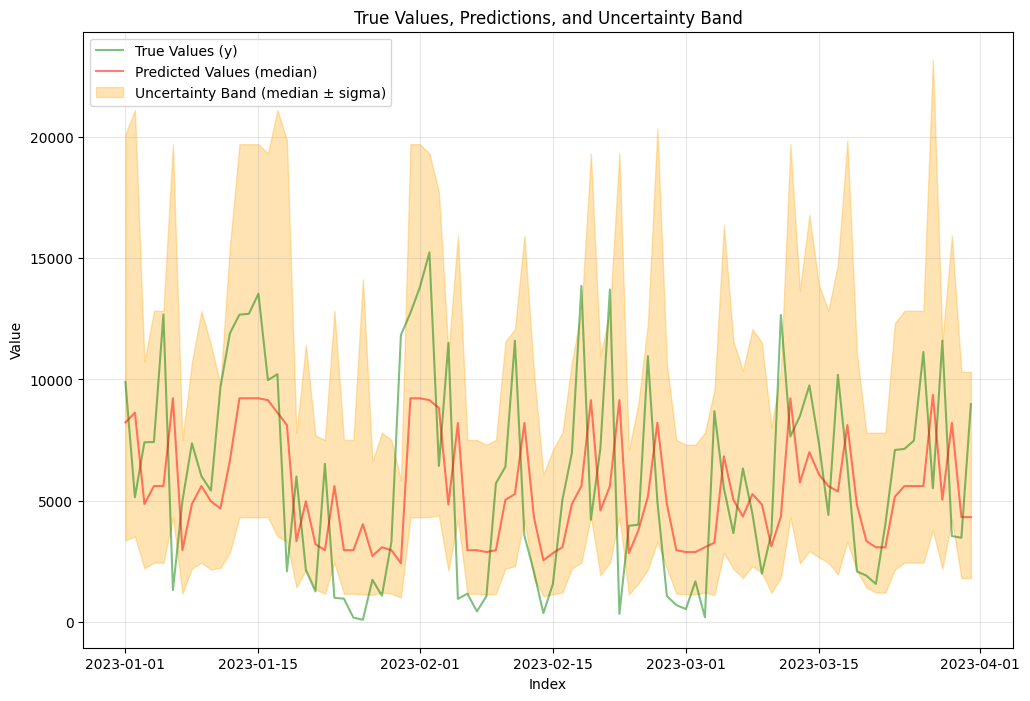

In [80]:
start = 0
end = 90
x = y_validation.index[start:end]
y = y_validation[start:end]
median = y_val_pred[start:end]
sigma_all = np.array([y.scale for y in y_val_dists])
sigma = sigma_all[start:end]

lower_bound = median * np.exp(-sigma)
upper_bound = median * np.exp(sigma)

# Plot
plt.figure(figsize=(12, 8))
plt.plot(x, y, label="True Values (y)", color="green", alpha=0.5)
plt.plot(x, median, label="Predicted Values (median)", color="red", alpha=0.5)
plt.fill_between(x, lower_bound, upper_bound, color="orange", alpha=0.3, label="Uncertainty Band (median ± sigma)")

# Customize the plot
plt.xlabel("Index")
plt.ylabel("Value")
plt.title(f"True Values, Predictions, and Uncertainty Band")
plt.legend()
plt.grid(alpha=0.3)

# Show the plot
plt.show()

##### Probability Integram Transform (PIT)

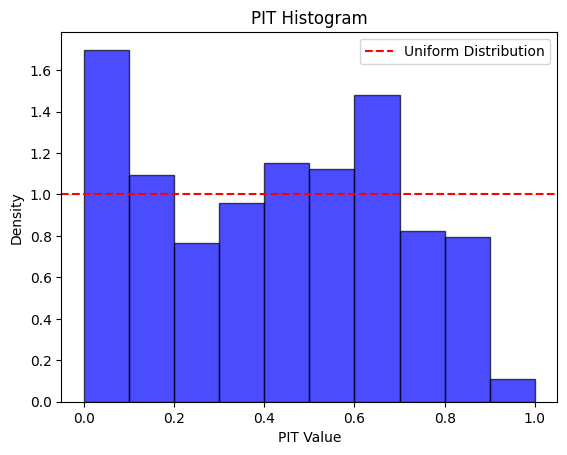

In [81]:
from scipy.stats import lognorm


pit_scores = lognorm.cdf(results['y'], s=results['sigma'], scale=results['median'])

plt.hist(pit_scores, bins=10, range=(0, 1), density=True, alpha=0.7, color='blue', edgecolor='black')
plt.axhline(1, color='red', linestyle='--', label='Uniform Distribution')
plt.title('PIT Histogram')
plt.xlabel('PIT Value')
plt.ylabel('Density')
plt.legend()
plt.show()

In [12]:
y_train_pred, y_train_dists, y_val_pred, y_val_dists, X_train, y_train, X_validation, y_validation = model_NGBoost("00:00", "only_mean_wind", 500, 0.03, natural_gradient=False)

Data loaded and transformed successfully. Shape of DataFrame: (78912, 22)
# of training observations: 2556 | 77.76%
# of validation observations: 365 | 11.10%
# of test observations: 366 | 11.13%
[iter 0] loss=1735.1167 val_loss=2022.7272 scale=0.0010 norm=0.5046
[iter 1] loss=1726.3170 val_loss=2011.2040 scale=0.0010 norm=0.5007
[iter 2] loss=1717.5837 val_loss=1999.9680 scale=0.0010 norm=0.4968
[iter 3] loss=1708.8879 val_loss=1988.4276 scale=0.0010 norm=0.4928
[iter 4] loss=1700.2221 val_loss=1976.8923 scale=0.0010 norm=0.4885
[iter 5] loss=1691.6488 val_loss=1965.5147 scale=0.0010 norm=0.4839


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered i

[iter 6] loss=1683.2317 val_loss=1954.2901 scale=0.0010 norm=0.4791
[iter 7] loss=1674.9894 val_loss=1948.8907 scale=0.0005 norm=0.2369


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scal

[iter 8] loss=1670.9857 val_loss=1943.5627 scale=0.0005 norm=0.2355
[iter 9] loss=1667.0528 val_loss=1938.3187 scale=0.0005 norm=0.2341
[iter 10] loss=1663.1990 val_loss=1933.1865 scale=0.0005 norm=0.2326
[iter 11] loss=1659.4307 val_loss=1927.9891 scale=0.0005 norm=0.2311
[iter 12] loss=1655.7113 val_loss=1923.0166 scale=0.0005 norm=0.2294
[iter 13] loss=1652.0942 val_loss=1918.0914 scale=0.0005 norm=0.2277


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scal

[iter 14] loss=1648.5860 val_loss=1913.5142 scale=0.0005 norm=0.2260
[iter 15] loss=1645.1830 val_loss=1909.0982 scale=0.0005 norm=0.2242
[iter 16] loss=1641.8977 val_loss=1904.8086 scale=0.0005 norm=0.2224
[iter 17] loss=1638.7338 val_loss=1900.3286 scale=0.0005 norm=0.2205
[iter 18] loss=1635.6966 val_loss=1896.3913 scale=0.0005 norm=0.2186
[iter 19] loss=1632.7731 val_loss=1892.2879 scale=0.0005 norm=0.2167


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scal

[iter 20] loss=1629.9786 val_loss=1888.3923 scale=0.0005 norm=0.2147
[iter 21] loss=1627.3105 val_loss=1884.6077 scale=0.0005 norm=0.2127
[iter 22] loss=1624.7377 val_loss=1881.0292 scale=0.0005 norm=0.2107
[iter 23] loss=1622.2892 val_loss=1877.5630 scale=0.0005 norm=0.2087
[iter 24] loss=1619.9602 val_loss=1874.2770 scale=0.0005 norm=0.2067


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scal

[iter 25] loss=1617.6941 val_loss=1871.1363 scale=0.0005 norm=0.2047
[iter 26] loss=1615.5087 val_loss=1868.1507 scale=0.0005 norm=0.2028
[iter 27] loss=1613.4256 val_loss=1865.3169 scale=0.0005 norm=0.2008
[iter 28] loss=1611.4509 val_loss=1862.5083 scale=0.0005 norm=0.1989
[iter 29] loss=1609.5794 val_loss=1859.8855 scale=0.0005 norm=0.1970
[iter 30] loss=1607.8042 val_loss=1857.4596 scale=0.0005 norm=0.1951
[iter 31] loss=1606.1158 val_loss=1855.0355 scale=0.0005 norm=0.1933


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scal

[iter 32] loss=1604.4985 val_loss=1852.7322 scale=0.0005 norm=0.1915
[iter 33] loss=1602.9646 val_loss=1850.6263 scale=0.0005 norm=0.1898
[iter 34] loss=1601.5112 val_loss=1848.5648 scale=0.0005 norm=0.1882
[iter 35] loss=1600.1324 val_loss=1846.6158 scale=0.0005 norm=0.1867
[iter 36] loss=1598.8241 val_loss=1844.7193 scale=0.0005 norm=0.1852


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scal

[iter 37] loss=1597.5701 val_loss=1841.0838 scale=0.0010 norm=0.3675
[iter 38] loss=1595.2093 val_loss=1838.0131 scale=0.0010 norm=0.3621
[iter 39] loss=1593.0795 val_loss=1835.1418 scale=0.0010 norm=0.3571
[iter 40] loss=1591.1569 val_loss=1832.5347 scale=0.0010 norm=0.3526
[iter 41] loss=1589.4062 val_loss=1830.1759 scale=0.0010 norm=0.3485


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])


[iter 42] loss=1587.8023 val_loss=1828.0326 scale=0.0010 norm=0.3449
[iter 43] loss=1586.3323 val_loss=1825.9850 scale=0.0010 norm=0.3415
[iter 44] loss=1584.9845 val_loss=1824.2106 scale=0.0010 norm=0.3384
[iter 45] loss=1583.7293 val_loss=1822.5421 scale=0.0010 norm=0.3355
[iter 46] loss=1582.5548 val_loss=1821.0252 scale=0.0010 norm=0.3328
[iter 47] loss=1581.4610 val_loss=1819.7841 scale=0.0010 norm=0.3303


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1]

[iter 48] loss=1580.4399 val_loss=1818.5877 scale=0.0010 norm=0.3282
[iter 49] loss=1579.4935 val_loss=1817.6671 scale=0.0010 norm=0.3263
[iter 50] loss=1578.5725 val_loss=1816.4393 scale=0.0010 norm=0.3243
[iter 51] loss=1577.6885 val_loss=1815.3353 scale=0.0010 norm=0.3225
[iter 52] loss=1576.8597 val_loss=1814.2522 scale=0.0010 norm=0.3208
[iter 53] loss=1576.0780 val_loss=1812.5725 scale=0.0020 norm=0.6387
[iter 54] loss=1574.6254 val_loss=1810.7536 scale=0.0020 norm=0.6329


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**

[iter 55] loss=1573.2976 val_loss=1809.4923 scale=0.0020 norm=0.6282
[iter 56] loss=1572.0999 val_loss=1808.0818 scale=0.0020 norm=0.6240
[iter 57] loss=1570.9934 val_loss=1807.1061 scale=0.0020 norm=0.6199
[iter 58] loss=1569.9771 val_loss=1806.2097 scale=0.0020 norm=0.6160
[iter 59] loss=1569.0411 val_loss=1805.2334 scale=0.0020 norm=0.6127
[iter 60] loss=1568.1035 val_loss=1804.3477 scale=0.0020 norm=0.6092


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: divide by zero encountered in divide
  Z = (Y - self.loc) / self.scale
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:30: RuntimeWarning: invalid value encountered in multiply
  return self.scale * (
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow

[iter 61] loss=1567.2479 val_loss=1803.4767 scale=0.0020 norm=0.6060
[iter 62] loss=1566.4688 val_loss=1802.8325 scale=0.0020 norm=0.6032
[iter 63] loss=1565.7505 val_loss=1802.1934 scale=0.0020 norm=0.6007
[iter 64] loss=1565.0763 val_loss=1801.5482 scale=0.0020 norm=0.5983
[iter 65] loss=1564.4667 val_loss=1801.0278 scale=0.0020 norm=0.5962
[iter 66] loss=1563.8877 val_loss=1800.5344 scale=0.0020 norm=0.5942
[iter 67] loss=1563.3432 val_loss=1800.2188 scale=0.0020 norm=0.5923
[iter 68] loss=1562.8476 val_loss=1799.7558 scale=0.0020 norm=0.5904
[iter 69] loss=1562.3610 val_loss=1799.3306 scale=0.0020 norm=0.5887
[iter 70] loss=1561.9120 val_loss=1798.9247 scale=0.0020 norm=0.5870
[iter 71] loss=1561.4785 val_loss=1798.5283 scale=0.0020 norm=0.5855
[iter 72] loss=1561.0642 val_loss=1798.1363 scale=0.0020 norm=0.5841
[iter 73] loss=1560.6624 val_loss=1797.7379 scale=0.0020 norm=0.5828
[iter 74] loss=1560.2819 val_loss=1797.4312 scale=0.0020 norm=0.5815
[iter 75] loss=1559.9303 val_loss=

c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C


[iter 80] loss=1558.3856 val_loss=1796.0163 scale=0.0020 norm=0.5750
[iter 81] loss=1558.1234 val_loss=1795.8029 scale=0.0020 norm=0.5742
[iter 82] loss=1557.8723 val_loss=1795.6654 scale=0.0020 norm=0.5735
[iter 83] loss=1557.6554 val_loss=1795.6062 scale=0.0010 norm=0.2863
[iter 84] loss=1557.4731 val_loss=1795.5058 scale=0.0010 norm=0.2859
[iter 85] loss=1557.2987 val_loss=1795.4522 scale=0.0010 norm=0.2855
[iter 86] loss=1557.1339 val_loss=1795.4178 scale=0.0010 norm=0.2852


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: Run

[iter 87] loss=1556.9790 val_loss=1795.3082 scale=0.0010 norm=0.2849
[iter 88] loss=1556.8276 val_loss=1795.2818 scale=0.0010 norm=0.2846
[iter 89] loss=1556.6832 val_loss=1795.1584 scale=0.0020 norm=0.5687
[iter 90] loss=1556.5109 val_loss=1795.1368 scale=0.0020 norm=0.5681
[iter 91] loss=1556.3413 val_loss=1794.9583 scale=0.0020 norm=0.5674


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: overflow encountered in divide
  Z = (Y - self.loc) / self.scale
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWar

[iter 92] loss=1556.1532 val_loss=1794.7245 scale=0.0020 norm=0.5668
[iter 93] loss=1555.9898 val_loss=1794.6180 scale=0.0020 norm=0.5663
[iter 94] loss=1555.8122 val_loss=1794.5014 scale=0.0020 norm=0.5657
[iter 95] loss=1555.6563 val_loss=1794.4286 scale=0.0020 norm=0.5652
[iter 96] loss=1555.5023 val_loss=1794.2959 scale=0.0020 norm=0.5647


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2


[iter 97] loss=1555.3471 val_loss=1794.2778 scale=0.0020 norm=0.5642
[iter 98] loss=1555.2038 val_loss=1794.2681 scale=0.0020 norm=0.5637
[iter 99] loss=1555.0775 val_loss=1794.0496 scale=0.0039 norm=1.1265
[iter 100] loss=1554.8411 val_loss=1794.0656 scale=0.0010 norm=0.2812
[iter 101] loss=1554.7220 val_loss=1794.0689 scale=0.0010 norm=0.2810
[iter 102] loss=1554.6111 val_loss=1793.9988 scale=0.0010 norm=0.2807


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow

[iter 103] loss=1554.5012 val_loss=1793.9219 scale=0.0010 norm=0.2805
[iter 104] loss=1554.3855 val_loss=1793.8824 scale=0.0010 norm=0.2803
[iter 105] loss=1554.3069 val_loss=1793.8398 scale=0.0010 norm=0.2801
[iter 106] loss=1554.2347 val_loss=1793.7835 scale=0.0020 norm=0.5599
[iter 107] loss=1554.0880 val_loss=1793.7092 scale=0.0010 norm=0.2797
[iter 108] loss=1553.9881 val_loss=1793.6069 scale=0.0020 norm=0.5590


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
 

[iter 109] loss=1553.8112 val_loss=1793.5259 scale=0.0010 norm=0.2792
[iter 110] loss=1553.7154 val_loss=1793.4860 scale=0.0020 norm=0.5579
[iter 111] loss=1553.6174 val_loss=1793.4424 scale=0.0020 norm=0.5575
[iter 112] loss=1553.5294 val_loss=1793.3151 scale=0.0020 norm=0.5571
[iter 113] loss=1553.4356 val_loss=1793.2662 scale=0.0020 norm=0.5568
[iter 114] loss=1553.3349 val_loss=1793.2739 scale=0.0020 norm=0.5564
[iter 115] loss=1553.2404 val_loss=1793.2100 scale=0.0020 norm=0.5561


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in s

[iter 116] loss=1553.1434 val_loss=1793.2096 scale=0.0020 norm=0.5558
[iter 117] loss=1553.0609 val_loss=1793.2006 scale=0.0020 norm=0.5555
[iter 118] loss=1552.9899 val_loss=1793.2107 scale=0.0002 norm=0.0694
[iter 119] loss=1552.9809 val_loss=1793.1970 scale=0.0020 norm=0.5551
[iter 120] loss=1552.8961 val_loss=1793.2106 scale=0.0005 norm=0.1387
[iter 121] loss=1552.8752 val_loss=1793.2577 scale=0.0010 norm=0.2773
[iter 122] loss=1552.8128 val_loss=1793.1177 scale=0.0010 norm=0.2772


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: divide by zero encountered in divide
  Z = (Y - self.loc) / self.scale
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:30: RuntimeWarning: invalid value encountered in multiply
  return self.scale * (
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarnin

[iter 123] loss=1552.7152 val_loss=1793.0976 scale=0.0010 norm=0.2770
[iter 124] loss=1552.6618 val_loss=1792.8885 scale=0.0010 norm=0.2769
[iter 125] loss=1552.5611 val_loss=1792.8274 scale=0.0020 norm=0.5533
[iter 126] loss=1552.4378 val_loss=1792.7576 scale=0.0010 norm=0.2764
[iter 127] loss=1552.3953 val_loss=1792.7449 scale=0.0005 norm=0.1382


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: divide by zero encountered in divide
  Z = (Y - self.loc) / self.scale
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:30: RuntimeWarning

[iter 128] loss=1552.3653 val_loss=1792.6701 scale=0.0020 norm=0.5523
[iter 129] loss=1552.2842 val_loss=1792.6951 scale=0.0020 norm=0.5520
[iter 130] loss=1552.2271 val_loss=1792.7268 scale=0.0020 norm=0.5517
[iter 131] loss=1552.1370 val_loss=1792.7434 scale=0.0020 norm=0.5513
[iter 132] loss=1552.0520 val_loss=1792.6768 scale=0.0020 norm=0.5510
[iter 133] loss=1551.9806 val_loss=1792.6983 scale=0.0020 norm=0.5507
[iter 134] loss=1551.8910 val_loss=1792.6335 scale=0.0010 norm=0.2753


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: divide by zero encountered in divide
  Z = (Y - self.loc) / self.scale
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:30: RuntimeWarning: invalid value encountered in multiply
  return self.scale * (
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow en

[iter 135] loss=1551.8514 val_loss=1792.6053 scale=0.0020 norm=0.5503
[iter 136] loss=1551.7671 val_loss=1792.5532 scale=0.0010 norm=0.2750
[iter 137] loss=1551.7262 val_loss=1792.5335 scale=0.0020 norm=0.5498
[iter 138] loss=1551.6487 val_loss=1792.5391 scale=0.0002 norm=0.0687
[iter 139] loss=1551.6412 val_loss=1792.5784 scale=0.0020 norm=0.5495
[iter 140] loss=1551.5648 val_loss=1792.5828 scale=0.0005 norm=0.1373


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: divide by zero encountered in divide
  Z = (Y - self.loc) / self.scale
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:30: RuntimeWarning

[iter 141] loss=1551.5510 val_loss=1792.5404 scale=0.0010 norm=0.2746
[iter 142] loss=1551.5198 val_loss=1792.5534 scale=0.0020 norm=0.5490
[iter 143] loss=1551.4536 val_loss=1792.5361 scale=0.0020 norm=0.5488
[iter 144] loss=1551.3841 val_loss=1792.5706 scale=0.0020 norm=0.5485


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: overflow encountered in divide
  Z = (Y - self.loc) / self.scale
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: over

[iter 145] loss=1551.3184 val_loss=1792.5191 scale=0.0010 norm=0.2741
[iter 146] loss=1551.2836 val_loss=1792.5311 scale=0.0020 norm=0.5481
[iter 147] loss=1551.2148 val_loss=1792.6384 scale=0.0020 norm=0.5479
[iter 148] loss=1551.1753 val_loss=1792.6251 scale=0.0005 norm=0.1369
[iter 149] loss=1551.1510 val_loss=1792.6314 scale=0.0005 norm=0.1368
[iter 150] loss=1551.1319 val_loss=1792.6710 scale=0.0010 norm=0.2736
[iter 151] loss=1551.0974 val_loss=1792.5525 scale=0.0010 norm=0.2736
[iter 152] loss=1551.0096 val_loss=1792.5440 scale=0.0010 norm=0.2734
[iter 153] loss=1550.9835 val_loss=1792.5403 scale=0.0010 norm=0.2734
[iter 154] loss=1550.9434 val_loss=1792.5285 scale=0.0005 norm=0.1366


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: overflow encountered in divide
  Z = (Y - self.loc) / self.scale
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: over

[iter 155] loss=1550.9215 val_loss=1792.4876 scale=0.0020 norm=0.5463
[iter 156] loss=1550.8623 val_loss=1792.5013 scale=0.0020 norm=0.5460
[iter 157] loss=1550.8066 val_loss=1792.5524 scale=0.0010 norm=0.2729
[iter 158] loss=1550.7603 val_loss=1792.5715 scale=0.0010 norm=0.2728
[iter 159] loss=1550.7416 val_loss=1792.5857 scale=0.0020 norm=0.5455


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: overflow encountered in divide
  Z = (Y - self.loc) / self.scale
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2


[iter 160] loss=1550.6890 val_loss=1792.6356 scale=0.0010 norm=0.2727
[iter 161] loss=1550.6637 val_loss=1792.5621 scale=0.0010 norm=0.2726
[iter 162] loss=1550.5987 val_loss=1792.4990 scale=0.0010 norm=0.2724
[iter 163] loss=1550.5378 val_loss=1792.5471 scale=0.0010 norm=0.2724
[iter 164] loss=1550.4970 val_loss=1792.4921 scale=0.0010 norm=0.2723


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: divide by zero encountered in divide
  Z = (Y - self.loc) / self.scale
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:30: RuntimeWarning: invalid value encountered in multiply
  return self.scale * (
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
 

[iter 165] loss=1550.4546 val_loss=1792.4811 scale=0.0005 norm=0.1361
[iter 166] loss=1550.4352 val_loss=1792.4413 scale=0.0020 norm=0.5442
[iter 167] loss=1550.3809 val_loss=1792.4184 scale=0.0020 norm=0.5440
[iter 168] loss=1550.3303 val_loss=1792.4146 scale=0.0005 norm=0.1359
[iter 169] loss=1550.3052 val_loss=1792.4498 scale=0.0020 norm=0.5436
[iter 170] loss=1550.2565 val_loss=1792.4673 scale=0.0010 norm=0.2717


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: divide by zero encountered in divide
  Z = (Y - self.loc) / self.scale
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:30: RuntimeWarning: invalid value encountered in multiply
  return self.scale * (
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow en

[iter 171] loss=1550.2395 val_loss=1792.3907 scale=0.0020 norm=0.5433
[iter 172] loss=1550.1777 val_loss=1792.4354 scale=0.0005 norm=0.1358
[iter 173] loss=1550.1460 val_loss=1792.4403 scale=0.0010 norm=0.2715
[iter 174] loss=1550.1292 val_loss=1792.3662 scale=0.0020 norm=0.5428
[iter 175] loss=1550.0699 val_loss=1792.4243 scale=0.0005 norm=0.1356


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered i

[iter 176] loss=1550.0405 val_loss=1792.4735 scale=0.0010 norm=0.2712
[iter 177] loss=1549.9984 val_loss=1792.4688 scale=0.0002 norm=0.0678
[iter 178] loss=1549.9900 val_loss=1792.5128 scale=0.0005 norm=0.1355
[iter 179] loss=1549.9638 val_loss=1792.4792 scale=0.0010 norm=0.2710
[iter 180] loss=1549.9238 val_loss=1792.4746 scale=0.0002 norm=0.0677
[iter 181] loss=1549.9158 val_loss=1792.5064 scale=0.0010 norm=0.2709


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: divide by zero encountered in divide
  Z = (Y - self.loc) / self.scale
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:30: RuntimeWarning: invalid value encountered in multiply
  return self.scale * (
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: divide by zero encoun

[iter 182] loss=1549.8975 val_loss=1792.4770 scale=0.0010 norm=0.2708
[iter 183] loss=1549.8228 val_loss=1792.4727 scale=0.0002 norm=0.0677
[iter 184] loss=1549.8153 val_loss=1792.4432 scale=0.0010 norm=0.2707
[iter 185] loss=1549.7449 val_loss=1792.4287 scale=0.0020 norm=0.5411
[iter 186] loss=1549.7129 val_loss=1792.3821 scale=0.0010 norm=0.2705


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: divide by zero encountered in divide
  Z = (Y - self.loc) / self.scale
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:30: RuntimeWarning: invalid value encountered in multiply
  return self.scale * (
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow

[iter 187] loss=1549.6675 val_loss=1792.4046 scale=0.0010 norm=0.2704
[iter 188] loss=1549.6366 val_loss=1792.4006 scale=0.0002 norm=0.0676
[iter 189] loss=1549.6295 val_loss=1792.3752 scale=0.0010 norm=0.2702
[iter 190] loss=1549.5872 val_loss=1792.3944 scale=0.0010 norm=0.2702
[iter 191] loss=1549.5592 val_loss=1792.3906 scale=0.0002 norm=0.0675
[iter 192] loss=1549.5524 val_loss=1792.3322 scale=0.0010 norm=0.2700


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: overflow encountered in divide
  Z = (Y - self.loc) / self.scale
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: overflo

[iter 193] loss=1549.5005 val_loss=1792.2723 scale=0.0020 norm=0.5397
[iter 194] loss=1549.4430 val_loss=1792.2531 scale=0.0010 norm=0.2698
[iter 195] loss=1549.4040 val_loss=1792.2478 scale=0.0005 norm=0.1349
[iter 196] loss=1549.3833 val_loss=1792.1857 scale=0.0020 norm=0.5393
[iter 197] loss=1549.3290 val_loss=1792.2337 scale=0.0005 norm=0.1348
[iter 198] loss=1549.2926 val_loss=1792.1921 scale=0.0010 norm=0.2694
[iter 199] loss=1549.2560 val_loss=1792.1906 scale=0.0005 norm=0.1347


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: divide by zero encountered in divide
  Z = (Y - self.loc) / self.scale
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: overflow encountered in divide
  Z = (Y - self.loc) / self.scale
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in squar

[iter 200] loss=1549.2433 val_loss=1792.2438 scale=0.0010 norm=0.2693
[iter 201] loss=1549.2082 val_loss=1792.1678 scale=0.0010 norm=0.2692
[iter 202] loss=1549.1625 val_loss=1792.1341 scale=0.0010 norm=0.2691
[iter 203] loss=1549.1285 val_loss=1792.1296 scale=0.0005 norm=0.1345
[iter 204] loss=1549.1087 val_loss=1792.0463 scale=0.0010 norm=0.2689
[iter 205] loss=1549.0667 val_loss=1792.0212 scale=0.0020 norm=0.5377


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
 

[iter 206] loss=1549.0231 val_loss=1791.9631 scale=0.0010 norm=0.2688
[iter 207] loss=1548.9843 val_loss=1791.9575 scale=0.0010 norm=0.2687
[iter 208] loss=1548.9528 val_loss=1791.9667 scale=0.0005 norm=0.1343
[iter 209] loss=1548.9349 val_loss=1791.9167 scale=0.0010 norm=0.2685
[iter 210] loss=1548.9003 val_loss=1791.9144 scale=0.0005 norm=0.1342


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
 

[iter 211] loss=1548.8815 val_loss=1791.9057 scale=0.0020 norm=0.5368
[iter 212] loss=1548.8217 val_loss=1791.9163 scale=0.0010 norm=0.2683
[iter 213] loss=1548.7893 val_loss=1791.9159 scale=0.0005 norm=0.1341
[iter 214] loss=1548.7713 val_loss=1791.9089 scale=0.0005 norm=0.1341
[iter 215] loss=1548.7587 val_loss=1791.9220 scale=0.0010 norm=0.2681


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: Run

[iter 216] loss=1548.7432 val_loss=1791.8410 scale=0.0010 norm=0.2680
[iter 217] loss=1548.7131 val_loss=1791.7913 scale=0.0020 norm=0.5359
[iter 218] loss=1548.6588 val_loss=1791.7867 scale=0.0010 norm=0.2678
[iter 219] loss=1548.6292 val_loss=1791.7816 scale=0.0010 norm=0.2677
[iter 220] loss=1548.6010 val_loss=1791.8358 scale=0.0010 norm=0.2677
[iter 221] loss=1548.5674 val_loss=1791.8300 scale=0.0002 norm=0.0669


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow en

[iter 222] loss=1548.5611 val_loss=1791.8557 scale=0.0005 norm=0.1338
[iter 223] loss=1548.5294 val_loss=1791.8819 scale=0.0010 norm=0.2675
[iter 224] loss=1548.4971 val_loss=1791.8827 scale=0.0010 norm=0.2674
[iter 225] loss=1548.4534 val_loss=1791.8791 scale=0.0002 norm=0.0668
[iter 226] loss=1548.4475 val_loss=1791.8034 scale=0.0010 norm=0.2673
[iter 227] loss=1548.4209 val_loss=1791.7811 scale=0.0020 norm=0.5344


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: o

[iter 228] loss=1548.3816 val_loss=1791.7813 scale=0.0010 norm=0.2671
[iter 229] loss=1548.3673 val_loss=1791.7826 scale=0.0010 norm=0.2671
[iter 230] loss=1548.3273 val_loss=1791.7669 scale=0.0010 norm=0.2670
[iter 231] loss=1548.3138 val_loss=1791.7686 scale=0.0002 norm=0.0667
[iter 232] loss=1548.3083 val_loss=1791.7790 scale=0.0020 norm=0.5338
[iter 233] loss=1548.2658 val_loss=1791.7914 scale=0.0010 norm=0.2668


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: overflow encountered in divide
  Z = (Y - self.loc) / self.scale
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: over

[iter 234] loss=1548.2538 val_loss=1791.7935 scale=0.0010 norm=0.2668
[iter 235] loss=1548.2233 val_loss=1791.7655 scale=0.0020 norm=0.5334
[iter 236] loss=1548.1752 val_loss=1791.7676 scale=0.0002 norm=0.0667
[iter 237] loss=1548.1699 val_loss=1791.7937 scale=0.0010 norm=0.2666
[iter 238] loss=1548.1281 val_loss=1791.7635 scale=0.0010 norm=0.2665
[iter 239] loss=1548.0971 val_loss=1791.7454 scale=0.0020 norm=0.5328
[iter 240] loss=1548.0536 val_loss=1791.7424 scale=0.0002 norm=0.0666
[iter 241] loss=1548.0481 val_loss=1791.7430 scale=0.0002 norm=0.0666
[iter 242] loss=1548.0432 val_loss=1791.7284 scale=0.0010 norm=0.2662
[iter 243] loss=1548.0144 val_loss=1791.7750 scale=0.0005 norm=0.1331
[iter 244] loss=1547.9947 val_loss=1791.8212 scale=0.0005 norm=0.1330
[iter 245] loss=1547.9766 val_loss=1791.8119 scale=0.0005 norm=0.1330


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encou

[iter 246] loss=1547.9660 val_loss=1791.8395 scale=0.0010 norm=0.2659
[iter 247] loss=1547.9509 val_loss=1791.8527 scale=0.0020 norm=0.5316
[iter 248] loss=1547.9162 val_loss=1791.8640 scale=0.0010 norm=0.2658
[iter 249] loss=1547.9029 val_loss=1791.8577 scale=0.0010 norm=0.2657
[iter 250] loss=1547.8789 val_loss=1791.9198 scale=0.0020 norm=0.5312
[iter 251] loss=1547.8201 val_loss=1791.9946 scale=0.0010 norm=0.2655


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\dis

[iter 252] loss=1547.7546 val_loss=1792.0280 scale=0.0005 norm=0.1327
[iter 253] loss=1547.7246 val_loss=1792.0919 scale=0.0010 norm=0.2653
[iter 254] loss=1547.6995 val_loss=1792.1251 scale=0.0005 norm=0.1326
[iter 255] loss=1547.6712 val_loss=1792.1447 scale=0.0020 norm=0.5304
[iter 256] loss=1547.6404 val_loss=1792.1597 scale=0.0010 norm=0.2651
[iter 257] loss=1547.6124 val_loss=1792.1818 scale=0.0010 norm=0.2651
[iter 258] loss=1547.5488 val_loss=1792.1808 scale=0.0002 norm=0.0662


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow en

[iter 259] loss=1547.5437 val_loss=1792.1544 scale=0.0005 norm=0.1324
[iter 260] loss=1547.5235 val_loss=1792.1821 scale=0.0010 norm=0.2648
[iter 261] loss=1547.5008 val_loss=1792.1854 scale=0.0010 norm=0.2648
[iter 262] loss=1547.4883 val_loss=1792.1863 scale=0.0020 norm=0.5295
[iter 263] loss=1547.4648 val_loss=1792.2607 scale=0.0010 norm=0.2647
[iter 264] loss=1547.3858 val_loss=1792.2344 scale=0.0005 norm=0.1322
[iter 265] loss=1547.3667 val_loss=1792.2711 scale=0.0005 norm=0.1322
[iter 266] loss=1547.3481 val_loss=1792.2735 scale=0.0005 norm=0.1322
[iter 267] loss=1547.3289 val_loss=1792.3017 scale=0.0005 norm=0.1322
[iter 268] loss=1547.3032 val_loss=1792.3044 scale=0.0005 norm=0.1321
[iter 269] loss=1547.2854 val_loss=1792.3223 scale=0.0020 norm=0.5283


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow en

[iter 270] loss=1547.2577 val_loss=1792.3232 scale=0.0020 norm=0.5282
[iter 271] loss=1547.2217 val_loss=1792.3243 scale=0.0010 norm=0.2640
[iter 272] loss=1547.1857 val_loss=1792.3387 scale=0.0010 norm=0.2640
[iter 273] loss=1547.1222 val_loss=1792.3652 scale=0.0005 norm=0.1319
[iter 274] loss=1547.0986 val_loss=1792.3710 scale=0.0020 norm=0.5276


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow

[iter 275] loss=1547.0712 val_loss=1792.3560 scale=0.0010 norm=0.2637
[iter 276] loss=1547.0121 val_loss=1792.3588 scale=0.0005 norm=0.1318
[iter 277] loss=1546.9956 val_loss=1792.3759 scale=0.0020 norm=0.5271
[iter 278] loss=1546.9704 val_loss=1792.3789 scale=0.0005 norm=0.1318
[iter 279] loss=1546.9550 val_loss=1792.3566 scale=0.0005 norm=0.1317
[iter 280] loss=1546.9315 val_loss=1792.3061 scale=0.0010 norm=0.2633
[iter 281] loss=1546.8981 val_loss=1792.3166 scale=0.0005 norm=0.1316
[iter 282] loss=1546.8836 val_loss=1792.2722 scale=0.0020 norm=0.5264
[iter 283] loss=1546.8449 val_loss=1792.2689 scale=0.0002 norm=0.0658


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: over

[iter 284] loss=1546.8402 val_loss=1792.2691 scale=0.0002 norm=0.0658
[iter 285] loss=1546.8361 val_loss=1792.3278 scale=0.0020 norm=0.5260
[iter 286] loss=1546.8126 val_loss=1792.3257 scale=0.0010 norm=0.2630
[iter 287] loss=1546.7795 val_loss=1792.3383 scale=0.0010 norm=0.2628
[iter 288] loss=1546.7275 val_loss=1792.3014 scale=0.0010 norm=0.2627
[iter 289] loss=1546.6977 val_loss=1792.3045 scale=0.0005 norm=0.1313


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: divide by zero encountered in divide
  Z = (Y - self.loc) / self.scale
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: overflow encountered i

[iter 290] loss=1546.6843 val_loss=1792.2621 scale=0.0020 norm=0.5250
[iter 291] loss=1546.6337 val_loss=1792.3239 scale=0.0005 norm=0.1312
[iter 292] loss=1546.6047 val_loss=1792.3845 scale=0.0005 norm=0.1311
[iter 293] loss=1546.5779 val_loss=1792.3661 scale=0.0005 norm=0.1311
[iter 294] loss=1546.5577 val_loss=1792.3697 scale=0.0005 norm=0.1310
[iter 295] loss=1546.5453 val_loss=1792.3464 scale=0.0020 norm=0.5240
[iter 296] loss=1546.5104 val_loss=1792.2967 scale=0.0010 norm=0.2620
[iter 297] loss=1546.4806 val_loss=1792.3566 scale=0.0005 norm=0.1309
[iter 298] loss=1546.4559 val_loss=1792.3433 scale=0.0005 norm=0.1309
[iter 299] loss=1546.4377 val_loss=1792.3479 scale=0.0005 norm=0.1308
[iter 300] loss=1546.4260 val_loss=1792.3203 scale=0.0020 norm=0.5232


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: divide by zero encountered in divide
  Z = (Y - self.loc) / self.scale
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow enc

[iter 301] loss=1546.3931 val_loss=1792.3675 scale=0.0010 norm=0.2615
[iter 302] loss=1546.3726 val_loss=1792.3574 scale=0.0010 norm=0.2615
[iter 303] loss=1546.3485 val_loss=1792.4160 scale=0.0005 norm=0.1307
[iter 304] loss=1546.3259 val_loss=1792.4289 scale=0.0005 norm=0.1307
[iter 305] loss=1546.3150 val_loss=1792.4703 scale=0.0020 norm=0.5226
[iter 306] loss=1546.2820 val_loss=1792.4666 scale=0.0002 norm=0.0653


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: over

[iter 307] loss=1546.2776 val_loss=1792.4632 scale=0.0002 norm=0.0653
[iter 308] loss=1546.2735 val_loss=1792.4687 scale=0.0005 norm=0.1306
[iter 309] loss=1546.2633 val_loss=1792.4654 scale=0.0002 norm=0.0653
[iter 310] loss=1546.2594 val_loss=1792.4623 scale=0.0005 norm=0.1306


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:3

[iter 311] loss=1546.2532 val_loss=1792.4846 scale=0.0020 norm=0.5221
[iter 312] loss=1546.2354 val_loss=1792.4844 scale=0.0020 norm=0.5221
[iter 313] loss=1546.2149 val_loss=1792.4152 scale=0.0010 norm=0.2610
[iter 314] loss=1546.1924 val_loss=1792.4742 scale=0.0020 norm=0.5218
[iter 315] loss=1546.1423 val_loss=1792.4864 scale=0.0005 norm=0.1304
[iter 316] loss=1546.1328 val_loss=1792.4879 scale=0.0010 norm=0.2608
[iter 317] loss=1546.1062 val_loss=1792.4673 scale=0.0020 norm=0.5214
[iter 318] loss=1546.0754 val_loss=1792.4506 scale=0.0005 norm=0.1303
[iter 319] loss=1546.0645 val_loss=1792.4478 scale=0.0010 norm=0.2606
[iter 320] loss=1546.0532 val_loss=1792.4341 scale=0.0005 norm=0.1303
[iter 321] loss=1546.0365 val_loss=1792.4506 scale=0.0020 norm=0.5209


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in s

[iter 322] loss=1546.0139 val_loss=1792.4745 scale=0.0010 norm=0.2604
[iter 323] loss=1545.9947 val_loss=1792.4765 scale=0.0010 norm=0.2604
[iter 324] loss=1545.9650 val_loss=1792.4676 scale=0.0010 norm=0.2603
[iter 325] loss=1545.9438 val_loss=1792.4525 scale=0.0010 norm=0.2602
[iter 326] loss=1545.9335 val_loss=1792.5120 scale=0.0020 norm=0.5204
[iter 327] loss=1545.8876 val_loss=1792.5089 scale=0.0002 norm=0.0650
[iter 328] loss=1545.8839 val_loss=1792.5112 scale=0.0010 norm=0.2601
[iter 329] loss=1545.8745 val_loss=1792.5281 scale=0.0010 norm=0.2600
[iter 330] loss=1545.8527 val_loss=1792.5252 scale=0.0002 norm=0.0650
[iter 331] loss=1545.8492 val_loss=1792.5331 scale=0.0020 norm=0.5199


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.p

[iter 332] loss=1545.8287 val_loss=1792.6056 scale=0.0010 norm=0.2599
[iter 333] loss=1545.7624 val_loss=1792.6144 scale=0.0020 norm=0.5195
[iter 334] loss=1545.7286 val_loss=1792.6273 scale=0.0005 norm=0.1298
[iter 335] loss=1545.7201 val_loss=1792.6282 scale=0.0010 norm=0.2597
[iter 336] loss=1545.6956 val_loss=1792.6182 scale=0.0005 norm=0.1298
[iter 337] loss=1545.6802 val_loss=1792.6425 scale=0.0010 norm=0.2595
[iter 338] loss=1545.6679 val_loss=1792.5758 scale=0.0010 norm=0.2594


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: Runtim

[iter 339] loss=1545.6409 val_loss=1792.5661 scale=0.0005 norm=0.1297
[iter 340] loss=1545.6267 val_loss=1792.6235 scale=0.0020 norm=0.5186
[iter 341] loss=1545.5838 val_loss=1792.6282 scale=0.0010 norm=0.2592
[iter 342] loss=1545.5753 val_loss=1792.5414 scale=0.0010 norm=0.2592
[iter 343] loss=1545.5541 val_loss=1792.5354 scale=0.0005 norm=0.1296


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in squa

[iter 344] loss=1545.5410 val_loss=1792.5639 scale=0.0020 norm=0.5181
[iter 345] loss=1545.5124 val_loss=1792.5660 scale=0.0010 norm=0.2590
[iter 346] loss=1545.4848 val_loss=1792.5362 scale=0.0010 norm=0.2589
[iter 347] loss=1545.4664 val_loss=1792.5240 scale=0.0005 norm=0.1294
[iter 348] loss=1545.4567 val_loss=1792.5777 scale=0.0010 norm=0.2588
[iter 349] loss=1545.4406 val_loss=1792.5861 scale=0.0005 norm=0.1294
[iter 350] loss=1545.4330 val_loss=1792.5949 scale=0.0010 norm=0.2587
[iter 351] loss=1545.4161 val_loss=1792.5942 scale=0.0020 norm=0.5173
[iter 352] loss=1545.3987 val_loss=1792.5969 scale=0.0010 norm=0.2586
[iter 353] loss=1545.3905 val_loss=1792.5922 scale=0.0010 norm=0.2586
[iter 354] loss=1545.3653 val_loss=1792.5977 scale=0.0010 norm=0.2585
[iter 355] loss=1545.3575 val_loss=1792.5967 scale=0.0010 norm=0.2585


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: Run

[iter 356] loss=1545.3490 val_loss=1792.5895 scale=0.0005 norm=0.1292
[iter 357] loss=1545.3361 val_loss=1792.5970 scale=0.0020 norm=0.5167
[iter 358] loss=1545.3173 val_loss=1792.6199 scale=0.0010 norm=0.2583
[iter 359] loss=1545.3011 val_loss=1792.6220 scale=0.0010 norm=0.2583
[iter 360] loss=1545.2774 val_loss=1792.5976 scale=0.0020 norm=0.5164


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: Run

[iter 361] loss=1545.2504 val_loss=1792.5888 scale=0.0005 norm=0.1291
[iter 362] loss=1545.2416 val_loss=1792.5173 scale=0.0020 norm=0.5161
[iter 363] loss=1545.1958 val_loss=1792.5182 scale=0.0005 norm=0.1290
[iter 364] loss=1545.1803 val_loss=1792.5139 scale=0.0005 norm=0.1289
[iter 365] loss=1545.1672 val_loss=1792.5427 scale=0.0010 norm=0.2578
[iter 366] loss=1545.1533 val_loss=1792.5502 scale=0.0010 norm=0.2577


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: divide by zero encountered in divide
  Z = (Y - self.loc) / self.scale
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow enc

[iter 367] loss=1545.1005 val_loss=1792.5843 scale=0.0020 norm=0.5151
[iter 368] loss=1545.0750 val_loss=1792.5734 scale=0.0020 norm=0.5150
[iter 369] loss=1545.0443 val_loss=1792.5891 scale=0.0010 norm=0.2575
[iter 370] loss=1545.0365 val_loss=1792.5980 scale=0.0010 norm=0.2574
[iter 371] loss=1545.0019 val_loss=1792.6001 scale=0.0010 norm=0.2574
[iter 372] loss=1544.9862 val_loss=1792.6197 scale=0.0010 norm=0.2574
[iter 373] loss=1544.9788 val_loss=1792.6225 scale=0.0010 norm=0.2573
[iter 374] loss=1544.9541 val_loss=1792.4904 scale=0.0020 norm=0.5145
[iter 375] loss=1544.9010 val_loss=1792.5290 scale=0.0020 norm=0.5143
[iter 376] loss=1544.8611 val_loss=1792.6162 scale=0.0020 norm=0.5142


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2


[iter 377] loss=1544.8315 val_loss=1792.6271 scale=0.0010 norm=0.2570
[iter 378] loss=1544.8165 val_loss=1792.6243 scale=0.0005 norm=0.1285
[iter 379] loss=1544.8093 val_loss=1792.6594 scale=0.0010 norm=0.2569
[iter 380] loss=1544.8001 val_loss=1792.6902 scale=0.0020 norm=0.5136
[iter 381] loss=1544.7712 val_loss=1792.6853 scale=0.0010 norm=0.2568
[iter 382] loss=1544.7630 val_loss=1792.6929 scale=0.0020 norm=0.5135


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: divide by zero encountered in divide
  Z = (Y - self.loc) / self.scale
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.

[iter 383] loss=1544.7460 val_loss=1792.6866 scale=0.0010 norm=0.2567
[iter 384] loss=1544.7240 val_loss=1792.7163 scale=0.0010 norm=0.2566
[iter 385] loss=1544.7016 val_loss=1792.7514 scale=0.0020 norm=0.5132
[iter 386] loss=1544.6674 val_loss=1792.7655 scale=0.0010 norm=0.2565
[iter 387] loss=1544.6608 val_loss=1792.7600 scale=0.0005 norm=0.1282
[iter 388] loss=1544.6547 val_loss=1792.7944 scale=0.0010 norm=0.2564
[iter 389] loss=1544.6415 val_loss=1792.8070 scale=0.0020 norm=0.5127
[iter 390] loss=1544.6259 val_loss=1792.7699 scale=0.0010 norm=0.2563
[iter 391] loss=1544.6082 val_loss=1792.8231 scale=0.0020 norm=0.5125
[iter 392] loss=1544.5684 val_loss=1792.8160 scale=0.0010 norm=0.2562
[iter 393] loss=1544.5144 val_loss=1792.8308 scale=0.0020 norm=0.5122


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in s

[iter 394] loss=1544.4889 val_loss=1792.8249 scale=0.0005 norm=0.1280
[iter 395] loss=1544.4837 val_loss=1792.8121 scale=0.0005 norm=0.1280
[iter 396] loss=1544.4711 val_loss=1792.7914 scale=0.0020 norm=0.5119
[iter 397] loss=1544.4435 val_loss=1792.8183 scale=0.0010 norm=0.2559
[iter 398] loss=1544.4356 val_loss=1792.7525 scale=0.0010 norm=0.2559
[iter 399] loss=1544.3980 val_loss=1792.7527 scale=0.0005 norm=0.1279
[iter 400] loss=1544.3843 val_loss=1792.7556 scale=0.0020 norm=0.5114
[iter 401] loss=1544.3422 val_loss=1792.8074 scale=0.0010 norm=0.2556
[iter 402] loss=1544.3219 val_loss=1792.8025 scale=0.0005 norm=0.1278
[iter 403] loss=1544.3164 val_loss=1792.7905 scale=0.0005 norm=0.1278
[iter 404] loss=1544.3046 val_loss=1792.7775 scale=0.0005 norm=0.1277
[iter 405] loss=1544.2965 val_loss=1792.7640 scale=0.0010 norm=0.2554
[iter 406] loss=1544.2752 val_loss=1792.7599 scale=0.0010 norm=0.2554


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:3

[iter 407] loss=1544.2252 val_loss=1792.7713 scale=0.0010 norm=0.2553
[iter 408] loss=1544.2188 val_loss=1792.7693 scale=0.0020 norm=0.5105
[iter 409] loss=1544.2047 val_loss=1792.8266 scale=0.0020 norm=0.5104
[iter 410] loss=1544.1829 val_loss=1792.8283 scale=0.0010 norm=0.2551
[iter 411] loss=1544.1698 val_loss=1792.8401 scale=0.0020 norm=0.5102


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: overflow encountered in divide
  Z = (Y - self.loc) / self.scale
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C


[iter 412] loss=1544.1555 val_loss=1792.7916 scale=0.0010 norm=0.2551
[iter 413] loss=1544.1347 val_loss=1792.8213 scale=0.0020 norm=0.5100
[iter 414] loss=1544.0974 val_loss=1792.8305 scale=0.0010 norm=0.2549
[iter 415] loss=1544.0811 val_loss=1792.8376 scale=0.0020 norm=0.5098
[iter 416] loss=1544.0575 val_loss=1792.8592 scale=0.0020 norm=0.5097
[iter 417] loss=1544.0210 val_loss=1792.8557 scale=0.0010 norm=0.2548
[iter 418] loss=1543.9748 val_loss=1792.8901 scale=0.0010 norm=0.2547


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: Run

[iter 419] loss=1543.9168 val_loss=1792.8874 scale=0.0005 norm=0.1273
[iter 420] loss=1543.9070 val_loss=1792.8902 scale=0.0020 norm=0.5089
[iter 421] loss=1543.8677 val_loss=1792.9616 scale=0.0010 norm=0.2544
[iter 422] loss=1543.8153 val_loss=1792.9621 scale=0.0010 norm=0.2542
[iter 423] loss=1543.8017 val_loss=1792.9993 scale=0.0010 norm=0.2542
[iter 424] loss=1543.7598 val_loss=1792.8606 scale=0.0020 norm=0.5082
[iter 425] loss=1543.6966 val_loss=1792.8546 scale=0.0010 norm=0.2540


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in s

[iter 426] loss=1543.6579 val_loss=1792.8461 scale=0.0002 norm=0.0635
[iter 427] loss=1543.6547 val_loss=1792.8431 scale=0.0002 norm=0.0635
[iter 428] loss=1543.6521 val_loss=1792.8590 scale=0.0010 norm=0.2538
[iter 429] loss=1543.6054 val_loss=1792.8626 scale=0.0010 norm=0.2537
[iter 430] loss=1543.5939 val_loss=1792.8896 scale=0.0020 norm=0.5073


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow en

[iter 431] loss=1543.5720 val_loss=1792.9188 scale=0.0020 norm=0.5072
[iter 432] loss=1543.5475 val_loss=1792.9329 scale=0.0005 norm=0.1268
[iter 433] loss=1543.5408 val_loss=1792.9093 scale=0.0005 norm=0.1268
[iter 434] loss=1543.5234 val_loss=1792.9189 scale=0.0010 norm=0.2535
[iter 435] loss=1543.5082 val_loss=1792.9423 scale=0.0020 norm=0.5068
[iter 436] loss=1543.4858 val_loss=1792.9455 scale=0.0010 norm=0.2534


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: over

[iter 437] loss=1543.4663 val_loss=1793.0026 scale=0.0010 norm=0.2534
[iter 438] loss=1543.4242 val_loss=1792.9887 scale=0.0005 norm=0.1266
[iter 439] loss=1543.4145 val_loss=1792.9790 scale=0.0005 norm=0.1266
[iter 440] loss=1543.4030 val_loss=1793.0481 scale=0.0020 norm=0.5062
[iter 441] loss=1543.3709 val_loss=1792.9890 scale=0.0010 norm=0.2530
[iter 442] loss=1543.3421 val_loss=1792.9695 scale=0.0005 norm=0.1265


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: Runtim

[iter 443] loss=1543.3332 val_loss=1792.9870 scale=0.0005 norm=0.1264
[iter 444] loss=1543.3204 val_loss=1792.9904 scale=0.0010 norm=0.2528
[iter 445] loss=1543.3087 val_loss=1793.0020 scale=0.0010 norm=0.2528
[iter 446] loss=1543.2938 val_loss=1792.9574 scale=0.0010 norm=0.2527
[iter 447] loss=1543.2757 val_loss=1793.0152 scale=0.0005 norm=0.1263
[iter 448] loss=1543.2558 val_loss=1793.0718 scale=0.0005 norm=0.1263
[iter 449] loss=1543.2372 val_loss=1793.0861 scale=0.0005 norm=0.1263
[iter 450] loss=1543.2312 val_loss=1793.1164 scale=0.0020 norm=0.5050
[iter 451] loss=1543.1965 val_loss=1793.1026 scale=0.0005 norm=0.1262
[iter 452] loss=1543.1910 val_loss=1793.0967 scale=0.0005 norm=0.1262
[iter 453] loss=1543.1882 val_loss=1793.1042 scale=0.0010 norm=0.2523


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: divide by zero encountered in divide
  Z = (Y - self.loc) / self.scale
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:30: RuntimeWarning: invalid value encountered in multiply
  return self.scale * (
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encounter

[iter 454] loss=1543.1817 val_loss=1793.1518 scale=0.0020 norm=0.5046
[iter 455] loss=1543.1608 val_loss=1793.0880 scale=0.0010 norm=0.2523
[iter 456] loss=1543.1342 val_loss=1793.0400 scale=0.0010 norm=0.2522
[iter 457] loss=1543.1097 val_loss=1793.0954 scale=0.0005 norm=0.1260
[iter 458] loss=1543.0924 val_loss=1793.1495 scale=0.0005 norm=0.1260
[iter 459] loss=1543.0763 val_loss=1793.1102 scale=0.0010 norm=0.2520


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: divide by zero encountered in divide
  Z = (Y - self.loc) / self.scale
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:30: RuntimeWarning: invalid value encountered in multiply
  return self.scale * (
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: divide by zero encoun

[iter 460] loss=1543.0560 val_loss=1793.1637 scale=0.0005 norm=0.1259
[iter 461] loss=1543.0408 val_loss=1793.2074 scale=0.0005 norm=0.1259
[iter 462] loss=1543.0266 val_loss=1793.1782 scale=0.0005 norm=0.1259
[iter 463] loss=1542.9982 val_loss=1793.1832 scale=0.0010 norm=0.2517
[iter 464] loss=1542.9927 val_loss=1793.1803 scale=0.0002 norm=0.0629


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: divide by zero encountered in divide
  Z = (Y - self.loc) / self.scale
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:30: RuntimeWarning: invalid value encountered in multiply
  return self.scale * (
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow

[iter 465] loss=1542.9903 val_loss=1793.2309 scale=0.0005 norm=0.1258
[iter 466] loss=1542.9770 val_loss=1793.2340 scale=0.0010 norm=0.2516
[iter 467] loss=1542.9651 val_loss=1793.2312 scale=0.0002 norm=0.0629
[iter 468] loss=1542.9628 val_loss=1793.1070 scale=0.0020 norm=0.5032
[iter 469] loss=1542.9083 val_loss=1793.1134 scale=0.0010 norm=0.2515
[iter 470] loss=1542.8812 val_loss=1793.1006 scale=0.0005 norm=0.1257


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: Runtim

[iter 471] loss=1542.8763 val_loss=1793.1729 scale=0.0010 norm=0.2514
[iter 472] loss=1542.8512 val_loss=1793.1872 scale=0.0020 norm=0.5027
[iter 473] loss=1542.8316 val_loss=1793.1978 scale=0.0020 norm=0.5026
[iter 474] loss=1542.8184 val_loss=1793.1908 scale=0.0020 norm=0.5025
[iter 475] loss=1542.7974 val_loss=1793.2150 scale=0.0010 norm=0.2512
[iter 476] loss=1542.7844 val_loss=1793.1797 scale=0.0010 norm=0.2511
[iter 477] loss=1542.7676 val_loss=1793.1436 scale=0.0010 norm=0.2511


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: Runtim

[iter 478] loss=1542.7498 val_loss=1793.1355 scale=0.0005 norm=0.1255
[iter 479] loss=1542.7392 val_loss=1793.1288 scale=0.0005 norm=0.1255
[iter 480] loss=1542.7126 val_loss=1793.1348 scale=0.0020 norm=0.5019
[iter 481] loss=1542.6761 val_loss=1793.1484 scale=0.0020 norm=0.5017
[iter 482] loss=1542.6474 val_loss=1793.1261 scale=0.0005 norm=0.1254


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow en

[iter 483] loss=1542.6315 val_loss=1793.0624 scale=0.0010 norm=0.2507
[iter 484] loss=1542.5837 val_loss=1793.0591 scale=0.0005 norm=0.1253
[iter 485] loss=1542.5799 val_loss=1793.0346 scale=0.0005 norm=0.1253
[iter 486] loss=1542.5549 val_loss=1793.1042 scale=0.0010 norm=0.2505
[iter 487] loss=1542.5170 val_loss=1793.1759 scale=0.0010 norm=0.2504
[iter 488] loss=1542.4741 val_loss=1793.1811 scale=0.0010 norm=0.2503


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: divide by z

[iter 489] loss=1542.4434 val_loss=1793.1867 scale=0.0010 norm=0.2502
[iter 490] loss=1542.4150 val_loss=1793.1927 scale=0.0010 norm=0.2502
[iter 491] loss=1542.3888 val_loss=1793.1901 scale=0.0010 norm=0.2501
[iter 492] loss=1542.3540 val_loss=1793.2189 scale=0.0020 norm=0.5001
[iter 493] loss=1542.3215 val_loss=1793.2122 scale=0.0010 norm=0.2500
[iter 494] loss=1542.2715 val_loss=1793.2066 scale=0.0010 norm=0.2500


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
 

[iter 495] loss=1542.2239 val_loss=1793.2206 scale=0.0010 norm=0.2499
[iter 496] loss=1542.2186 val_loss=1793.2213 scale=0.0002 norm=0.0625
[iter 497] loss=1542.2167 val_loss=1793.2559 scale=0.0010 norm=0.2498
[iter 498] loss=1542.1835 val_loss=1793.2634 scale=0.0020 norm=0.4995


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2


[iter 499] loss=1542.1494 val_loss=1793.2576 scale=0.0010 norm=0.2497
Training features: ['power_t-1', 'ws_100m_loc_mean', 'ws_10m_loc_mean'] -> power
Train MSE:	 9811270.707881378
Validation MSE:	 13526192.493299136


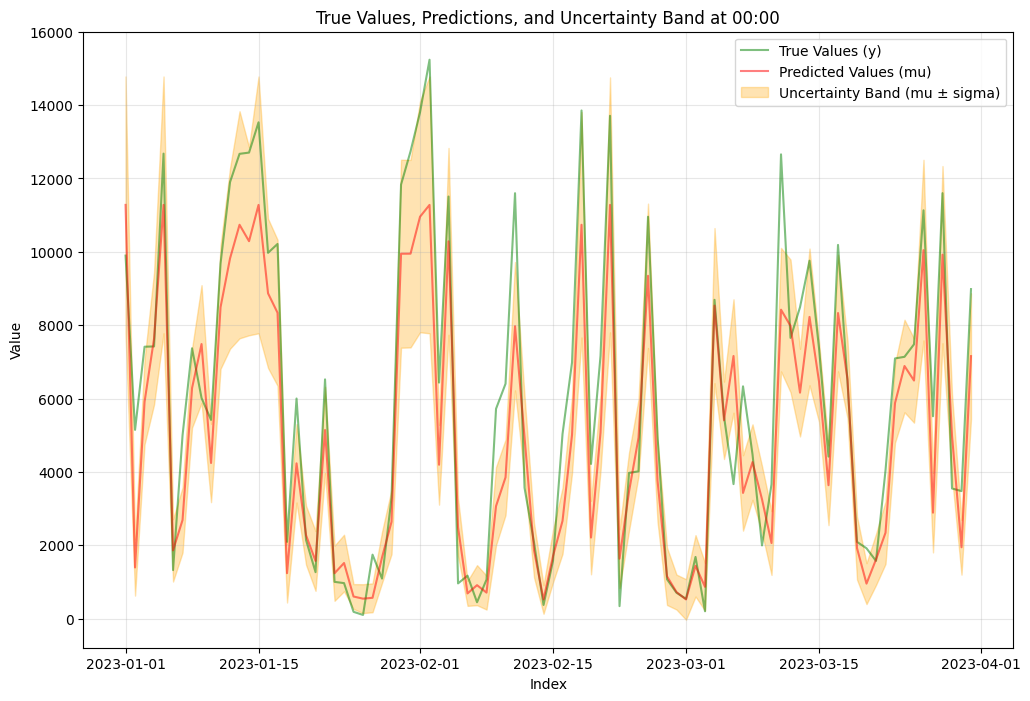

In [7]:
loc = [y.loc for y in y_val_dists]
scale = [y.scale for y in y_val_dists]


start = 0
end = 90
x = y_validation.index[start:end]
y = y_validation[start:end]
mu = y_val_pred[start:end]
sigma = [y.scale for y in y_val_dists][start:end]

# Plot
plt.figure(figsize=(12, 8))
plt.plot(x, y, label="True Values (y)", color="green", alpha=0.5)
plt.plot(x, mu, label="Predicted Values (mu)", color="red", alpha=0.5)
plt.fill_between(x, mu - sigma, mu + sigma, color="orange", alpha=0.3, label="Uncertainty Band (mu ± sigma)")

# Customize the plot
plt.xlabel("Index")
plt.ylabel("Value")
plt.title("True Values, Predictions, and Uncertainty Band at 00:00")
plt.legend()
plt.grid(alpha=0.3)

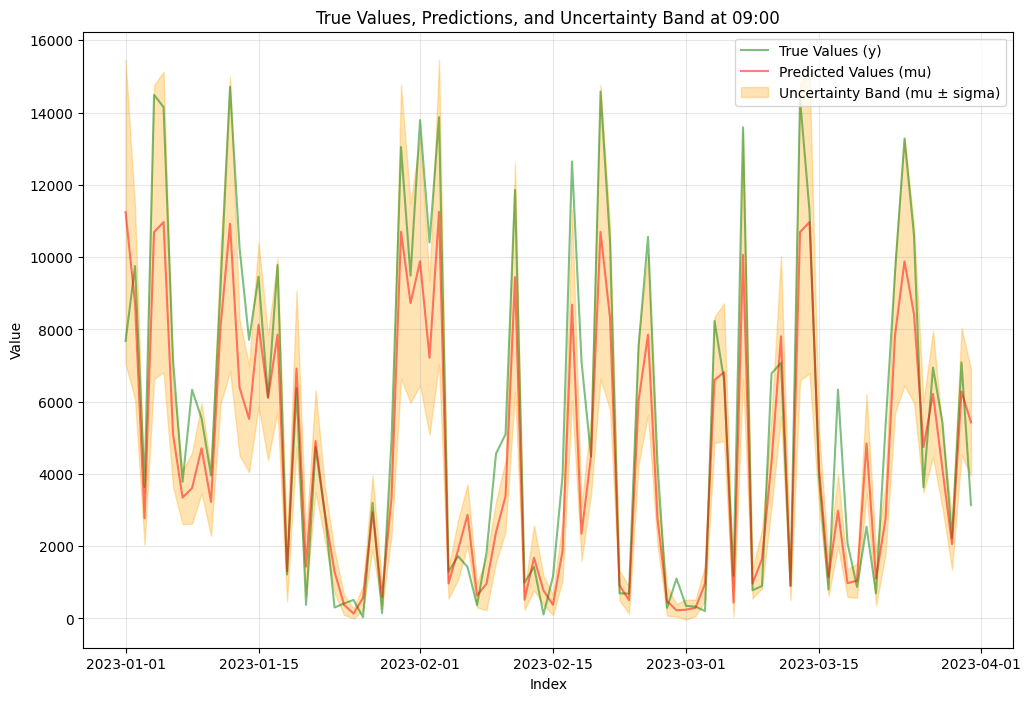

In [11]:
loc = [y.loc for y in y_val_dists]
scale = [y.scale for y in y_val_dists]


start = 0
end = 90
x = y_validation.index[start:end]
y = y_validation[start:end]
mu = y_val_pred[start:end]
sigma = [y.scale for y in y_val_dists][start:end]

# Plot
plt.figure(figsize=(12, 8))
plt.plot(x, y, label="True Values (y)", color="green", alpha=0.5)
plt.plot(x, mu, label="Predicted Values (mu)", color="red", alpha=0.5)
plt.fill_between(x, mu - sigma, mu + sigma, color="orange", alpha=0.3, label="Uncertainty Band (mu ± sigma)")

# Customize the plot
plt.xlabel("Index")
plt.ylabel("Value")
plt.title("True Values, Predictions, and Uncertainty Band at 09:00")
plt.legend()
plt.grid(alpha=0.3)

In [22]:
y_train_pred, y_train_dists, y_val_pred, y_val_dists, X_train, y_train, X_validation, y_validation = model_NGBoost("00:00", "only_mean_wind", 500, 0.03)

Data loaded and transformed successfully. Shape of DataFrame: (78912, 22)
# of training observations: 2556 | 77.76%
# of validation observations: 365 | 11.10%
# of test observations: 366 | 11.13%
[iter 0] loss=1735.1167 val_loss=2024.0642 scale=512.0000 norm=449.1209
[iter 1] loss=1726.2357 val_loss=2014.1590 scale=512.0000 norm=447.7525
[iter 2] loss=1717.4336 val_loss=2004.3367 scale=512.0000 norm=446.3911
[iter 3] loss=1708.7099 val_loss=1994.6216 scale=512.0000 norm=445.0350
[iter 4] loss=1700.0636 val_loss=1984.9876 scale=512.0000 norm=443.6878
[iter 5] loss=1691.4936 val_loss=1975.4310 scale=512.0000 norm=442.3483
[iter 6] loss=1682.9951 val_loss=1965.9548 scale=512.0000 norm=441.0148
[iter 7] loss=1674.5718 val_loss=1956.5474 scale=512.0000 norm=439.6935
[iter 8] loss=1666.2326 val_loss=1947.2308 scale=512.0000 norm=438.3813
[iter 9] loss=1657.9570 val_loss=1937.9928 scale=512.0000 norm=437.0803
[iter 10] loss=1649.7545 val_loss=1928.8387 scale=512.0000 norm=435.7857
[iter 11] l

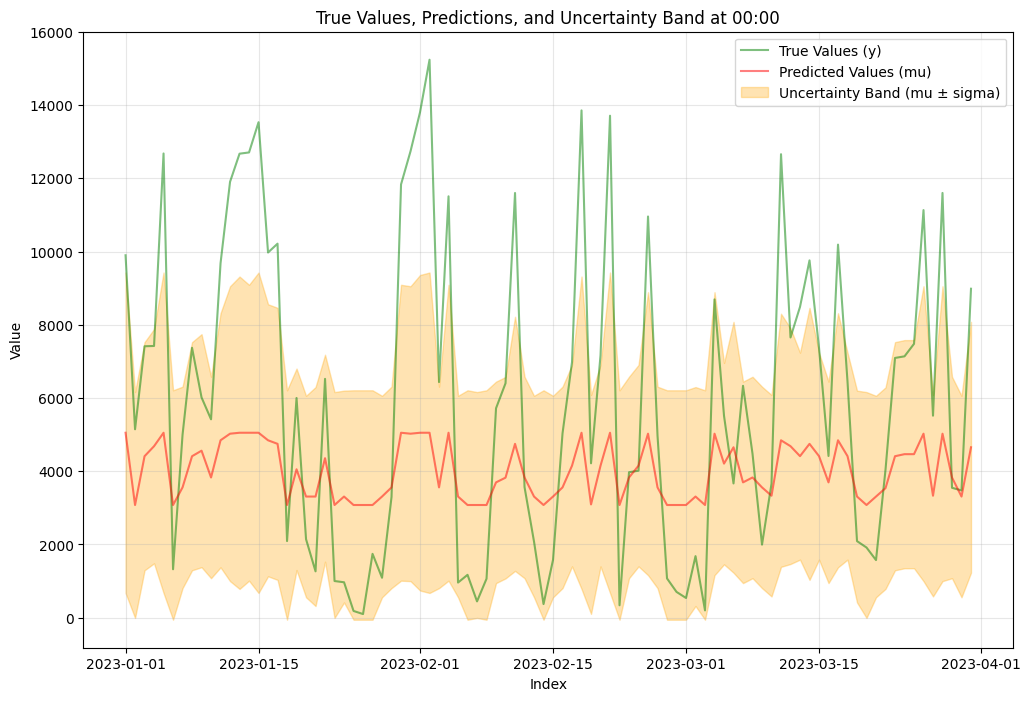

In [13]:
loc = [y.loc for y in y_val_dists]
scale = [y.scale for y in y_val_dists]


start = 0
end = 90
x = y_validation.index[start:end]
y = y_validation[start:end]
mu = y_val_pred[start:end]
sigma = [y.scale for y in y_val_dists][start:end]

# Plot
plt.figure(figsize=(12, 8))
plt.plot(x, y, label="True Values (y)", color="green", alpha=0.5)
plt.plot(x, mu, label="Predicted Values (mu)", color="red", alpha=0.5)
plt.fill_between(x, mu - sigma, mu + sigma, color="orange", alpha=0.3, label="Uncertainty Band (mu ± sigma)")

# Customize the plot
plt.xlabel("Index")
plt.ylabel("Value")
plt.title("True Values, Predictions, and Uncertainty Band at 00:00")
plt.legend()
plt.grid(alpha=0.3)

In [ ]:
y_train_pred, y_train_dists, y_val_pred, y_val_dists, X_train, y_train, X_validation, y_validation = model_NGBoost("00:00", "only_sin_cos", 500, 0.03)

Data loaded and transformed successfully. Shape of DataFrame: (78912, 22)
# of training observations: 2556 | 77.76%
# of validation observations: 365 | 11.10%
# of test observations: 366 | 11.13%
[iter 0] loss=1735.1167 val_loss=2031.2286 scale=512.0000 norm=449.1209
[iter 1] loss=1732.2106 val_loss=2028.4321 scale=512.0000 norm=448.6991
[iter 2] loss=1729.3304 val_loss=2025.6629 scale=512.0000 norm=448.2816
[iter 3] loss=1726.4760 val_loss=2022.7962 scale=512.0000 norm=447.8673
[iter 4] loss=1723.6472 val_loss=2019.8208 scale=512.0000 norm=447.4532
[iter 5] loss=1720.8391 val_loss=2017.1335 scale=512.0000 norm=447.0406
[iter 6] loss=1718.0600 val_loss=2014.4677 scale=512.0000 norm=446.6392
[iter 7] loss=1715.3050 val_loss=2011.6174 scale=512.0000 norm=446.2480
[iter 8] loss=1712.5692 val_loss=2008.9814 scale=512.0000 norm=445.8547
[iter 9] loss=1709.8618 val_loss=2006.1849 scale=512.0000 norm=445.4731
[iter 10] loss=1707.1729 val_loss=2003.5990 scale=512.0000 norm=445.0981
[iter 11] l

In [ ]:
pd.DataFrame({'y': y_validation,'mu': y_val_pred, "sigma": [y.scale for y in y_val_dists]})

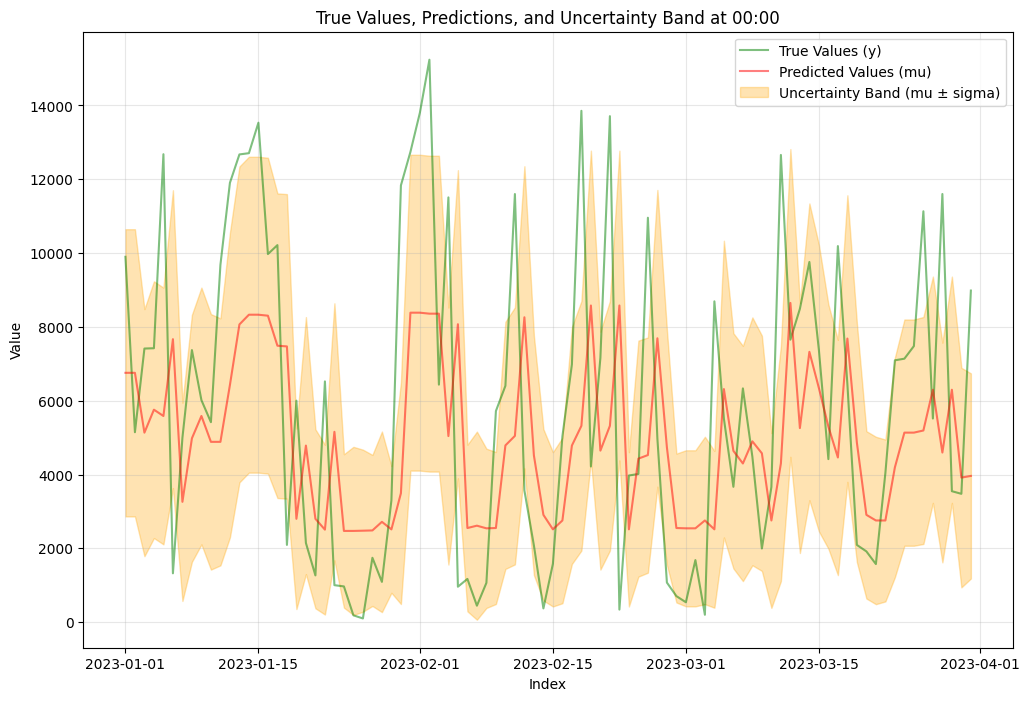

In [13]:
loc = [y.loc for y in y_val_dists]
scale = [y.scale for y in y_val_dists]


start = 0
end = 90
x = y_validation.index[start:end]
y = y_validation[start:end]
mu = y_val_pred[start:end]
sigma = [y.scale for y in y_val_dists][start:end]

# Plot
plt.figure(figsize=(12, 8))
plt.plot(x, y, label="True Values (y)", color="green", alpha=0.5)
plt.plot(x, mu, label="Predicted Values (mu)", color="red", alpha=0.5)
plt.fill_between(x, mu - sigma, mu + sigma, color="orange", alpha=0.3, label="Uncertainty Band (mu ± sigma)")

# Customize the plot
plt.xlabel("Index")
plt.ylabel("Value")
plt.title("True Values, Predictions, and Uncertainty Band at 00:00")
plt.legend()
plt.grid(alpha=0.3)

In [14]:
y_train_pred, y_train_dists, y_val_pred, y_val_dists, X_train, y_train, X_validation, y_validation = model_NGBoost("09:00", "only_sin_cos", 500, 0.03)

Data loaded and transformed successfully. Shape of DataFrame: (78912, 22)
# of training observations: 2556 | 77.76%
# of validation observations: 365 | 11.10%
# of test observations: 366 | 11.13%
[iter 0] loss=1863.8893 val_loss=2205.7729 scale=512.0000 norm=451.8419
[iter 1] loss=1861.0479 val_loss=2202.6366 scale=512.0000 norm=451.4320
[iter 2] loss=1858.2150 val_loss=2199.5267 scale=512.0000 norm=451.0259
[iter 3] loss=1855.4044 val_loss=2196.4162 scale=512.0000 norm=450.6224
[iter 4] loss=1852.6169 val_loss=2193.3318 scale=512.0000 norm=450.2223
[iter 5] loss=1849.8511 val_loss=2190.2732 scale=512.0000 norm=449.8251
[iter 6] loss=1847.1068 val_loss=2187.2402 scale=512.0000 norm=449.4310
[iter 7] loss=1844.3839 val_loss=2184.2190 scale=512.0000 norm=449.0397
[iter 8] loss=1841.6663 val_loss=2181.2231 scale=512.0000 norm=448.6424
[iter 9] loss=1838.9699 val_loss=2178.2359 scale=512.0000 norm=448.2503
[iter 10] loss=1836.2947 val_loss=2175.2791 scale=512.0000 norm=447.8620
[iter 11] l

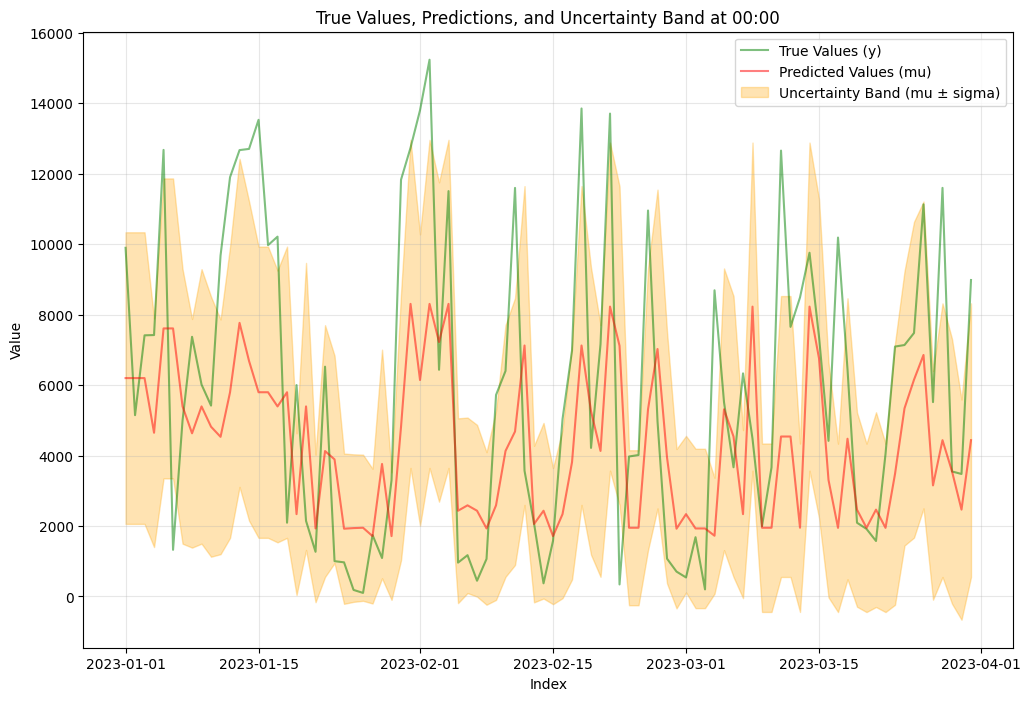

In [15]:
loc = [y.loc for y in y_val_dists]
scale = [y.scale for y in y_val_dists]


start = 0
end = 90
x = y_validation.index[start:end]
y = y_validation[start:end]
mu = y_val_pred[start:end]
sigma = [y.scale for y in y_val_dists][start:end]

# Plot
plt.figure(figsize=(12, 8))
plt.plot(x, y, label="True Values (y)", color="green", alpha=0.5)
plt.plot(x, mu, label="Predicted Values (mu)", color="red", alpha=0.5)
plt.fill_between(x, mu - sigma, mu + sigma, color="orange", alpha=0.3, label="Uncertainty Band (mu ± sigma)")

# Customize the plot
plt.xlabel("Index")
plt.ylabel("Value")
plt.title("True Values, Predictions, and Uncertainty Band at 00:00")
plt.legend()
plt.grid(alpha=0.3)

In [108]:
y_train_pred, y_train_dists, y_val_pred, y_val_dists, X_train, y_train, X_validation, y_validation = model_NGBoost("00:00", "only_power", 500, 0.03, Normal)

Data loaded and transformed successfully. Shape of DataFrame: (78912, 22)
# of training observations: 2556 | 77.76%
# of validation observations: 365 | 11.10%
# of test observations: 366 | 11.13%
[iter 0] loss=1735.1167 val_loss=2031.2852 scale=512.0000 norm=449.1209
[iter 1] loss=1732.4641 val_loss=2028.5461 scale=512.0000 norm=448.7341
[iter 2] loss=1729.8357 val_loss=2025.8349 scale=512.0000 norm=448.3507
[iter 3] loss=1727.2315 val_loss=2023.1516 scale=512.0000 norm=447.9707
[iter 4] loss=1724.6512 val_loss=2020.4957 scale=512.0000 norm=447.5936
[iter 5] loss=1722.0945 val_loss=2017.8670 scale=512.0000 norm=447.2200
[iter 6] loss=1719.5612 val_loss=2015.2652 scale=512.0000 norm=446.8515
[iter 7] loss=1717.0512 val_loss=2012.6901 scale=512.0000 norm=446.4864
[iter 8] loss=1714.5641 val_loss=2010.1330 scale=512.0000 norm=446.1250
[iter 9] loss=1712.1012 val_loss=2007.6101 scale=512.0000 norm=445.7736
[iter 10] loss=1709.6593 val_loss=2005.1130 scale=512.0000 norm=445.4234
[iter 11] l

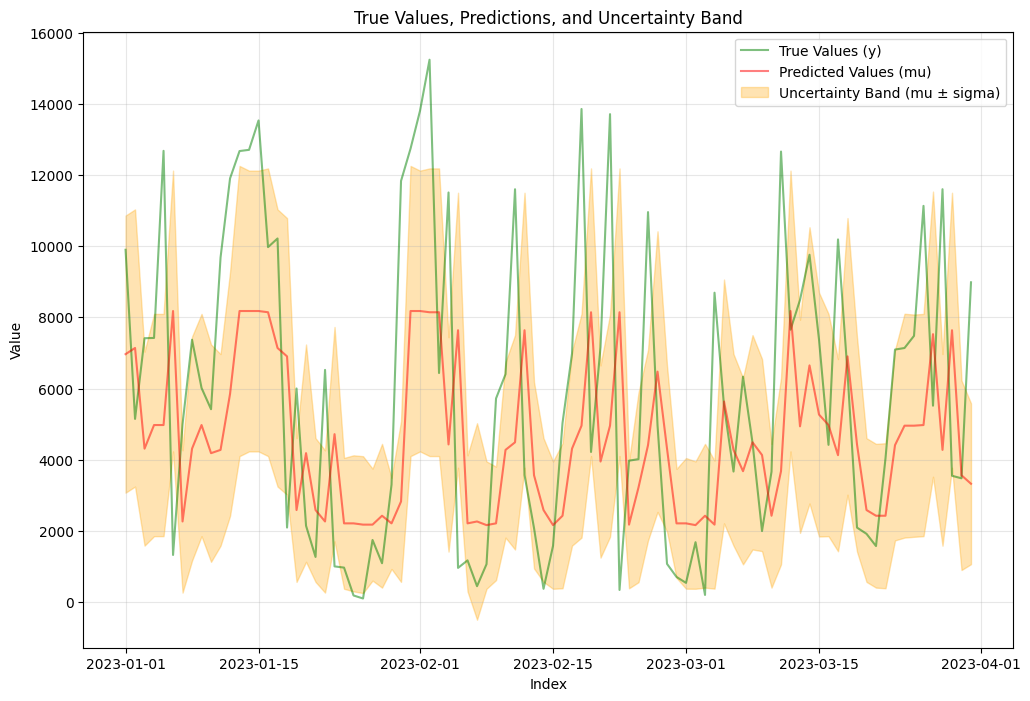

In [109]:
visualize_predictions_with_uncertainty(y_validation, y_val_pred, y_val_dists, Normal)

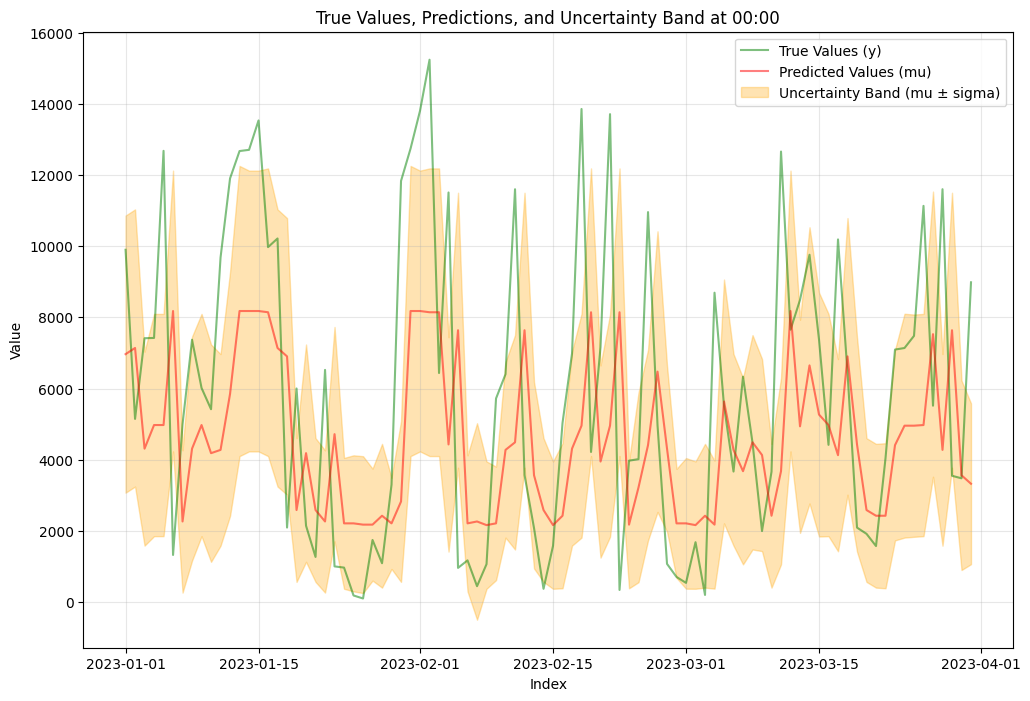

In [4]:
loc = [y.loc for y in y_val_dists]
scale = [y.scale for y in y_val_dists]


start = 0
end = 90
x = y_validation.index[start:end]
y = y_validation[start:end]
mu = y_val_pred[start:end]
sigma = [y.scale for y in y_val_dists][start:end]

# Plot
plt.figure(figsize=(12, 8))
plt.plot(x, y, label="True Values (y)", color="green", alpha=0.5)
plt.plot(x, mu, label="Predicted Values (mu)", color="red", alpha=0.5)
plt.fill_between(x, mu - sigma, mu + sigma, color="orange", alpha=0.3, label="Uncertainty Band (mu ± sigma)")

# Customize the plot
plt.xlabel("Index")
plt.ylabel("Value")
plt.title("True Values, Predictions, and Uncertainty Band at 00:00")
plt.legend()
plt.grid(alpha=0.3)

In [20]:
y_train_pred, y_train_dists, y_val_pred, y_val_dists, X_train, y_train, X_validation, y_validation = model_NGBoost("00:00", "all_wind_speeds", 500, 0.03)

Data loaded and transformed successfully. Shape of DataFrame: (78912, 22)
# of training observations: 2556 | 77.76%
# of validation observations: 365 | 11.10%
# of test observations: 366 | 11.13%
[iter 0] loss=1735.1167 val_loss=2023.8149 scale=512.0000 norm=449.1209
[iter 1] loss=1725.9458 val_loss=2013.6660 scale=512.0000 norm=447.7238
[iter 2] loss=1716.8540 val_loss=2003.6300 scale=512.0000 norm=446.3334
[iter 3] loss=1707.7791 val_loss=1993.4909 scale=512.0000 norm=444.9226
[iter 4] loss=1698.8111 val_loss=1983.5033 scale=512.0000 norm=443.5255
[iter 5] loss=1689.8595 val_loss=1973.5589 scale=512.0000 norm=442.1124
[iter 6] loss=1681.0070 val_loss=1963.6665 scale=512.0000 norm=440.7159
[iter 7] loss=1672.2221 val_loss=1953.7931 scale=512.0000 norm=439.3017
[iter 8] loss=1663.5443 val_loss=1944.0916 scale=512.0000 norm=437.9313
[iter 9] loss=1654.8987 val_loss=1934.4053 scale=512.0000 norm=436.5189
[iter 10] loss=1646.3024 val_loss=1924.7534 scale=512.0000 norm=435.1336
[iter 11] l

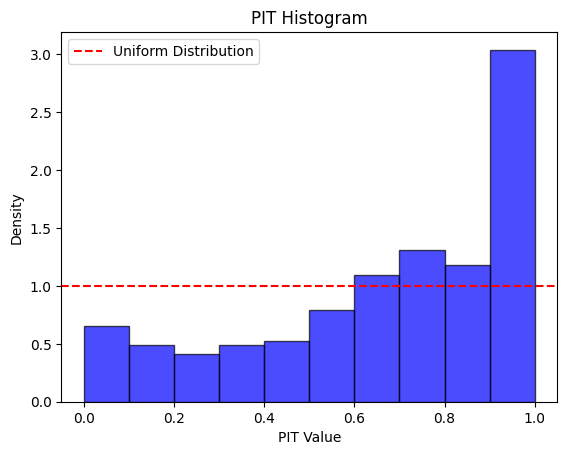

In [21]:
pit_values = norm.cdf(y_validation, loc=y_val_pred, scale=[y.scale for y in y_val_dists])
plt.hist(pit_values, bins=10, range=(0, 1), density=True, alpha=0.7, color='blue', edgecolor='black')
plt.axhline(1, color='red', linestyle='--', label='Uniform Distribution')
plt.title('PIT Histogram')
plt.xlabel('PIT Value')
plt.ylabel('Density')
plt.legend()
plt.show()

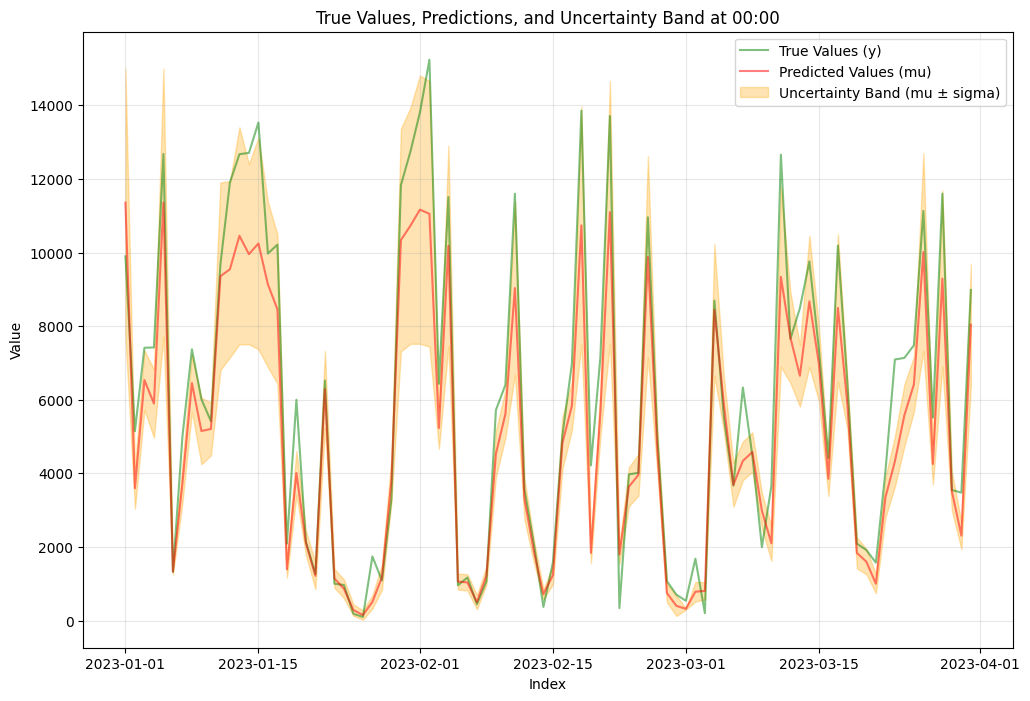

In [4]:
loc = [y.loc for y in y_val_dists]
scale = [y.scale for y in y_val_dists]


start = 0
end = 90
x = y_validation.index[start:end]
y = y_validation[start:end]
mu = y_val_pred[start:end]
sigma = [y.scale for y in y_val_dists][start:end]

# Plot
plt.figure(figsize=(12, 8))
plt.plot(x, y, label="True Values (y)", color="green", alpha=0.5)
plt.plot(x, mu, label="Predicted Values (mu)", color="red", alpha=0.5)
plt.fill_between(x, mu - sigma, mu + sigma, color="orange", alpha=0.3, label="Uncertainty Band (mu ± sigma)")

# Customize the plot
plt.xlabel("Index")
plt.ylabel("Value")
plt.title("True Values, Predictions, and Uncertainty Band at 00:00")
plt.legend()
plt.grid(alpha=0.3)

In [19]:
y_train_pred, y_train_dists, y_val_pred, y_val_dists, X_train, y_train, X_validation, y_validation = model_NGBoost("00:00", "max", 500, 0.03)

Data loaded and transformed successfully. Shape of DataFrame: (78912, 22)
# of training observations: 2556 | 77.76%
# of validation observations: 365 | 11.10%
# of test observations: 366 | 11.13%
[iter 0] loss=1735.1167 val_loss=2023.8149 scale=512.0000 norm=449.1209
[iter 1] loss=1725.9458 val_loss=2013.6660 scale=512.0000 norm=447.7238
[iter 2] loss=1716.8540 val_loss=2003.6300 scale=512.0000 norm=446.3334
[iter 3] loss=1707.7791 val_loss=1993.4909 scale=512.0000 norm=444.9226
[iter 4] loss=1698.8111 val_loss=1983.5033 scale=512.0000 norm=443.5255
[iter 5] loss=1689.8595 val_loss=1973.5589 scale=512.0000 norm=442.1124
[iter 6] loss=1681.0070 val_loss=1963.6665 scale=512.0000 norm=440.7159
[iter 7] loss=1672.2221 val_loss=1953.7931 scale=512.0000 norm=439.3017
[iter 8] loss=1663.5443 val_loss=1944.0916 scale=512.0000 norm=437.9313
[iter 9] loss=1654.8987 val_loss=1934.4053 scale=512.0000 norm=436.5189
[iter 10] loss=1646.3024 val_loss=1924.7534 scale=512.0000 norm=435.1336
[iter 11] l

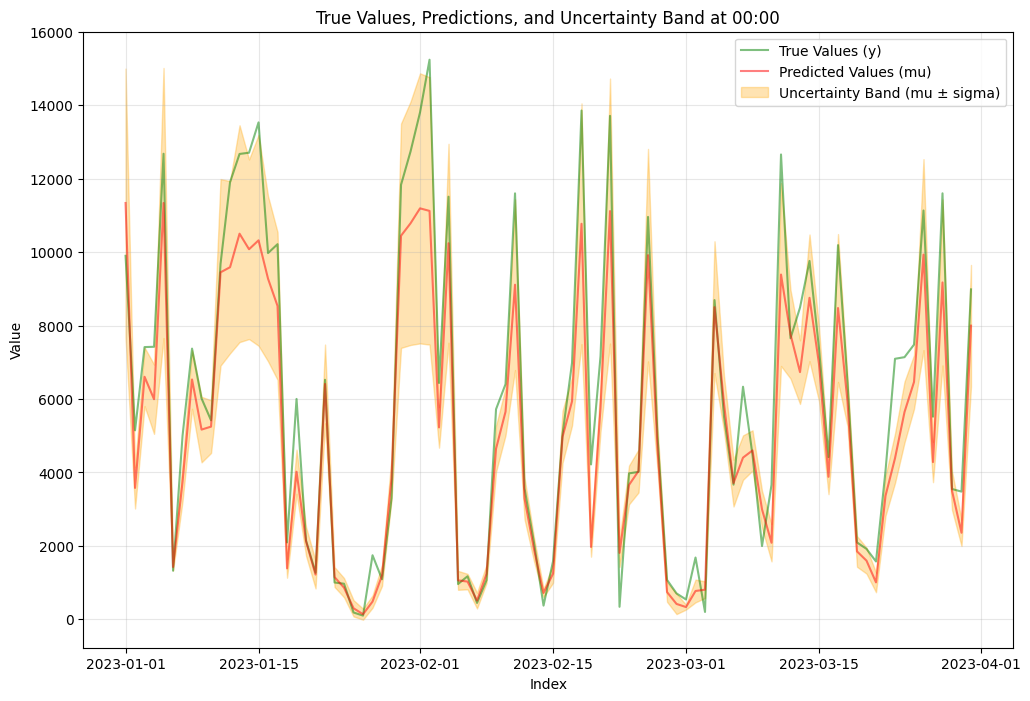

In [20]:
loc = [y.loc for y in y_val_dists]
scale = [y.scale for y in y_val_dists]


start = 0
end = 90
x = y_validation.index[start:end]
y = y_validation[start:end]
mu = y_val_pred[start:end]
sigma = [y.scale for y in y_val_dists][start:end]

# Plot
plt.figure(figsize=(12, 8))
plt.plot(x, y, label="True Values (y)", color="green", alpha=0.5)
plt.plot(x, mu, label="Predicted Values (mu)", color="red", alpha=0.5)
plt.fill_between(x, mu - sigma, mu + sigma, color="orange", alpha=0.3, label="Uncertainty Band (mu ± sigma)")

# Customize the plot
plt.xlabel("Index")
plt.ylabel("Value")
plt.title("True Values, Predictions, and Uncertainty Band at 00:00")
plt.legend()
plt.grid(alpha=0.3)

### 09:00

In [ ]:
y_train_pred, y_train_dists, y_val_pred, y_val_dists, X_train, y_train, X_validation, y_validation = model_NGBoost("09:00", "only_power", 500, 0.03, seed=42)

Data loaded and transformed successfully. Shape of DataFrame: (78912, 22)
# of training observations: 2556 | 77.76%
# of validation observations: 365 | 11.10%
# of test observations: 366 | 11.13%
[iter 0] loss=1863.8893 val_loss=2206.0406 scale=512.0000 norm=451.8419
[iter 1] loss=1861.2794 val_loss=2203.1369 scale=512.0000 norm=451.4672
[iter 2] loss=1858.6903 val_loss=2200.1985 scale=512.0000 norm=451.0951
[iter 3] loss=1856.1044 val_loss=2197.2853 scale=512.0000 norm=450.7209
[iter 4] loss=1853.5391 val_loss=2194.4224 scale=512.0000 norm=450.3488
[iter 5] loss=1851.0072 val_loss=2191.5577 scale=512.0000 norm=449.9827
[iter 6] loss=1848.4825 val_loss=2188.7177 scale=512.0000 norm=449.6161
[iter 7] loss=1845.9777 val_loss=2185.9021 scale=512.0000 norm=449.2535
[iter 8] loss=1843.4928 val_loss=2183.1108 scale=512.0000 norm=448.8954
[iter 9] loss=1841.0276 val_loss=2180.3677 scale=512.0000 norm=448.5399
[iter 10] loss=1838.5942 val_loss=2177.6242 scale=512.0000 norm=448.1930
[iter 11] l

In [16]:
y_train_pred, y_train_dists, y_val_pred, y_val_dists, X_train, y_train, X_validation, y_validation = model_NGBoost("09:00", "only_sin_cos", 500, 0.03, seed=42)

Data loaded and transformed successfully. Shape of DataFrame: (78912, 22)
# of training observations: 2556 | 77.76%
# of validation observations: 365 | 11.10%
# of test observations: 366 | 11.13%
[iter 0] loss=1863.8893 val_loss=2205.7729 scale=512.0000 norm=451.8419
[iter 1] loss=1861.0479 val_loss=2202.6366 scale=512.0000 norm=451.4320
[iter 2] loss=1858.2150 val_loss=2199.5267 scale=512.0000 norm=451.0259
[iter 3] loss=1855.4044 val_loss=2196.4162 scale=512.0000 norm=450.6224
[iter 4] loss=1852.6169 val_loss=2193.3318 scale=512.0000 norm=450.2223
[iter 5] loss=1849.8511 val_loss=2190.2732 scale=512.0000 norm=449.8251
[iter 6] loss=1847.1068 val_loss=2187.2402 scale=512.0000 norm=449.4310
[iter 7] loss=1844.3839 val_loss=2184.2190 scale=512.0000 norm=449.0397
[iter 8] loss=1841.6663 val_loss=2181.2231 scale=512.0000 norm=448.6424
[iter 9] loss=1838.9699 val_loss=2178.2359 scale=512.0000 norm=448.2503
[iter 10] loss=1836.2947 val_loss=2175.2791 scale=512.0000 norm=447.8620
[iter 11] l

In [ ]:
y_train_pred, y_train_dists, y_val_pred, y_val_dists, X_train, y_train, X_validation, y_validation = model_NGBoost("09:00", "only_mean_wind", 500, 0.03)

Data loaded and transformed successfully. Shape of DataFrame: (78912, 22)
# of training observations: 2556 | 77.76%
# of validation observations: 365 | 11.10%
# of test observations: 366 | 11.13%
[iter 0] loss=1863.8893 val_loss=2198.5383 scale=512.0000 norm=451.8419
[iter 1] loss=1854.6935 val_loss=2188.1884 scale=512.0000 norm=450.4454
[iter 2] loss=1845.5706 val_loss=2177.9160 scale=512.0000 norm=449.0536
[iter 3] loss=1836.5199 val_loss=2167.7237 scale=512.0000 norm=447.6690
[iter 4] loss=1827.5409 val_loss=2157.6075 scale=512.0000 norm=446.2891
[iter 5] loss=1818.6330 val_loss=2147.5732 scale=512.0000 norm=444.9145
[iter 6] loss=1809.7954 val_loss=2137.6138 scale=512.0000 norm=443.5444
[iter 7] loss=1801.0274 val_loss=2127.7508 scale=512.0000 norm=442.1794
[iter 8] loss=1792.3283 val_loss=2117.9700 scale=512.0000 norm=440.8252
[iter 9] loss=1783.6976 val_loss=2108.2690 scale=512.0000 norm=439.4795
[iter 10] loss=1775.1348 val_loss=2098.6382 scale=512.0000 norm=438.1406
[iter 11] l

In [24]:
y_train_pred, y_train_dists, y_val_pred, y_val_dists, X_train, y_train, X_validation, y_validation = model_NGBoost("09:00", "all_wind_speeds", 500, 0.03)

Data loaded and transformed successfully. Shape of DataFrame: (78912, 22)
# of training observations: 2556 | 77.76%
# of validation observations: 365 | 11.10%
# of test observations: 366 | 11.13%
[iter 0] loss=1863.8893 val_loss=2198.2288 scale=512.0000 norm=451.8419
[iter 1] loss=1854.5974 val_loss=2187.5781 scale=512.0000 norm=450.4168
[iter 2] loss=1845.3773 val_loss=2176.9783 scale=512.0000 norm=448.9956
[iter 3] loss=1836.2285 val_loss=2166.5086 scale=512.0000 norm=447.5820
[iter 4] loss=1827.1501 val_loss=2156.0910 scale=512.0000 norm=446.1713
[iter 5] loss=1818.1417 val_loss=2145.7680 scale=512.0000 norm=444.7665
[iter 6] loss=1809.1827 val_loss=2135.5004 scale=512.0000 norm=443.3719
[iter 7] loss=1800.3105 val_loss=2125.3349 scale=512.0000 norm=441.9757
[iter 8] loss=1791.4868 val_loss=2115.2101 scale=512.0000 norm=440.5847
[iter 9] loss=1782.7488 val_loss=2105.2193 scale=512.0000 norm=439.2018
[iter 10] loss=1774.0588 val_loss=2095.3850 scale=512.0000 norm=437.8301
[iter 11] l

c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2


[iter 496] loss=390.5155 val_loss=578.0206 scale=0.0156 norm=0.0154
[iter 497] loss=390.5155 val_loss=578.0206 scale=0.0156 norm=0.0152
[iter 498] loss=390.5155 val_loss=578.0206 scale=0.0312 norm=0.0301
[iter 499] loss=390.5154 val_loss=578.0205 scale=0.0312 norm=0.0295
Training features: ['power_t-1', 'ws_10m_loc_1', 'ws_10m_loc_10', 'ws_10m_loc_2', 'ws_10m_loc_3', 'ws_10m_loc_4', 'ws_10m_loc_5', 'ws_10m_loc_6', 'ws_10m_loc_7', 'ws_10m_loc_8', 'ws_10m_loc_9', 'ws_10m_loc_mean', 'ws_100m_loc_1', 'ws_100m_loc_10', 'ws_100m_loc_2', 'ws_100m_loc_3', 'ws_100m_loc_4', 'ws_100m_loc_5', 'ws_100m_loc_6', 'ws_100m_loc_7', 'ws_100m_loc_8', 'ws_100m_loc_9', 'ws_100m_loc_mean'] -> power
Train MSE:	 768743.077810872
Validation MSE:	 1675938.9762903443


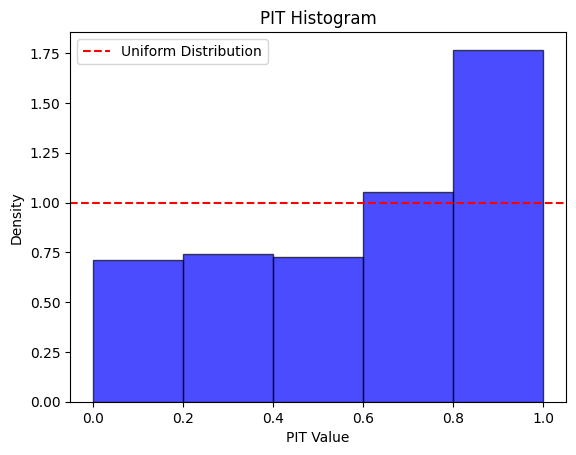

In [ ]:
pit_values = norm.cdf(y_validation, loc=y_val_pred, scale=[y.scale for y in y_val_dists])
plt.hist(pit_values, bins=5, range=(0, 1), density=True, alpha=0.7, color='blue', edgecolor='black')
plt.axhline(1, color='red', linestyle='--', label='Uniform Distribution')
plt.title('PIT Histogram')
plt.xlabel('PIT Value')
plt.ylabel('Density')
plt.legend()
plt.show()

In [21]:
y_train_pred, y_train_dists, y_val_pred, y_val_dists, X_train, y_train, X_validation, y_validation = model_NGBoost("09:00", "max", 500, 0.03, seed=42)

Data loaded and transformed successfully. Shape of DataFrame: (78912, 22)
# of training observations: 2556 | 77.76%
# of validation observations: 365 | 11.10%
# of test observations: 366 | 11.13%
[iter 0] loss=1863.8893 val_loss=2198.2288 scale=512.0000 norm=451.8419
[iter 1] loss=1854.5974 val_loss=2187.5781 scale=512.0000 norm=450.4168
[iter 2] loss=1845.3773 val_loss=2176.9783 scale=512.0000 norm=448.9956
[iter 3] loss=1836.2285 val_loss=2166.5086 scale=512.0000 norm=447.5820
[iter 4] loss=1827.1501 val_loss=2156.0910 scale=512.0000 norm=446.1713
[iter 5] loss=1818.1417 val_loss=2145.7680 scale=512.0000 norm=444.7665
[iter 6] loss=1809.1827 val_loss=2135.5004 scale=512.0000 norm=443.3719
[iter 7] loss=1800.3105 val_loss=2125.3349 scale=512.0000 norm=441.9757
[iter 8] loss=1791.4868 val_loss=2115.2101 scale=512.0000 norm=440.5847
[iter 9] loss=1782.7488 val_loss=2105.2193 scale=512.0000 norm=439.2018
[iter 10] loss=1774.0588 val_loss=2095.3850 scale=512.0000 norm=437.8301
[iter 11] l

In [22]:
y_train_pred, y_train_dists, y_val_pred, y_val_dists, X_train, y_train, X_validation, y_validation = model_NGBoost("09:00", "only_mean_wind", 500, 0.03, seed=42, natural_gradient=False)

Data loaded and transformed successfully. Shape of DataFrame: (78912, 22)
# of training observations: 2556 | 77.76%
# of validation observations: 365 | 11.10%
# of test observations: 366 | 11.13%
[iter 0] loss=1863.8893 val_loss=2196.4493 scale=0.0010 norm=0.5033
[iter 1] loss=1853.4880 val_loss=2183.7663 scale=0.0010 norm=0.4986
[iter 2] loss=1843.1047 val_loss=2170.9662 scale=0.0010 norm=0.4938
[iter 3] loss=1832.7628 val_loss=2158.2632 scale=0.0010 norm=0.4888
[iter 4] loss=1822.4953 val_loss=2145.4220 scale=0.0010 norm=0.4834
[iter 5] loss=1812.3585 val_loss=2139.1259 scale=0.0005 norm=0.2388
[iter 6] loss=1807.3709 val_loss=2132.8651 scale=0.0005 norm=0.2374
[iter 7] loss=1802.4501 val_loss=2126.6310 scale=0.0005 norm=0.2358
[iter 8] loss=1797.5204 val_loss=2120.4824 scale=0.0005 norm=0.2342


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow

[iter 9] loss=1792.6749 val_loss=2114.3998 scale=0.0005 norm=0.2324
[iter 10] loss=1787.9250 val_loss=2108.4052 scale=0.0005 norm=0.2306
[iter 11] loss=1783.2792 val_loss=2102.5066 scale=0.0005 norm=0.2287
[iter 12] loss=1778.8112 val_loss=2096.7465 scale=0.0005 norm=0.2267
[iter 13] loss=1774.3995 val_loss=2091.1402 scale=0.0005 norm=0.2247
[iter 14] loss=1770.1249 val_loss=2085.7176 scale=0.0005 norm=0.2226
[iter 15] loss=1765.9867 val_loss=2080.4440 scale=0.0005 norm=0.2204
[iter 16] loss=1761.9954 val_loss=2075.4143 scale=0.0005 norm=0.2182
[iter 17] loss=1758.1501 val_loss=2070.4568 scale=0.0005 norm=0.2160
[iter 18] loss=1754.4609 val_loss=2065.6762 scale=0.0005 norm=0.2137
[iter 19] loss=1750.9316 val_loss=2061.1944 scale=0.0005 norm=0.2114


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered i

[iter 20] loss=1747.5404 val_loss=2056.8189 scale=0.0005 norm=0.2091
[iter 21] loss=1744.3104 val_loss=2052.7386 scale=0.0005 norm=0.2067
[iter 22] loss=1741.2399 val_loss=2048.6640 scale=0.0005 norm=0.2044
[iter 23] loss=1738.3250 val_loss=2044.8786 scale=0.0005 norm=0.2021
[iter 24] loss=1735.5503 val_loss=2041.3732 scale=0.0005 norm=0.1998
[iter 25] loss=1732.9275 val_loss=2038.0184 scale=0.0005 norm=0.1976
[iter 26] loss=1730.4366 val_loss=2034.7944 scale=0.0005 norm=0.1953
[iter 27] loss=1728.0853 val_loss=2031.7150 scale=0.0005 norm=0.1932
[iter 28] loss=1725.8217 val_loss=2028.8002 scale=0.0005 norm=0.1910
[iter 29] loss=1723.6857 val_loss=2026.0558 scale=0.0005 norm=0.1889
[iter 30] loss=1721.6702 val_loss=2023.2815 scale=0.0005 norm=0.1870
[iter 31] loss=1719.7669 val_loss=2020.8375 scale=0.0005 norm=0.1851


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered i

[iter 32] loss=1717.9684 val_loss=2018.3252 scale=0.0005 norm=0.1833
[iter 33] loss=1716.2703 val_loss=2016.0858 scale=0.0005 norm=0.1816
[iter 34] loss=1714.6522 val_loss=2013.9359 scale=0.0005 norm=0.1799
[iter 35] loss=1713.1231 val_loss=2011.8854 scale=0.0005 norm=0.1783
[iter 36] loss=1711.6675 val_loss=2009.9553 scale=0.0005 norm=0.1768
[iter 37] loss=1710.2917 val_loss=2008.2014 scale=0.0005 norm=0.1754
[iter 38] loss=1708.9878 val_loss=2006.4667 scale=0.0005 norm=0.1740
[iter 39] loss=1707.7524 val_loss=2004.9250 scale=0.0005 norm=0.1727


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered i

[iter 40] loss=1706.5805 val_loss=2001.6414 scale=0.0010 norm=0.3428
[iter 41] loss=1704.3201 val_loss=1998.7108 scale=0.0010 norm=0.3380
[iter 42] loss=1702.2815 val_loss=1995.8727 scale=0.0010 norm=0.3336
[iter 43] loss=1700.4001 val_loss=1993.2729 scale=0.0010 norm=0.3294
[iter 44] loss=1698.6822 val_loss=1991.0699 scale=0.0010 norm=0.3255


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: divide by zero encountered in divide
  Z = (Y - self.loc) / self.scale
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:30: RuntimeWarning: invalid value encountered in multiply
  return self.scale * (
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarnin

[iter 45] loss=1697.1221 val_loss=1989.2841 scale=0.0010 norm=0.3219
[iter 46] loss=1695.6842 val_loss=1987.5509 scale=0.0010 norm=0.3187
[iter 47] loss=1694.3592 val_loss=1985.8065 scale=0.0010 norm=0.3158
[iter 48] loss=1693.1141 val_loss=1984.3358 scale=0.0010 norm=0.3131
[iter 49] loss=1691.9561 val_loss=1982.9757 scale=0.0010 norm=0.3107
[iter 50] loss=1690.8793 val_loss=1981.7035 scale=0.0010 norm=0.3086
[iter 51] loss=1689.8442 val_loss=1980.5704 scale=0.0010 norm=0.3065
[iter 52] loss=1688.8700 val_loss=1979.5252 scale=0.0010 norm=0.3047
[iter 53] loss=1688.0001 val_loss=1978.4928 scale=0.0010 norm=0.3029
[iter 54] loss=1687.1416 val_loss=1976.8133 scale=0.0020 norm=0.6025
[iter 55] loss=1685.5324 val_loss=1976.0885 scale=0.0010 norm=0.2984
[iter 56] loss=1684.8066 val_loss=1975.4151 scale=0.0010 norm=0.2971


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: divide by zero encountered in divide
  Z = (Y - self.loc) / self.scale
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: Runt

[iter 57] loss=1684.0889 val_loss=1973.9552 scale=0.0020 norm=0.5917
[iter 58] loss=1682.7815 val_loss=1972.9530 scale=0.0020 norm=0.5869
[iter 59] loss=1681.6113 val_loss=1972.4431 scale=0.0010 norm=0.2915
[iter 60] loss=1681.0134 val_loss=1971.4945 scale=0.0020 norm=0.5811
[iter 61] loss=1679.9603 val_loss=1971.0394 scale=0.0010 norm=0.2890


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: divide by zero encountered in divide
  Z = (Y - self.loc) / self.scale
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:30: RuntimeWarning: invalid value encountered in multiply
  return self.scale * (
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_conti

[iter 62] loss=1679.4311 val_loss=1970.3262 scale=0.0020 norm=0.5763
[iter 63] loss=1678.4844 val_loss=1969.5108 scale=0.0020 norm=0.5734
[iter 64] loss=1677.5687 val_loss=1968.8442 scale=0.0020 norm=0.5703
[iter 65] loss=1676.7437 val_loss=1968.3181 scale=0.0020 norm=0.5679
[iter 66] loss=1675.9571 val_loss=1968.0603 scale=0.0010 norm=0.2826
[iter 67] loss=1675.5940 val_loss=1967.6105 scale=0.0020 norm=0.5641
[iter 68] loss=1674.8698 val_loss=1967.3012 scale=0.0020 norm=0.5618
[iter 69] loss=1674.2008 val_loss=1967.0414 scale=0.0020 norm=0.5596
[iter 70] loss=1673.5918 val_loss=1966.8453 scale=0.0020 norm=0.5576
[iter 71] loss=1673.0323 val_loss=1966.6692 scale=0.0020 norm=0.5557
[iter 72] loss=1672.5138 val_loss=1966.4410 scale=0.0020 norm=0.5540
[iter 73] loss=1672.0276 val_loss=1966.2607 scale=0.0020 norm=0.5524
[iter 74] loss=1671.5734 val_loss=1966.0916 scale=0.0020 norm=0.5509
[iter 75] loss=1671.1499 val_loss=1965.8568 scale=0.0020 norm=0.5494


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: divide by zero encountered in divide
  Z = (Y - self.loc) / self.scale
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:30: RuntimeWarning: invalid value encountered in multiply
  return self.scale * (
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow en

[iter 76] loss=1670.7309 val_loss=1965.6888 scale=0.0020 norm=0.5481
[iter 77] loss=1670.3431 val_loss=1965.6062 scale=0.0020 norm=0.5469
[iter 78] loss=1669.9926 val_loss=1965.3856 scale=0.0020 norm=0.5457
[iter 79] loss=1669.6423 val_loss=1965.2388 scale=0.0020 norm=0.5446
[iter 80] loss=1669.3140 val_loss=1965.1164 scale=0.0039 norm=1.0873
[iter 81] loss=1668.7079 val_loss=1965.1361 scale=0.0020 norm=0.5418
[iter 82] loss=1668.4463 val_loss=1965.0789 scale=0.0020 norm=0.5409
[iter 83] loss=1668.1922 val_loss=1964.9802 scale=0.0020 norm=0.5399
[iter 84] loss=1667.9522 val_loss=1964.6930 scale=0.0039 norm=1.0784


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: divide by zero encountered in divide
  Z = (Y - self.loc) / self.scale
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:30: RuntimeWarning: i

[iter 85] loss=1667.5091 val_loss=1964.7780 scale=0.0020 norm=0.5379
[iter 86] loss=1667.3061 val_loss=1964.5280 scale=0.0010 norm=0.2686
[iter 87] loss=1667.1447 val_loss=1964.5546 scale=0.0020 norm=0.5365
[iter 88] loss=1666.9645 val_loss=1964.3538 scale=0.0010 norm=0.2679
[iter 89] loss=1666.8210 val_loss=1964.1260 scale=0.0010 norm=0.2676


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: divide by zero encountered in divide
  Z = (Y - self.loc) / self.scale
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:30: RuntimeWarning: invalid value encountered in multiply
  return self.scale * (
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encounter

[iter 90] loss=1666.6869 val_loss=1963.9416 scale=0.0010 norm=0.2674
[iter 91] loss=1666.5535 val_loss=1963.9301 scale=0.0020 norm=0.5342
[iter 92] loss=1666.3846 val_loss=1963.8791 scale=0.0010 norm=0.2668
[iter 93] loss=1666.2798 val_loss=1963.6740 scale=0.0010 norm=0.2666
[iter 94] loss=1666.1609 val_loss=1963.5543 scale=0.0005 norm=0.1332


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: divide by zero encountered in divid

[iter 95] loss=1666.1003 val_loss=1963.5126 scale=0.0020 norm=0.5322
[iter 96] loss=1665.9610 val_loss=1963.4078 scale=0.0020 norm=0.5316
[iter 97] loss=1665.7908 val_loss=1963.3767 scale=0.0020 norm=0.5311
[iter 98] loss=1665.6258 val_loss=1963.3985 scale=0.0039 norm=1.0614
[iter 99] loss=1665.3177 val_loss=1963.3471 scale=0.0020 norm=0.5297
[iter 100] loss=1665.1792 val_loss=1963.3000 scale=0.0020 norm=0.5293
[iter 101] loss=1665.0529 val_loss=1963.3333 scale=0.0005 norm=0.1322
[iter 102] loss=1665.0061 val_loss=1963.2185 scale=0.0005 norm=0.1321
[iter 103] loss=1664.9547 val_loss=1963.1177 scale=0.0010 norm=0.2641
[iter 104] loss=1664.8961 val_loss=1963.1856 scale=0.0005 norm=0.1320
[iter 105] loss=1664.8140 val_loss=1963.2029 scale=0.0020 norm=0.5277
[iter 106] loss=1664.6816 val_loss=1963.1125 scale=0.0039 norm=1.0544
[iter 107] loss=1664.4438 val_loss=1963.1452 scale=0.0005 norm=0.1316
[iter 108] loss=1664.4022 val_loss=1963.0427 scale=0.0005 norm=0.1315
[iter 109] loss=1664.3576

c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: divide by zero encountered in divide
  Z = (Y - self.loc) / self.scale
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:30: RuntimeWarning: invalid value encountered in multiply
  return self.scale * (
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow

[iter 110] loss=1664.2576 val_loss=1962.8438 scale=0.0020 norm=0.5254
[iter 111] loss=1664.1285 val_loss=1962.8444 scale=0.0020 norm=0.5249
[iter 112] loss=1664.0193 val_loss=1962.8529 scale=0.0005 norm=0.1311
[iter 113] loss=1663.9825 val_loss=1962.9256 scale=0.0005 norm=0.1311
[iter 114] loss=1663.9070 val_loss=1962.8860 scale=0.0020 norm=0.5239
[iter 115] loss=1663.7886 val_loss=1962.8875 scale=0.0020 norm=0.5234
[iter 116] loss=1663.6943 val_loss=1962.7937 scale=0.0005 norm=0.1308


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: divide by zero encountered in di

[iter 117] loss=1663.6559 val_loss=1962.8876 scale=0.0005 norm=0.1307
[iter 118] loss=1663.5854 val_loss=1962.8728 scale=0.0020 norm=0.5226
[iter 119] loss=1663.4742 val_loss=1962.8620 scale=0.0020 norm=0.5221
[iter 120] loss=1663.3714 val_loss=1962.8262 scale=0.0020 norm=0.5217
[iter 121] loss=1663.2621 val_loss=1962.8335 scale=0.0005 norm=0.1303
[iter 122] loss=1663.2294 val_loss=1962.8269 scale=0.0020 norm=0.5209
[iter 123] loss=1663.1265 val_loss=1962.9059 scale=0.0005 norm=0.1301


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: divide by zero encountered in di

[iter 124] loss=1663.0600 val_loss=1962.8670 scale=0.0002 norm=0.0650
[iter 125] loss=1663.0427 val_loss=1962.8832 scale=0.0005 norm=0.1300
[iter 126] loss=1662.9949 val_loss=1962.9520 scale=0.0010 norm=0.2599
[iter 127] loss=1662.8720 val_loss=1962.9686 scale=0.0005 norm=0.1298
[iter 128] loss=1662.8277 val_loss=1962.9846 scale=0.0005 norm=0.1297
[iter 129] loss=1662.7863 val_loss=1963.0001 scale=0.0005 norm=0.1296
[iter 130] loss=1662.7476 val_loss=1963.0916 scale=0.0005 norm=0.1296


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scal

[iter 131] loss=1662.6917 val_loss=1963.1007 scale=0.0005 norm=0.1295
[iter 132] loss=1662.6601 val_loss=1963.1161 scale=0.0005 norm=0.1295
[iter 133] loss=1662.6241 val_loss=1963.0408 scale=0.0010 norm=0.2588
[iter 134] loss=1662.4972 val_loss=1963.0679 scale=0.0005 norm=0.1293
[iter 135] loss=1662.4682 val_loss=1963.1322 scale=0.0010 norm=0.2585
[iter 136] loss=1662.3570 val_loss=1963.1202 scale=0.0010 norm=0.2582
[iter 137] loss=1662.3023 val_loss=1963.1370 scale=0.0005 norm=0.1291


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: over

[iter 138] loss=1662.2690 val_loss=1963.1818 scale=0.0005 norm=0.1290
[iter 139] loss=1662.2250 val_loss=1963.0757 scale=0.0010 norm=0.2578
[iter 140] loss=1662.1492 val_loss=1963.1783 scale=0.0020 norm=0.5155
[iter 141] loss=1662.0542 val_loss=1963.2320 scale=0.0010 norm=0.2575
[iter 142] loss=1661.9791 val_loss=1963.2472 scale=0.0005 norm=0.1287
[iter 143] loss=1661.9481 val_loss=1963.2698 scale=0.0005 norm=0.1286


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  se

[iter 144] loss=1661.9223 val_loss=1963.2102 scale=0.0010 norm=0.2572
[iter 145] loss=1661.8415 val_loss=1963.1172 scale=0.0005 norm=0.1286
[iter 146] loss=1661.7966 val_loss=1963.0545 scale=0.0005 norm=0.1285
[iter 147] loss=1661.7588 val_loss=1963.0672 scale=0.0010 norm=0.2568
[iter 148] loss=1661.6928 val_loss=1963.0305 scale=0.0010 norm=0.2566
[iter 149] loss=1661.6228 val_loss=1963.0244 scale=0.0010 norm=0.2565
[iter 150] loss=1661.5868 val_loss=1963.0030 scale=0.0020 norm=0.5129


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: divide by zero encountered in divide
  Z = (Y - self.loc) / self.scale
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:30: RuntimeWarning: invalid value encountered in multiply
  return self.scale * (
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encounter

[iter 151] loss=1661.4866 val_loss=1962.9783 scale=0.0020 norm=0.5125
[iter 152] loss=1661.4147 val_loss=1962.9686 scale=0.0039 norm=1.0243
[iter 153] loss=1661.2304 val_loss=1962.9590 scale=0.0020 norm=0.5113
[iter 154] loss=1661.1493 val_loss=1963.0121 scale=0.0010 norm=0.2555
[iter 155] loss=1661.1275 val_loss=1963.0503 scale=0.0010 norm=0.2554
[iter 156] loss=1661.0921 val_loss=1963.0413 scale=0.0020 norm=0.5108
[iter 157] loss=1661.0616 val_loss=1963.0256 scale=0.0020 norm=0.5107


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: o

[iter 158] loss=1660.9869 val_loss=1963.0083 scale=0.0005 norm=0.1276
[iter 159] loss=1660.9618 val_loss=1962.9734 scale=0.0005 norm=0.1276
[iter 160] loss=1660.9382 val_loss=1962.8927 scale=0.0010 norm=0.2550
[iter 161] loss=1660.8774 val_loss=1962.9794 scale=0.0039 norm=1.0198
[iter 162] loss=1660.7208 val_loss=1962.9640 scale=0.0020 norm=0.5092
[iter 163] loss=1660.6410 val_loss=1962.9470 scale=0.0005 norm=0.1272
[iter 164] loss=1660.6190 val_loss=1962.9438 scale=0.0005 norm=0.1272


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: divide by zero encountered in divide
  Z = (Y - self.loc) / self.scale
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:30: RuntimeWarning: invalid value encountered in multiply
  return self.scale * (
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: divide by zero enc

[iter 165] loss=1660.5855 val_loss=1962.9262 scale=0.0010 norm=0.2543
[iter 166] loss=1660.5659 val_loss=1962.9109 scale=0.0020 norm=0.5084
[iter 167] loss=1660.5402 val_loss=1963.0037 scale=0.0039 norm=1.0165
[iter 168] loss=1660.3968 val_loss=1962.9468 scale=0.0005 norm=0.1269
[iter 169] loss=1660.3429 val_loss=1963.0319 scale=0.0039 norm=1.0142
[iter 170] loss=1660.2228 val_loss=1962.9590 scale=0.0005 norm=0.1266


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: overflow encountered in divide
  Z = (Y - self.loc) / self.scale
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWar

[iter 171] loss=1660.1732 val_loss=1962.9468 scale=0.0005 norm=0.1266
[iter 172] loss=1660.1497 val_loss=1962.9791 scale=0.0010 norm=0.2531
[iter 173] loss=1660.1200 val_loss=1963.0752 scale=0.0020 norm=0.5061
[iter 174] loss=1660.0606 val_loss=1963.0237 scale=0.0010 norm=0.2529
[iter 175] loss=1660.0428 val_loss=1963.0076 scale=0.0010 norm=0.2528
[iter 176] loss=1660.0268 val_loss=1963.0282 scale=0.0005 norm=0.1264
[iter 177] loss=1660.0183 val_loss=1963.0577 scale=0.0010 norm=0.2528


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: Run

[iter 178] loss=1659.9909 val_loss=1963.1085 scale=0.0020 norm=0.5055
[iter 179] loss=1659.9376 val_loss=1963.1290 scale=0.0005 norm=0.1263
[iter 180] loss=1659.9205 val_loss=1963.1212 scale=0.0010 norm=0.2525
[iter 181] loss=1659.9039 val_loss=1963.2341 scale=0.0039 norm=1.0098
[iter 182] loss=1659.8374 val_loss=1963.2368 scale=0.0005 norm=0.1261
[iter 183] loss=1659.8086 val_loss=1963.2797 scale=0.0010 norm=0.2522
[iter 184] loss=1659.7876 val_loss=1963.2776 scale=0.0005 norm=0.1260


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:30: RuntimeWarning: invalid value encountered in multiply
  return self.scale * (
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflo

[iter 185] loss=1659.7686 val_loss=1963.3283 scale=0.0005 norm=0.1260
[iter 186] loss=1659.7278 val_loss=1963.2938 scale=0.0010 norm=0.2518
[iter 187] loss=1659.7141 val_loss=1963.2519 scale=0.0010 norm=0.2518
[iter 188] loss=1659.6097 val_loss=1963.3259 scale=0.0005 norm=0.1258
[iter 189] loss=1659.5780 val_loss=1963.2782 scale=0.0020 norm=0.5029


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  se

[iter 190] loss=1659.5382 val_loss=1963.3194 scale=0.0020 norm=0.5026
[iter 191] loss=1659.4877 val_loss=1963.3040 scale=0.0020 norm=0.5023
[iter 192] loss=1659.4218 val_loss=1963.3132 scale=0.0005 norm=0.1255
[iter 193] loss=1659.4165 val_loss=1963.2741 scale=0.0010 norm=0.2510
[iter 194] loss=1659.3239 val_loss=1963.2840 scale=0.0005 norm=0.1254
[iter 195] loss=1659.3194 val_loss=1963.3027 scale=0.0005 norm=0.1254
[iter 196] loss=1659.3063 val_loss=1963.2532 scale=0.0010 norm=0.2508


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encou

[iter 197] loss=1659.2772 val_loss=1963.2778 scale=0.0005 norm=0.1254
[iter 198] loss=1659.2731 val_loss=1963.2886 scale=0.0005 norm=0.1253
[iter 199] loss=1659.2692 val_loss=1963.3000 scale=0.0005 norm=0.1253
[iter 200] loss=1659.2656 val_loss=1963.3314 scale=0.0020 norm=0.5013
[iter 201] loss=1659.2514 val_loss=1963.2999 scale=0.0002 norm=0.0627
[iter 202] loss=1659.2384 val_loss=1963.3115 scale=0.0005 norm=0.1253
[iter 203] loss=1659.2351 val_loss=1963.2787 scale=0.0020 norm=0.5011
[iter 204] loss=1659.1789 val_loss=1963.2485 scale=0.0010 norm=0.2504
[iter 205] loss=1659.1128 val_loss=1963.2323 scale=0.0010 norm=0.2504
[iter 206] loss=1659.0281 val_loss=1963.2270 scale=0.0010 norm=0.2502
[iter 207] loss=1658.9535 val_loss=1963.2757 scale=0.0005 norm=0.1251


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: divide b

[iter 208] loss=1658.9191 val_loss=1963.2695 scale=0.0005 norm=0.1250
[iter 209] loss=1658.8737 val_loss=1963.2639 scale=0.0005 norm=0.1249
[iter 210] loss=1658.8562 val_loss=1963.2584 scale=0.0010 norm=0.2498
[iter 211] loss=1658.7766 val_loss=1963.2017 scale=0.0005 norm=0.1248
[iter 212] loss=1658.7378 val_loss=1963.1595 scale=0.0002 norm=0.0624
[iter 213] loss=1658.7247 val_loss=1963.1508 scale=0.0005 norm=0.1247


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: divide by zero encountered in divide
  Z = (Y - self.loc) / self.scale
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:30: RuntimeWarning: invalid value encountered in multiply
  return self.scale * (
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: overflow encounter

[iter 214] loss=1658.7217 val_loss=1963.1749 scale=0.0005 norm=0.1247
[iter 215] loss=1658.7189 val_loss=1963.1567 scale=0.0005 norm=0.1247
[iter 216] loss=1658.7065 val_loss=1963.1763 scale=0.0005 norm=0.1247
[iter 217] loss=1658.6615 val_loss=1963.1186 scale=0.0020 norm=0.4984
[iter 218] loss=1658.6137 val_loss=1963.1024 scale=0.0005 norm=0.1245
[iter 219] loss=1658.5712 val_loss=1963.0779 scale=0.0020 norm=0.4978
[iter 220] loss=1658.5129 val_loss=1963.0553 scale=0.0010 norm=0.2488
[iter 221] loss=1658.5003 val_loss=1963.0638 scale=0.0005 norm=0.1244


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: Run

[iter 222] loss=1658.4752 val_loss=1963.0723 scale=0.0010 norm=0.2486
[iter 223] loss=1658.4699 val_loss=1963.0722 scale=0.0020 norm=0.4972
[iter 224] loss=1658.4286 val_loss=1963.0279 scale=0.0005 norm=0.1243
[iter 225] loss=1658.4128 val_loss=1963.0472 scale=0.0020 norm=0.4970
[iter 226] loss=1658.3964 val_loss=1963.0684 scale=0.0005 norm=0.1242
[iter 227] loss=1658.3544 val_loss=1963.0314 scale=0.0005 norm=0.1242


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: divide by zero encountered in divide
  Z = (Y - self.loc) / self.scale
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:30: RuntimeWarning: invalid value encountered in multiply
  return self.scale * (
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: Run

[iter 228] loss=1658.3333 val_loss=1963.0615 scale=0.0020 norm=0.4965
[iter 229] loss=1658.2807 val_loss=1963.0647 scale=0.0010 norm=0.2481
[iter 230] loss=1658.2759 val_loss=1963.0671 scale=0.0020 norm=0.4961
[iter 231] loss=1658.2271 val_loss=1963.0650 scale=0.0010 norm=0.2480
[iter 232] loss=1658.1552 val_loss=1963.0605 scale=0.0005 norm=0.1239
[iter 233] loss=1658.1139 val_loss=1962.9885 scale=0.0005 norm=0.1239


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: divide by zero encountered in divide
  Z = (Y - self.loc) / self.scale
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow enc

[iter 234] loss=1658.0824 val_loss=1963.0095 scale=0.0005 norm=0.1238
[iter 235] loss=1658.0430 val_loss=1963.0595 scale=0.0020 norm=0.4948
[iter 236] loss=1657.9947 val_loss=1963.0607 scale=0.0010 norm=0.2473
[iter 237] loss=1657.9332 val_loss=1963.0703 scale=0.0010 norm=0.2472
[iter 238] loss=1657.9287 val_loss=1963.0645 scale=0.0010 norm=0.2472
[iter 239] loss=1657.9054 val_loss=1963.0380 scale=0.0005 norm=0.1236
[iter 240] loss=1657.8667 val_loss=1963.0597 scale=0.0020 norm=0.4940
[iter 241] loss=1657.8261 val_loss=1963.0551 scale=0.0005 norm=0.1234


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C


[iter 242] loss=1657.7897 val_loss=1963.0235 scale=0.0005 norm=0.1234
[iter 243] loss=1657.7623 val_loss=1963.0284 scale=0.0020 norm=0.4932
[iter 244] loss=1657.7245 val_loss=1963.0000 scale=0.0005 norm=0.1232
[iter 245] loss=1657.6989 val_loss=1963.0534 scale=0.0020 norm=0.4927
[iter 246] loss=1657.6548 val_loss=1963.0852 scale=0.0010 norm=0.2462
[iter 247] loss=1657.6505 val_loss=1963.0726 scale=0.0010 norm=0.2462
[iter 248] loss=1657.6456 val_loss=1963.1185 scale=0.0005 norm=0.1231
[iter 249] loss=1657.6218 val_loss=1963.1132 scale=0.0020 norm=0.4922
[iter 250] loss=1657.5770 val_loss=1963.0768 scale=0.0002 norm=0.0615
[iter 251] loss=1657.5654 val_loss=1963.0352 scale=0.0005 norm=0.1230
[iter 252] loss=1657.5419 val_loss=1963.1360 scale=0.0020 norm=0.4918
[iter 253] loss=1657.5340 val_loss=1963.1091 scale=0.0005 norm=0.1229


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: overflow encountered in divide
  Z = (Y - self.loc) / self.scale
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encounter

[iter 254] loss=1657.5080 val_loss=1963.0795 scale=0.0005 norm=0.1229
[iter 255] loss=1657.4981 val_loss=1963.0602 scale=0.0005 norm=0.1229
[iter 256] loss=1657.4706 val_loss=1963.0435 scale=0.0010 norm=0.2456
[iter 257] loss=1657.4645 val_loss=1963.1112 scale=0.0020 norm=0.4911
[iter 258] loss=1657.4210 val_loss=1963.1284 scale=0.0010 norm=0.2454
[iter 259] loss=1657.4172 val_loss=1963.1281 scale=0.0010 norm=0.2454


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
 

[iter 260] loss=1657.4073 val_loss=1963.1100 scale=0.0020 norm=0.4908
[iter 261] loss=1657.3694 val_loss=1963.1884 scale=0.0005 norm=0.1227
[iter 262] loss=1657.3428 val_loss=1963.1864 scale=0.0010 norm=0.2452
[iter 263] loss=1657.3242 val_loss=1963.1546 scale=0.0010 norm=0.2452
[iter 264] loss=1657.3061 val_loss=1963.1984 scale=0.0020 norm=0.4903
[iter 265] loss=1657.2673 val_loss=1963.2558 scale=0.0010 norm=0.2450
[iter 266] loss=1657.2006 val_loss=1963.2198 scale=0.0010 norm=0.2449
[iter 267] loss=1657.1269 val_loss=1963.2363 scale=0.0020 norm=0.4896
[iter 268] loss=1657.1201 val_loss=1963.2301 scale=0.0005 norm=0.1224


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: Run

[iter 269] loss=1657.0968 val_loss=1963.2769 scale=0.0020 norm=0.4895
[iter 270] loss=1657.0583 val_loss=1963.2080 scale=0.0010 norm=0.2447
[iter 271] loss=1657.0416 val_loss=1963.1923 scale=0.0005 norm=0.1223
[iter 272] loss=1657.0184 val_loss=1963.1610 scale=0.0020 norm=0.4891
[iter 273] loss=1656.9803 val_loss=1963.1010 scale=0.0010 norm=0.2444
[iter 274] loss=1656.9042 val_loss=1962.9513 scale=0.0010 norm=0.2442
[iter 275] loss=1656.8294 val_loss=1963.0290 scale=0.0020 norm=0.4882


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  se

[iter 276] loss=1656.7907 val_loss=1962.9980 scale=0.0005 norm=0.1220
[iter 277] loss=1656.7688 val_loss=1962.9976 scale=0.0002 norm=0.0610
[iter 278] loss=1656.7625 val_loss=1963.0260 scale=0.0005 norm=0.1219
[iter 279] loss=1656.7531 val_loss=1963.0227 scale=0.0002 norm=0.0609
[iter 280] loss=1656.7456 val_loss=1963.0488 scale=0.0020 norm=0.4874
[iter 281] loss=1656.7035 val_loss=1963.0601 scale=0.0005 norm=0.1218
[iter 282] loss=1656.6733 val_loss=1963.0432 scale=0.0005 norm=0.1217


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
 

[iter 283] loss=1656.6507 val_loss=1963.0274 scale=0.0002 norm=0.0608
[iter 284] loss=1656.6409 val_loss=1963.0152 scale=0.0002 norm=0.0608
[iter 285] loss=1656.6339 val_loss=1963.0612 scale=0.0005 norm=0.1216
[iter 286] loss=1656.6131 val_loss=1962.9193 scale=0.0010 norm=0.2431
[iter 287] loss=1656.5443 val_loss=1962.9273 scale=0.0010 norm=0.2430
[iter 288] loss=1656.5213 val_loss=1962.9643 scale=0.0005 norm=0.1215


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C


[iter 289] loss=1656.4870 val_loss=1962.9981 scale=0.0010 norm=0.2429
[iter 290] loss=1656.4665 val_loss=1962.9972 scale=0.0010 norm=0.2428
[iter 291] loss=1656.4578 val_loss=1963.0261 scale=0.0020 norm=0.4856
[iter 292] loss=1656.4183 val_loss=1963.1248 scale=0.0010 norm=0.2427
[iter 293] loss=1656.3580 val_loss=1963.0402 scale=0.0005 norm=0.1213
[iter 294] loss=1656.3127 val_loss=1962.9950 scale=0.0005 norm=0.1213


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: divide by zero encountered in divide
  Z = (Y - self.loc) / self.scale
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:30: RuntimeWarning: invalid value encountered in multiply
  return self.scale * (
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: divide by zero enc

[iter 295] loss=1656.2746 val_loss=1962.9784 scale=0.0005 norm=0.1212
[iter 296] loss=1656.2524 val_loss=1962.9967 scale=0.0005 norm=0.1212
[iter 297] loss=1656.2509 val_loss=1962.9956 scale=0.0010 norm=0.2423
[iter 298] loss=1656.2428 val_loss=1962.9840 scale=0.0020 norm=0.4846
[iter 299] loss=1656.1890 val_loss=1962.9427 scale=0.0020 norm=0.4843
[iter 300] loss=1656.1451 val_loss=1962.9088 scale=0.0005 norm=0.1210
[iter 301] loss=1656.1269 val_loss=1962.8616 scale=0.0010 norm=0.2420
[iter 302] loss=1656.0673 val_loss=1962.8324 scale=0.0010 norm=0.2418


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: overflow encountered in divide
  Z = (Y - self.loc) / self.scale
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: over

[iter 303] loss=1656.0124 val_loss=1962.8769 scale=0.0005 norm=0.1209
[iter 304] loss=1655.9935 val_loss=1962.7533 scale=0.0010 norm=0.2416
[iter 305] loss=1655.9360 val_loss=1962.8698 scale=0.0020 norm=0.4831
[iter 306] loss=1655.9302 val_loss=1962.9102 scale=0.0020 norm=0.4830
[iter 307] loss=1655.8867 val_loss=1962.8349 scale=0.0005 norm=0.1207
[iter 308] loss=1655.8476 val_loss=1962.8187 scale=0.0005 norm=0.1206


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: divide by zero encountered in divide
  Z = (Y - self.loc) / self.scale
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:30: RuntimeWarning: invalid value encountered in multiply
  return self.scale * (
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encounter

[iter 309] loss=1655.8351 val_loss=1962.7934 scale=0.0005 norm=0.1206
[iter 310] loss=1655.8129 val_loss=1962.8123 scale=0.0005 norm=0.1205
[iter 311] loss=1655.8115 val_loss=1962.8925 scale=0.0020 norm=0.4821
[iter 312] loss=1655.8064 val_loss=1962.8789 scale=0.0005 norm=0.1205
[iter 313] loss=1655.7977 val_loss=1962.8088 scale=0.0005 norm=0.1205
[iter 314] loss=1655.7612 val_loss=1962.7862 scale=0.0005 norm=0.1204


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: overflow encountered in divide
  Z = (Y - self.loc) / self.scale
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: divide by zero encountered in divide
  Z = (Y - self.loc) / self.scale
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:30: RuntimeWarning: invalid value e

[iter 315] loss=1655.7415 val_loss=1962.7835 scale=0.0005 norm=0.1204
[iter 316] loss=1655.7216 val_loss=1962.7824 scale=0.0010 norm=0.2407
[iter 317] loss=1655.7101 val_loss=1962.7642 scale=0.0020 norm=0.4813
[iter 318] loss=1655.6613 val_loss=1962.6473 scale=0.0010 norm=0.2405
[iter 319] loss=1655.6061 val_loss=1962.6111 scale=0.0010 norm=0.2404
[iter 320] loss=1655.5586 val_loss=1962.6698 scale=0.0020 norm=0.4806
[iter 321] loss=1655.5431 val_loss=1962.6323 scale=0.0005 norm=0.1201


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow

[iter 322] loss=1655.5252 val_loss=1962.6756 scale=0.0020 norm=0.4803
[iter 323] loss=1655.4976 val_loss=1962.6093 scale=0.0005 norm=0.1200
[iter 324] loss=1655.4636 val_loss=1962.5958 scale=0.0005 norm=0.1200
[iter 325] loss=1655.4531 val_loss=1962.6037 scale=0.0005 norm=0.1199
[iter 326] loss=1655.4417 val_loss=1962.5641 scale=0.0005 norm=0.1199
[iter 327] loss=1655.4070 val_loss=1962.5610 scale=0.0005 norm=0.1199


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: divide by zero encountered in divide
  Z = (Y - self.loc) / self.scale
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:30: RuntimeWarning: invalid value encountered in multiply
  return self.scale * (
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow

[iter 328] loss=1655.3945 val_loss=1962.5434 scale=0.0002 norm=0.0599
[iter 329] loss=1655.3878 val_loss=1962.5638 scale=0.0020 norm=0.4792
[iter 330] loss=1655.3688 val_loss=1962.5472 scale=0.0002 norm=0.0599
[iter 331] loss=1655.3625 val_loss=1962.5038 scale=0.0010 norm=0.2395
[iter 332] loss=1655.3298 val_loss=1962.4976 scale=0.0005 norm=0.1197
[iter 333] loss=1655.3204 val_loss=1962.4818 scale=0.0002 norm=0.0598


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow

[iter 334] loss=1655.3144 val_loss=1962.5115 scale=0.0005 norm=0.1197
[iter 335] loss=1655.3131 val_loss=1962.4954 scale=0.0005 norm=0.1197
[iter 336] loss=1655.2980 val_loss=1962.4929 scale=0.0005 norm=0.1196
[iter 337] loss=1655.2796 val_loss=1962.4762 scale=0.0005 norm=0.1196
[iter 338] loss=1655.2748 val_loss=1962.4828 scale=0.0010 norm=0.2391
[iter 339] loss=1655.2652 val_loss=1962.4881 scale=0.0010 norm=0.2391
[iter 340] loss=1655.2605 val_loss=1962.5196 scale=0.0020 norm=0.4781


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: divide by z

[iter 341] loss=1655.2276 val_loss=1962.6003 scale=0.0010 norm=0.2390
[iter 342] loss=1655.1709 val_loss=1962.6942 scale=0.0010 norm=0.2388
[iter 343] loss=1655.1012 val_loss=1962.7252 scale=0.0010 norm=0.2386
[iter 344] loss=1655.0483 val_loss=1962.7451 scale=0.0005 norm=0.1193
[iter 345] loss=1655.0430 val_loss=1962.7469 scale=0.0005 norm=0.1192


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: divide by zero encountered in divide
  Z = (Y - self.loc) / self.scale
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: overflow encountered in divide
  Z = (Y - self.loc) / self.scale
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:30: RuntimeWarning: invalid value encountered in multiply
  return self.scale * (
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: over

[iter 346] loss=1655.0173 val_loss=1962.6304 scale=0.0010 norm=0.2384
[iter 347] loss=1654.9668 val_loss=1962.7159 scale=0.0020 norm=0.4766
[iter 348] loss=1654.9623 val_loss=1962.7256 scale=0.0010 norm=0.2383
[iter 349] loss=1654.9593 val_loss=1962.6892 scale=0.0005 norm=0.1191
[iter 350] loss=1654.9288 val_loss=1962.6714 scale=0.0005 norm=0.1191
[iter 351] loss=1654.9049 val_loss=1962.6509 scale=0.0005 norm=0.1191
[iter 352] loss=1654.8861 val_loss=1962.6135 scale=0.0020 norm=0.4760


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow en

[iter 353] loss=1654.8392 val_loss=1962.5894 scale=0.0010 norm=0.2379
[iter 354] loss=1654.7938 val_loss=1962.5452 scale=0.0005 norm=0.1189
[iter 355] loss=1654.7787 val_loss=1962.5378 scale=0.0010 norm=0.2378
[iter 356] loss=1654.7362 val_loss=1962.5602 scale=0.0005 norm=0.1188
[iter 357] loss=1654.7259 val_loss=1962.5643 scale=0.0010 norm=0.2376
[iter 358] loss=1654.7207 val_loss=1962.5259 scale=0.0010 norm=0.2376


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: divide by zero encountered in divide
  Z = (Y - self.loc) / self.scale
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow enc

[iter 359] loss=1654.6939 val_loss=1962.4709 scale=0.0010 norm=0.2375
[iter 360] loss=1654.6410 val_loss=1962.4455 scale=0.0020 norm=0.4747
[iter 361] loss=1654.6023 val_loss=1962.4089 scale=0.0010 norm=0.2373
[iter 362] loss=1654.5591 val_loss=1962.3827 scale=0.0010 norm=0.2372
[iter 363] loss=1654.5122 val_loss=1962.3825 scale=0.0010 norm=0.2371
[iter 364] loss=1654.4728 val_loss=1962.3870 scale=0.0005 norm=0.1185


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C


[iter 365] loss=1654.4554 val_loss=1962.3348 scale=0.0010 norm=0.2369
[iter 366] loss=1654.4127 val_loss=1962.3099 scale=0.0020 norm=0.4735
[iter 367] loss=1654.3604 val_loss=1962.2731 scale=0.0010 norm=0.2367
[iter 368] loss=1654.3320 val_loss=1962.2607 scale=0.0020 norm=0.4733
[iter 369] loss=1654.2895 val_loss=1962.2364 scale=0.0010 norm=0.2366


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow

[iter 370] loss=1654.2383 val_loss=1962.2097 scale=0.0010 norm=0.2364
[iter 371] loss=1654.1920 val_loss=1962.2659 scale=0.0010 norm=0.2363
[iter 372] loss=1654.1370 val_loss=1962.2840 scale=0.0005 norm=0.1181
[iter 373] loss=1654.1211 val_loss=1962.2438 scale=0.0005 norm=0.1181
[iter 374] loss=1654.0961 val_loss=1962.2409 scale=0.0010 norm=0.2360
[iter 375] loss=1654.0859 val_loss=1962.1978 scale=0.0010 norm=0.2360


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C


[iter 376] loss=1654.0485 val_loss=1962.0842 scale=0.0010 norm=0.2359
[iter 377] loss=1654.0023 val_loss=1962.0339 scale=0.0039 norm=0.9431
[iter 378] loss=1653.9326 val_loss=1962.0469 scale=0.0010 norm=0.2356
[iter 379] loss=1653.8944 val_loss=1961.9331 scale=0.0010 norm=0.2356
[iter 380] loss=1653.8527 val_loss=1961.9899 scale=0.0010 norm=0.2355
[iter 381] loss=1653.8027 val_loss=1961.9497 scale=0.0010 norm=0.2354


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x

[iter 382] loss=1653.7808 val_loss=1961.9569 scale=0.0010 norm=0.2352
[iter 383] loss=1653.7720 val_loss=1961.9896 scale=0.0005 norm=0.1176
[iter 384] loss=1653.7634 val_loss=1962.0445 scale=0.0010 norm=0.2352
[iter 385] loss=1653.7183 val_loss=1962.0620 scale=0.0005 norm=0.1175
[iter 386] loss=1653.7138 val_loss=1962.0443 scale=0.0005 norm=0.1175
[iter 387] loss=1653.6974 val_loss=1962.0428 scale=0.0020 norm=0.4699
[iter 388] loss=1653.6718 val_loss=1962.0491 scale=0.0010 norm=0.2349
[iter 389] loss=1653.6639 val_loss=1962.0692 scale=0.0005 norm=0.1174
[iter 390] loss=1653.6597 val_loss=1962.0983 scale=0.0010 norm=0.2348
[iter 391] loss=1653.6577 val_loss=1962.0813 scale=0.0010 norm=0.2348
[iter 392] loss=1653.6234 val_loss=1962.0876 scale=0.0010 norm=0.2347
[iter 393] loss=1653.6150 val_loss=1962.0120 scale=0.0020 norm=0.4693
[iter 394] loss=1653.5416 val_loss=1962.0028 scale=0.0005 norm=0.1173
[iter 395] loss=1653.5210 val_loss=1961.9694 scale=0.0020 norm=0.4688


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: overflow encountered in divide
  Z = (Y - self.loc) / self.scale
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C


[iter 396] loss=1653.4889 val_loss=1961.9690 scale=0.0010 norm=0.2343
[iter 397] loss=1653.4311 val_loss=1961.9621 scale=0.0010 norm=0.2342
[iter 398] loss=1653.3882 val_loss=1961.9555 scale=0.0010 norm=0.2340
[iter 399] loss=1653.3485 val_loss=1962.0101 scale=0.0010 norm=0.2339
[iter 400] loss=1653.3076 val_loss=1962.0474 scale=0.0010 norm=0.2338


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered i

[iter 401] loss=1653.2767 val_loss=1962.0237 scale=0.0005 norm=0.1169
[iter 402] loss=1653.2573 val_loss=1962.0188 scale=0.0005 norm=0.1168
[iter 403] loss=1653.2416 val_loss=1962.0353 scale=0.0020 norm=0.4672
[iter 404] loss=1653.2244 val_loss=1962.0006 scale=0.0005 norm=0.1168
[iter 405] loss=1653.2034 val_loss=1962.0245 scale=0.0020 norm=0.4668
[iter 406] loss=1653.1820 val_loss=1962.0044 scale=0.0005 norm=0.1167
[iter 407] loss=1653.1647 val_loss=1961.9931 scale=0.0005 norm=0.1166
[iter 408] loss=1653.1529 val_loss=1962.0245 scale=0.0005 norm=0.1166


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  se

[iter 409] loss=1653.1449 val_loss=1962.0299 scale=0.0010 norm=0.2332
[iter 410] loss=1653.1370 val_loss=1962.0170 scale=0.0005 norm=0.1166
[iter 411] loss=1653.1209 val_loss=1962.0478 scale=0.0005 norm=0.1165
[iter 412] loss=1653.1134 val_loss=1962.0445 scale=0.0010 norm=0.2331
[iter 413] loss=1653.1075 val_loss=1962.0494 scale=0.0010 norm=0.2330
[iter 414] loss=1653.1001 val_loss=1962.0543 scale=0.0005 norm=0.1165
[iter 415] loss=1653.0846 val_loss=1962.0657 scale=0.0005 norm=0.1165


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in squa

[iter 416] loss=1653.0717 val_loss=1962.0597 scale=0.0005 norm=0.1165
[iter 417] loss=1653.0601 val_loss=1962.0535 scale=0.0005 norm=0.1164
[iter 418] loss=1653.0493 val_loss=1962.0180 scale=0.0005 norm=0.1164
[iter 419] loss=1653.0312 val_loss=1962.0249 scale=0.0005 norm=0.1164
[iter 420] loss=1653.0184 val_loss=1962.0549 scale=0.0005 norm=0.1163


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered i

[iter 421] loss=1653.0114 val_loss=1962.0792 scale=0.0005 norm=0.1163
[iter 422] loss=1652.9923 val_loss=1962.0843 scale=0.0005 norm=0.1163
[iter 423] loss=1652.9741 val_loss=1962.0923 scale=0.0010 norm=0.2325
[iter 424] loss=1652.9474 val_loss=1962.1420 scale=0.0005 norm=0.1162
[iter 425] loss=1652.9276 val_loss=1962.1639 scale=0.0005 norm=0.1162
[iter 426] loss=1652.9108 val_loss=1962.1842 scale=0.0005 norm=0.1162
[iter 427] loss=1652.8946 val_loss=1962.1911 scale=0.0010 norm=0.2323


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: divide by zero encountered in divide
  Z = (Y - self.loc) / self.scale
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:30: RuntimeWarning: invalid value encountered in multiply
  return self.scale * (
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow en

[iter 428] loss=1652.8701 val_loss=1962.2220 scale=0.0005 norm=0.1161
[iter 429] loss=1652.8525 val_loss=1962.2253 scale=0.0005 norm=0.1161
[iter 430] loss=1652.8375 val_loss=1962.2286 scale=0.0005 norm=0.1161
[iter 431] loss=1652.8231 val_loss=1962.2340 scale=0.0010 norm=0.2321
[iter 432] loss=1652.8018 val_loss=1962.2354 scale=0.0005 norm=0.1160
[iter 433] loss=1652.7897 val_loss=1962.2580 scale=0.0005 norm=0.1160
[iter 434] loss=1652.7739 val_loss=1962.2983 scale=0.0005 norm=0.1160
[iter 435] loss=1652.7559 val_loss=1962.3378 scale=0.0005 norm=0.1159


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow

[iter 436] loss=1652.7386 val_loss=1962.3682 scale=0.0005 norm=0.1159
[iter 437] loss=1652.7221 val_loss=1962.3780 scale=0.0005 norm=0.1159
[iter 438] loss=1652.7061 val_loss=1962.3696 scale=0.0005 norm=0.1159
[iter 439] loss=1652.6907 val_loss=1962.3789 scale=0.0005 norm=0.1159
[iter 440] loss=1652.6759 val_loss=1962.3730 scale=0.0005 norm=0.1159
[iter 441] loss=1652.6614 val_loss=1962.4067 scale=0.0005 norm=0.1159
[iter 442] loss=1652.6474 val_loss=1962.4366 scale=0.0010 norm=0.2317


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered i

[iter 443] loss=1652.5976 val_loss=1962.5142 scale=0.0020 norm=0.4632
[iter 444] loss=1652.5684 val_loss=1962.4753 scale=0.0010 norm=0.2315
[iter 445] loss=1652.5225 val_loss=1962.5245 scale=0.0005 norm=0.1157
[iter 446] loss=1652.5061 val_loss=1962.5038 scale=0.0005 norm=0.1157
[iter 447] loss=1652.4917 val_loss=1962.5148 scale=0.0005 norm=0.1156
[iter 448] loss=1652.4789 val_loss=1962.5661 scale=0.0005 norm=0.1156


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: overflow encountered in divide
  Z 

[iter 449] loss=1652.4677 val_loss=1962.5659 scale=0.0005 norm=0.1156
[iter 450] loss=1652.4544 val_loss=1962.5630 scale=0.0010 norm=0.2312
[iter 451] loss=1652.4381 val_loss=1962.5446 scale=0.0020 norm=0.4622
[iter 452] loss=1652.3840 val_loss=1962.5698 scale=0.0005 norm=0.1155
[iter 453] loss=1652.3753 val_loss=1962.7031 scale=0.0010 norm=0.2310
[iter 454] loss=1652.3309 val_loss=1962.6902 scale=0.0005 norm=0.1155
[iter 455] loss=1652.3173 val_loss=1962.7161 scale=0.0005 norm=0.1154


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: divide by zero encountered in divide
  Z = (Y - self.loc) / self.scale
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:30: RuntimeWarning: invalid value encountered in multiply
  return self.scale * (
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarnin

[iter 456] loss=1652.3126 val_loss=1962.7125 scale=0.0005 norm=0.1154
[iter 457] loss=1652.2990 val_loss=1962.7376 scale=0.0005 norm=0.1154
[iter 458] loss=1652.2908 val_loss=1962.7661 scale=0.0010 norm=0.2307
[iter 459] loss=1652.2891 val_loss=1962.8314 scale=0.0020 norm=0.4614
[iter 460] loss=1652.2625 val_loss=1962.7775 scale=0.0005 norm=0.1153
[iter 461] loss=1652.2367 val_loss=1962.7277 scale=0.0005 norm=0.1153


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: divide by zero encountered in divide
  Z = (Y - self.loc) / self.scale
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:30: RuntimeWarning: invalid value encountered in multiply
  return self.scale * (
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: overflow encounter

[iter 462] loss=1652.2129 val_loss=1962.7137 scale=0.0005 norm=0.1152
[iter 463] loss=1652.2053 val_loss=1962.7122 scale=0.0010 norm=0.2304
[iter 464] loss=1652.1893 val_loss=1962.7010 scale=0.0005 norm=0.1152
[iter 465] loss=1652.1855 val_loss=1962.6880 scale=0.0005 norm=0.1152
[iter 466] loss=1652.1787 val_loss=1962.6876 scale=0.0010 norm=0.2302
[iter 467] loss=1652.1747 val_loss=1962.6912 scale=0.0010 norm=0.2302
[iter 468] loss=1652.1703 val_loss=1962.7153 scale=0.0010 norm=0.2302
[iter 469] loss=1652.1688 val_loss=1962.7195 scale=0.0020 norm=0.4604
[iter 470] loss=1652.1365 val_loss=1962.8020 scale=0.0039 norm=0.9203
[iter 471] loss=1652.0713 val_loss=1962.8003 scale=0.0010 norm=0.2300
[iter 472] loss=1652.0564 val_loss=1962.8364 scale=0.0020 norm=0.4598


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
 

[iter 473] loss=1652.0535 val_loss=1962.7979 scale=0.0010 norm=0.2299
[iter 474] loss=1651.9847 val_loss=1962.7635 scale=0.0010 norm=0.2298
[iter 475] loss=1651.9162 val_loss=1962.7499 scale=0.0005 norm=0.1149
[iter 476] loss=1651.8822 val_loss=1962.7368 scale=0.0005 norm=0.1149
[iter 477] loss=1651.8485 val_loss=1962.7225 scale=0.0005 norm=0.1148
[iter 478] loss=1651.8150 val_loss=1962.7108 scale=0.0005 norm=0.1148
[iter 479] loss=1651.7819 val_loss=1962.6778 scale=0.0010 norm=0.2296
[iter 480] loss=1651.7451 val_loss=1962.6697 scale=0.0005 norm=0.1148


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scal

[iter 481] loss=1651.7124 val_loss=1962.6637 scale=0.0005 norm=0.1148
[iter 482] loss=1651.6801 val_loss=1962.6532 scale=0.0005 norm=0.1148
[iter 483] loss=1651.6486 val_loss=1962.6463 scale=0.0005 norm=0.1147
[iter 484] loss=1651.6176 val_loss=1962.6423 scale=0.0005 norm=0.1147
[iter 485] loss=1651.5875 val_loss=1962.6277 scale=0.0005 norm=0.1147
[iter 486] loss=1651.5582 val_loss=1962.6229 scale=0.0005 norm=0.1147
[iter 487] loss=1651.5298 val_loss=1962.6092 scale=0.0005 norm=0.1147


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params

[iter 488] loss=1651.5024 val_loss=1962.5414 scale=0.0010 norm=0.2293
[iter 489] loss=1651.4652 val_loss=1962.5330 scale=0.0005 norm=0.1146
[iter 490] loss=1651.4530 val_loss=1962.5317 scale=0.0005 norm=0.1146
[iter 491] loss=1651.4265 val_loss=1962.5245 scale=0.0005 norm=0.1146
[iter 492] loss=1651.4011 val_loss=1962.5188 scale=0.0005 norm=0.1145
[iter 493] loss=1651.3767 val_loss=1962.5320 scale=0.0005 norm=0.1145


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scal

[iter 494] loss=1651.3515 val_loss=1962.5367 scale=0.0010 norm=0.2290
[iter 495] loss=1651.3450 val_loss=1962.5422 scale=0.0005 norm=0.1145
[iter 496] loss=1651.3233 val_loss=1962.5416 scale=0.0010 norm=0.2289
[iter 497] loss=1651.3100 val_loss=1962.5459 scale=0.0010 norm=0.2289
[iter 498] loss=1651.3040 val_loss=1962.5128 scale=0.0020 norm=0.4577
[iter 499] loss=1651.2876 val_loss=1962.5264 scale=0.0005 norm=0.1144


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: overflow encountered in divide
  Z = (Y - self.loc) / self.scale
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C


Training features: ['power_t-1', 'ws_100m_loc_mean', 'ws_10m_loc_mean'] -> power
Train MSE:	 11436271.950190645
Validation MSE:	 16096804.67339123


### 18:00

In [23]:
y_train_pred, y_train_dists, y_val_pred, y_val_dists, X_train, y_train, X_validation, y_validation = model_NGBoost("18:00", "only_power", 500, 0.03, seed=42)

Data loaded and transformed successfully. Shape of DataFrame: (78912, 22)
# of training observations: 2556 | 77.76%
# of validation observations: 365 | 11.10%
# of test observations: 366 | 11.13%
[iter 0] loss=1808.5540 val_loss=2142.6231 scale=512.0000 norm=449.7559
[iter 1] loss=1806.0871 val_loss=2140.1440 scale=512.0000 norm=449.3855
[iter 2] loss=1803.6405 val_loss=2137.6876 scale=512.0000 norm=449.0169
[iter 3] loss=1801.2141 val_loss=2135.2536 scale=512.0000 norm=448.6538
[iter 4] loss=1798.8076 val_loss=2132.8413 scale=512.0000 norm=448.2954
[iter 5] loss=1796.4210 val_loss=2130.4510 scale=512.0000 norm=447.9436
[iter 6] loss=1794.0539 val_loss=2128.0825 scale=512.0000 norm=447.5973
[iter 7] loss=1791.7063 val_loss=2125.8227 scale=512.0000 norm=447.2556
[iter 8] loss=1789.3787 val_loss=2123.4969 scale=512.0000 norm=446.9168
[iter 9] loss=1787.0693 val_loss=2121.2788 scale=512.0000 norm=446.5827
[iter 10] loss=1784.7795 val_loss=2118.9980 scale=512.0000 norm=446.2525
[iter 11] l

In [24]:
y_train_pred, y_train_dists, y_val_pred, y_val_dists, X_train, y_train, X_validation, y_validation = model_NGBoost("18:00", "only_sin_cos", 500, 0.03, seed=42)

Data loaded and transformed successfully. Shape of DataFrame: (78912, 22)
# of training observations: 2556 | 77.76%
# of validation observations: 365 | 11.10%
# of test observations: 366 | 11.13%
[iter 0] loss=1808.5540 val_loss=2142.2399 scale=512.0000 norm=449.7559
[iter 1] loss=1805.6463 val_loss=2139.3805 scale=512.0000 norm=449.3201
[iter 2] loss=1802.7624 val_loss=2136.5463 scale=512.0000 norm=448.8880
[iter 3] loss=1799.9020 val_loss=2133.7372 scale=512.0000 norm=448.4631
[iter 4] loss=1797.0650 val_loss=2130.9530 scale=512.0000 norm=448.0437
[iter 5] loss=1794.2512 val_loss=2128.1933 scale=512.0000 norm=447.6328
[iter 6] loss=1791.4602 val_loss=2125.4580 scale=512.0000 norm=447.2255
[iter 7] loss=1788.6921 val_loss=2122.7469 scale=512.0000 norm=446.8243
[iter 8] loss=1785.9464 val_loss=2120.0597 scale=512.0000 norm=446.4301
[iter 9] loss=1783.2231 val_loss=2117.3964 scale=512.0000 norm=446.0401
[iter 10] loss=1780.5219 val_loss=2114.7562 scale=512.0000 norm=445.6542
[iter 11] l

In [25]:
y_train_pred, y_train_dists, y_val_pred, y_val_dists, X_train, y_train, X_validation, y_validation = model_NGBoost("18:00", "only_mean_wind", 500, 0.03, seed=42)

Data loaded and transformed successfully. Shape of DataFrame: (78912, 22)
# of training observations: 2556 | 77.76%
# of validation observations: 365 | 11.10%
# of test observations: 366 | 11.13%
[iter 0] loss=1808.5540 val_loss=2135.0322 scale=512.0000 norm=449.7559
[iter 1] loss=1799.6900 val_loss=2125.0156 scale=512.0000 norm=448.4279
[iter 2] loss=1790.8985 val_loss=2115.0874 scale=512.0000 norm=447.1050
[iter 3] loss=1782.1784 val_loss=2105.2003 scale=512.0000 norm=445.7911
[iter 4] loss=1773.5235 val_loss=2095.3955 scale=512.0000 norm=444.4818
[iter 5] loss=1764.9472 val_loss=2085.6530 scale=512.0000 norm=443.1844
[iter 6] loss=1756.4323 val_loss=2075.9899 scale=512.0000 norm=441.8913
[iter 7] loss=1747.9874 val_loss=2066.4065 scale=512.0000 norm=440.6040
[iter 8] loss=1739.6115 val_loss=2056.8889 scale=512.0000 norm=439.3220
[iter 9] loss=1731.3041 val_loss=2047.5213 scale=512.0000 norm=438.0468
[iter 10] loss=1723.0655 val_loss=2038.2429 scale=512.0000 norm=436.7776
[iter 11] l

In [26]:
y_train_pred, y_train_dists, y_val_pred, y_val_dists, X_train, y_train, X_validation, y_validation = model_NGBoost("18:00", "all_wind_speeds", 500, 0.03, seed=42)

Data loaded and transformed successfully. Shape of DataFrame: (78912, 22)
# of training observations: 2556 | 77.76%
# of validation observations: 365 | 11.10%
# of test observations: 366 | 11.13%
[iter 0] loss=1808.5540 val_loss=2135.0289 scale=512.0000 norm=449.7559
[iter 1] loss=1799.3054 val_loss=2124.9934 scale=512.0000 norm=448.2876
[iter 2] loss=1790.1162 val_loss=2115.0476 scale=512.0000 norm=446.8235
[iter 3] loss=1781.0111 val_loss=2105.1907 scale=512.0000 norm=445.3691
[iter 4] loss=1771.9642 val_loss=2095.3907 scale=512.0000 norm=443.9126
[iter 5] loss=1762.9881 val_loss=2085.5443 scale=512.0000 norm=442.4662
[iter 6] loss=1754.0969 val_loss=2075.9319 scale=512.0000 norm=441.0341
[iter 7] loss=1745.2577 val_loss=2066.2672 scale=512.0000 norm=439.5986
[iter 8] loss=1736.5031 val_loss=2056.6740 scale=512.0000 norm=438.1778
[iter 9] loss=1727.8291 val_loss=2047.1891 scale=512.0000 norm=436.7736
[iter 10] loss=1719.2014 val_loss=2037.8017 scale=512.0000 norm=435.3557
[iter 11] l

In [27]:
y_train_pred, y_train_dists, y_val_pred, y_val_dists, X_train, y_train, X_validation, y_validation = model_NGBoost("18:00", "max", 500, 0.03, seed=42)

Data loaded and transformed successfully. Shape of DataFrame: (78912, 22)
# of training observations: 2556 | 77.76%
# of validation observations: 365 | 11.10%
# of test observations: 366 | 11.13%
[iter 0] loss=1808.5540 val_loss=2135.0845 scale=512.0000 norm=449.7559
[iter 1] loss=1799.3050 val_loss=2125.1042 scale=512.0000 norm=448.2872
[iter 2] loss=1790.1152 val_loss=2115.2130 scale=512.0000 norm=446.8227
[iter 3] loss=1781.0096 val_loss=2105.3546 scale=512.0000 norm=445.3679
[iter 4] loss=1771.9622 val_loss=2095.5531 scale=512.0000 norm=443.9114
[iter 5] loss=1762.9857 val_loss=2085.7588 scale=512.0000 norm=442.4650
[iter 6] loss=1754.0937 val_loss=2076.1446 scale=512.0000 norm=441.0325
[iter 7] loss=1745.2539 val_loss=2066.5332 scale=512.0000 norm=439.5970
[iter 8] loss=1736.4989 val_loss=2056.9991 scale=512.0000 norm=438.1757
[iter 9] loss=1727.8245 val_loss=2047.7216 scale=512.0000 norm=436.7698
[iter 10] loss=1719.1816 val_loss=2038.2098 scale=512.0000 norm=435.3497
[iter 11] l

In [28]:
y_train_pred, y_train_dists, y_val_pred, y_val_dists, X_train, y_train, X_validation, y_validation = model_NGBoost("18:00", "only_mean_wind", 500, 0.03, seed=42, natural_gradient=False)

Data loaded and transformed successfully. Shape of DataFrame: (78912, 22)
# of training observations: 2556 | 77.76%
# of validation observations: 365 | 11.10%
# of test observations: 366 | 11.13%
[iter 0] loss=1808.5540 val_loss=2134.1975 scale=0.0010 norm=0.5038
[iter 1] loss=1798.9001 val_loss=2123.1253 scale=0.0010 norm=0.5003
[iter 2] loss=1789.2340 val_loss=2112.3104 scale=0.0010 norm=0.4967
[iter 3] loss=1779.5910 val_loss=2101.0366 scale=0.0010 norm=0.4929
[iter 4] loss=1770.0010 val_loss=2089.6388 scale=0.0010 norm=0.4890
[iter 5] loss=1760.4857 val_loss=2083.9229 scale=0.0005 norm=0.2423
[iter 6] loss=1755.7833 val_loss=2078.2027 scale=0.0005 norm=0.2411
[iter 7] loss=1751.1251 val_loss=2072.4845 scale=0.0005 norm=0.2398


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow

[iter 8] loss=1746.5208 val_loss=2066.8142 scale=0.0005 norm=0.2385
[iter 9] loss=1741.9798 val_loss=2061.0781 scale=0.0005 norm=0.2371
[iter 10] loss=1737.5111 val_loss=2055.4155 scale=0.0005 norm=0.2357
[iter 11] loss=1733.1255 val_loss=2049.8805 scale=0.0005 norm=0.2342
[iter 12] loss=1728.8059 val_loss=2044.3491 scale=0.0005 norm=0.2325
[iter 13] loss=1724.5922 val_loss=2038.9139 scale=0.0005 norm=0.2309
[iter 14] loss=1720.5163 val_loss=2033.6191 scale=0.0005 norm=0.2291


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  se

[iter 15] loss=1716.5397 val_loss=2028.3803 scale=0.0005 norm=0.2273
[iter 16] loss=1712.6952 val_loss=2023.2074 scale=0.0005 norm=0.2254
[iter 17] loss=1708.9143 val_loss=2018.1575 scale=0.0005 norm=0.2234
[iter 18] loss=1705.2799 val_loss=2013.3867 scale=0.0005 norm=0.2214
[iter 19] loss=1701.7948 val_loss=2008.7195 scale=0.0005 norm=0.2193
[iter 20] loss=1698.4379 val_loss=2004.2065 scale=0.0005 norm=0.2172
[iter 21] loss=1695.2352 val_loss=1999.9184 scale=0.0005 norm=0.2150
[iter 22] loss=1692.1840 val_loss=1995.7428 scale=0.0005 norm=0.2129
[iter 23] loss=1689.2577 val_loss=1991.7877 scale=0.0005 norm=0.2107
[iter 24] loss=1686.4802 val_loss=1987.9748 scale=0.0005 norm=0.2086


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered i

[iter 25] loss=1683.8482 val_loss=1984.4054 scale=0.0005 norm=0.2064
[iter 26] loss=1681.3578 val_loss=1980.9539 scale=0.0005 norm=0.2043
[iter 27] loss=1679.0040 val_loss=1977.7538 scale=0.0005 norm=0.2022
[iter 28] loss=1676.7805 val_loss=1974.6198 scale=0.0005 norm=0.2002
[iter 29] loss=1674.6816 val_loss=1971.7659 scale=0.0005 norm=0.1982
[iter 30] loss=1672.7121 val_loss=1969.0472 scale=0.0005 norm=0.1963
[iter 31] loss=1670.8395 val_loss=1966.6106 scale=0.0005 norm=0.1944
[iter 32] loss=1669.0726 val_loss=1964.2449 scale=0.0005 norm=0.1925


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  se

[iter 33] loss=1667.4054 val_loss=1962.1109 scale=0.0005 norm=0.1908
[iter 34] loss=1665.7975 val_loss=1960.1045 scale=0.0005 norm=0.1891
[iter 35] loss=1664.2642 val_loss=1958.1405 scale=0.0005 norm=0.1874
[iter 36] loss=1662.8291 val_loss=1956.3162 scale=0.0005 norm=0.1858
[iter 37] loss=1661.4591 val_loss=1954.5128 scale=0.0005 norm=0.1843


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scal

[iter 38] loss=1660.1624 val_loss=1952.8687 scale=0.0005 norm=0.1828
[iter 39] loss=1658.9273 val_loss=1951.3184 scale=0.0005 norm=0.1813
[iter 40] loss=1657.7588 val_loss=1949.8403 scale=0.0005 norm=0.1799
[iter 41] loss=1656.6527 val_loss=1948.4557 scale=0.0005 norm=0.1786
[iter 42] loss=1655.6051 val_loss=1945.7233 scale=0.0010 norm=0.3548
[iter 43] loss=1653.6035 val_loss=1943.2676 scale=0.0010 norm=0.3501
[iter 44] loss=1651.7642 val_loss=1941.1411 scale=0.0010 norm=0.3459
[iter 45] loss=1650.0953 val_loss=1939.2083 scale=0.0010 norm=0.3419


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2


[iter 46] loss=1648.5686 val_loss=1937.3423 scale=0.0010 norm=0.3382
[iter 47] loss=1647.1720 val_loss=1935.6990 scale=0.0010 norm=0.3350
[iter 48] loss=1645.8897 val_loss=1934.2826 scale=0.0010 norm=0.3321
[iter 49] loss=1644.7069 val_loss=1932.9227 scale=0.0010 norm=0.3293
[iter 50] loss=1643.6137 val_loss=1931.6766 scale=0.0010 norm=0.3268
[iter 51] loss=1642.6010 val_loss=1930.6428 scale=0.0010 norm=0.3244
[iter 52] loss=1641.6588 val_loss=1929.6323 scale=0.0010 norm=0.3223


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scal

[iter 53] loss=1640.7822 val_loss=1928.8205 scale=0.0010 norm=0.3204
[iter 54] loss=1639.9414 val_loss=1928.0318 scale=0.0010 norm=0.3186
[iter 55] loss=1639.1640 val_loss=1927.3368 scale=0.0010 norm=0.3170
[iter 56] loss=1638.4198 val_loss=1926.1653 scale=0.0020 norm=0.6309
[iter 57] loss=1637.0304 val_loss=1924.9802 scale=0.0020 norm=0.6257
[iter 58] loss=1635.8124 val_loss=1924.1599 scale=0.0020 norm=0.6212
[iter 59] loss=1634.6906 val_loss=1923.3950 scale=0.0020 norm=0.6172
[iter 60] loss=1633.6856 val_loss=1922.7596 scale=0.0020 norm=0.6135
[iter 61] loss=1632.7488 val_loss=1922.3250 scale=0.0020 norm=0.6104
[iter 62] loss=1631.7468 val_loss=1921.9397 scale=0.0020 norm=0.6069
[iter 63] loss=1630.8978 val_loss=1921.6162 scale=0.0020 norm=0.6037
[iter 64] loss=1630.1292 val_loss=1921.3074 scale=0.0020 norm=0.6009
[iter 65] loss=1629.4257 val_loss=1921.0158 scale=0.0020 norm=0.5984


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C


[iter 66] loss=1628.7653 val_loss=1920.7731 scale=0.0020 norm=0.5961
[iter 67] loss=1628.1587 val_loss=1920.5434 scale=0.0020 norm=0.5940
[iter 68] loss=1627.6026 val_loss=1920.3042 scale=0.0020 norm=0.5921
[iter 69] loss=1627.0805 val_loss=1920.2635 scale=0.0020 norm=0.5903
[iter 70] loss=1626.5895 val_loss=1920.1986 scale=0.0020 norm=0.5887
[iter 71] loss=1626.1452 val_loss=1920.0693 scale=0.0020 norm=0.5873
[iter 72] loss=1625.6982 val_loss=1919.9244 scale=0.0020 norm=0.5859


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C


[iter 73] loss=1625.2593 val_loss=1919.9621 scale=0.0020 norm=0.5846
[iter 74] loss=1624.8943 val_loss=1919.7987 scale=0.0020 norm=0.5834
[iter 75] loss=1624.5059 val_loss=1919.7501 scale=0.0020 norm=0.5823
[iter 76] loss=1624.1795 val_loss=1919.6545 scale=0.0020 norm=0.5811
[iter 77] loss=1623.8368 val_loss=1919.4795 scale=0.0020 norm=0.5801


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: divide by zero encountered in divide
  Z = (Y - self.loc) / self.scale
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:30: RuntimeWarning: invalid value encountered in multiply
  return self.scale * (
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C


[iter 78] loss=1623.4992 val_loss=1919.4182 scale=0.0020 norm=0.5791
[iter 79] loss=1623.2260 val_loss=1919.2628 scale=0.0020 norm=0.5783
[iter 80] loss=1622.9258 val_loss=1919.1188 scale=0.0020 norm=0.5773
[iter 81] loss=1622.6440 val_loss=1919.0869 scale=0.0020 norm=0.5764
[iter 82] loss=1622.3992 val_loss=1918.9968 scale=0.0020 norm=0.5755


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2


[iter 83] loss=1622.1371 val_loss=1918.8373 scale=0.0020 norm=0.5747
[iter 84] loss=1621.8961 val_loss=1918.7817 scale=0.0020 norm=0.5739
[iter 85] loss=1621.6603 val_loss=1918.7436 scale=0.0010 norm=0.2866
[iter 86] loss=1621.5037 val_loss=1918.7102 scale=0.0010 norm=0.2863


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
 

[iter 87] loss=1621.3579 val_loss=1918.7339 scale=0.0020 norm=0.5722
[iter 88] loss=1621.1724 val_loss=1918.6788 scale=0.0020 norm=0.5714
[iter 89] loss=1620.9717 val_loss=1918.6035 scale=0.0020 norm=0.5708
[iter 90] loss=1620.7781 val_loss=1918.5408 scale=0.0020 norm=0.5702
[iter 91] loss=1620.5634 val_loss=1918.5049 scale=0.0020 norm=0.5696


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**

[iter 92] loss=1620.3619 val_loss=1918.3874 scale=0.0010 norm=0.2845
[iter 93] loss=1620.1993 val_loss=1918.3630 scale=0.0010 norm=0.2842
[iter 94] loss=1620.0792 val_loss=1918.3519 scale=0.0010 norm=0.2840
[iter 95] loss=1619.9673 val_loss=1918.3378 scale=0.0010 norm=0.2838


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: divide by zero encountered in divide
  Z = (Y - self.loc) / self.scale
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: overflow encountered in divide
  Z = (Y - self.lo

[iter 96] loss=1619.8521 val_loss=1918.2813 scale=0.0005 norm=0.1418
[iter 97] loss=1619.8123 val_loss=1918.3787 scale=0.0020 norm=0.5667
[iter 98] loss=1619.6674 val_loss=1918.3104 scale=0.0010 norm=0.2831
[iter 99] loss=1619.5333 val_loss=1918.3025 scale=0.0010 norm=0.2828
[iter 100] loss=1619.4308 val_loss=1918.2502 scale=0.0005 norm=0.1413
[iter 101] loss=1619.3961 val_loss=1918.2301 scale=0.0020 norm=0.5650
[iter 102] loss=1619.2417 val_loss=1918.2075 scale=0.0010 norm=0.2822
[iter 103] loss=1619.1363 val_loss=1918.1967 scale=0.0020 norm=0.5641


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: divide by zero encountered in divide
  Z = (Y - self.loc) / self.scale
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:30: RuntimeWarning: invalid value encountered in multiply
  return self.scale * (
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered 

[iter 104] loss=1618.9745 val_loss=1918.2035 scale=0.0020 norm=0.5635
[iter 105] loss=1618.8212 val_loss=1918.1883 scale=0.0010 norm=0.2815
[iter 106] loss=1618.7260 val_loss=1918.2078 scale=0.0020 norm=0.5626
[iter 107] loss=1618.5841 val_loss=1918.2139 scale=0.0010 norm=0.2811
[iter 108] loss=1618.4992 val_loss=1918.2011 scale=0.0020 norm=0.5618


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**

[iter 109] loss=1618.3527 val_loss=1918.1729 scale=0.0020 norm=0.5614
[iter 110] loss=1618.2138 val_loss=1918.1193 scale=0.0005 norm=0.1402
[iter 111] loss=1618.1852 val_loss=1918.2030 scale=0.0010 norm=0.2803
[iter 112] loss=1618.1088 val_loss=1918.1846 scale=0.0020 norm=0.5603
[iter 113] loss=1617.9564 val_loss=1918.2834 scale=0.0010 norm=0.2800


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: divide by zero encountered in divide
  Z = (Y - self.loc) / self.scale
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:30: RuntimeWarning: invalid value encountered in multiply
  return self.scale * (
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow en

[iter 114] loss=1617.8878 val_loss=1918.2333 scale=0.0005 norm=0.1399
[iter 115] loss=1617.8622 val_loss=1918.2591 scale=0.0020 norm=0.5594
[iter 116] loss=1617.7406 val_loss=1918.3418 scale=0.0010 norm=0.2795


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encou

[iter 117] loss=1617.6730 val_loss=1918.3819 scale=0.0020 norm=0.5588
[iter 118] loss=1617.5898 val_loss=1918.4824 scale=0.0010 norm=0.2793
[iter 119] loss=1617.5460 val_loss=1918.4892 scale=0.0005 norm=0.1396
[iter 120] loss=1617.5295 val_loss=1918.4902 scale=0.0020 norm=0.5582
[iter 121] loss=1617.4377 val_loss=1918.5304 scale=0.0020 norm=0.5580
[iter 122] loss=1617.3617 val_loss=1918.5285 scale=0.0010 norm=0.2789
[iter 123] loss=1617.3215 val_loss=1918.5396 scale=0.0020 norm=0.5577
[iter 124] loss=1617.2380 val_loss=1918.5706 scale=0.0020 norm=0.5576
[iter 125] loss=1617.1367 val_loss=1918.6617 scale=0.0010 norm=0.2786


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in squa

[iter 126] loss=1617.0982 val_loss=1918.7060 scale=0.0020 norm=0.5571
[iter 127] loss=1617.0329 val_loss=1918.7678 scale=0.0005 norm=0.1392
[iter 128] loss=1617.0129 val_loss=1918.8591 scale=0.0010 norm=0.2784
[iter 129] loss=1616.9775 val_loss=1918.8622 scale=0.0005 norm=0.1391
[iter 130] loss=1616.9643 val_loss=1918.8604 scale=0.0005 norm=0.1391


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: overflow encountered in divide
  Z = (Y - self.loc) / self.scale
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encounter

[iter 131] loss=1616.9502 val_loss=1918.8970 scale=0.0020 norm=0.5564
[iter 132] loss=1616.8893 val_loss=1918.8500 scale=0.0020 norm=0.5562
[iter 133] loss=1616.8165 val_loss=1918.9566 scale=0.0020 norm=0.5561
[iter 134] loss=1616.7070 val_loss=1918.9303 scale=0.0005 norm=0.1390
[iter 135] loss=1616.6888 val_loss=1918.9617 scale=0.0020 norm=0.5556
[iter 136] loss=1616.6233 val_loss=1918.9678 scale=0.0020 norm=0.5554


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encou

[iter 137] loss=1616.5298 val_loss=1919.0224 scale=0.0005 norm=0.1388
[iter 138] loss=1616.5128 val_loss=1919.1023 scale=0.0010 norm=0.2775
[iter 139] loss=1616.4639 val_loss=1919.1369 scale=0.0020 norm=0.5548
[iter 140] loss=1616.4148 val_loss=1919.1195 scale=0.0020 norm=0.5546
[iter 141] loss=1616.3559 val_loss=1919.1769 scale=0.0005 norm=0.1386
[iter 142] loss=1616.3404 val_loss=1919.2351 scale=0.0010 norm=0.2772


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  se

[iter 143] loss=1616.2919 val_loss=1919.2260 scale=0.0005 norm=0.1385
[iter 144] loss=1616.2755 val_loss=1919.1829 scale=0.0010 norm=0.2770
[iter 145] loss=1616.1978 val_loss=1919.1789 scale=0.0010 norm=0.2769


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: divide by zero encountered in divide
  Z = (Y - self.loc) / self.scale
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:30: RuntimeWarning: invalid value encountered in multiply
  return self.scale * (
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow en

[iter 146] loss=1616.1363 val_loss=1919.1601 scale=0.0020 norm=0.5534
[iter 147] loss=1616.0584 val_loss=1919.2872 scale=0.0020 norm=0.5531
[iter 148] loss=1615.9549 val_loss=1919.2938 scale=0.0005 norm=0.1382
[iter 149] loss=1615.9459 val_loss=1919.2906 scale=0.0005 norm=0.1382
[iter 150] loss=1615.9356 val_loss=1919.4278 scale=0.0020 norm=0.5527


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: divide by zero encountered in divide
  Z = (Y - self.loc) / self.scale
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:30: RuntimeWarning: invalid value encountered in multiply
  return self.scale * (
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarnin

[iter 151] loss=1615.8735 val_loss=1919.3874 scale=0.0010 norm=0.2762
[iter 152] loss=1615.8165 val_loss=1919.3198 scale=0.0005 norm=0.1381
[iter 153] loss=1615.7664 val_loss=1919.2612 scale=0.0010 norm=0.2760
[iter 154] loss=1615.7131 val_loss=1919.2930 scale=0.0020 norm=0.5517
[iter 155] loss=1615.6734 val_loss=1919.2806 scale=0.0020 norm=0.5515


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered i

[iter 156] loss=1615.5766 val_loss=1919.2777 scale=0.0020 norm=0.5513
[iter 157] loss=1615.5019 val_loss=1919.2435 scale=0.0005 norm=0.1378
[iter 158] loss=1615.4454 val_loss=1919.2964 scale=0.0010 norm=0.2754
[iter 159] loss=1615.4193 val_loss=1919.2634 scale=0.0005 norm=0.1377


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2


[iter 160] loss=1615.4058 val_loss=1919.3024 scale=0.0020 norm=0.5505
[iter 161] loss=1615.3453 val_loss=1919.4212 scale=0.0020 norm=0.5504
[iter 162] loss=1615.2552 val_loss=1919.4313 scale=0.0005 norm=0.1375
[iter 163] loss=1615.2238 val_loss=1919.4809 scale=0.0010 norm=0.2749
[iter 164] loss=1615.1960 val_loss=1919.4947 scale=0.0020 norm=0.5497
[iter 165] loss=1615.1638 val_loss=1919.5155 scale=0.0005 norm=0.1374
[iter 166] loss=1615.1516 val_loss=1919.6060 scale=0.0020 norm=0.5495
[iter 167] loss=1615.1047 val_loss=1919.5965 scale=0.0005 norm=0.1373


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  se

[iter 168] loss=1615.0909 val_loss=1919.5730 scale=0.0005 norm=0.1373
[iter 169] loss=1615.0796 val_loss=1919.5158 scale=0.0005 norm=0.1373
[iter 170] loss=1615.0335 val_loss=1919.4710 scale=0.0005 norm=0.1372
[iter 171] loss=1614.9932 val_loss=1919.4580 scale=0.0005 norm=0.1372
[iter 172] loss=1614.9810 val_loss=1919.4488 scale=0.0020 norm=0.5485
[iter 173] loss=1614.9135 val_loss=1919.4169 scale=0.0005 norm=0.1371
[iter 174] loss=1614.8606 val_loss=1919.5370 scale=0.0020 norm=0.5480
[iter 175] loss=1614.7771 val_loss=1919.5602 scale=0.0020 norm=0.5478
[iter 176] loss=1614.7238 val_loss=1919.6527 scale=0.0020 norm=0.5477
[iter 177] loss=1614.6670 val_loss=1919.8968 scale=0.0039 norm=1.0948


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  se

[iter 178] loss=1614.5569 val_loss=1919.8546 scale=0.0005 norm=0.1368
[iter 179] loss=1614.5193 val_loss=1919.8147 scale=0.0005 norm=0.1367
[iter 180] loss=1614.4840 val_loss=1919.8074 scale=0.0005 norm=0.1367
[iter 181] loss=1614.4542 val_loss=1919.7814 scale=0.0005 norm=0.1366
[iter 182] loss=1614.4140 val_loss=1919.7567 scale=0.0005 norm=0.1366


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: divide by zero encountered in divide
  Z = (Y - self.loc) / self.scale
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:30: RuntimeWarning: invalid value encountered in multiply
  return self.scale * (
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encounter

[iter 183] loss=1614.3763 val_loss=1919.7441 scale=0.0010 norm=0.2731
[iter 184] loss=1614.3064 val_loss=1919.7265 scale=0.0010 norm=0.2729
[iter 185] loss=1614.2474 val_loss=1919.8147 scale=0.0020 norm=0.5456
[iter 186] loss=1614.1545 val_loss=1919.7793 scale=0.0010 norm=0.2727
[iter 187] loss=1614.1010 val_loss=1919.8770 scale=0.0020 norm=0.5451


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c

[iter 188] loss=1614.0153 val_loss=1919.9220 scale=0.0010 norm=0.2724
[iter 189] loss=1613.9914 val_loss=1919.9663 scale=0.0010 norm=0.2724
[iter 190] loss=1613.9691 val_loss=1919.9696 scale=0.0005 norm=0.1362
[iter 191] loss=1613.9591 val_loss=1920.0067 scale=0.0005 norm=0.1362
[iter 192] loss=1613.9320 val_loss=1920.0152 scale=0.0010 norm=0.2721


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: divide by zero encountered in divide
 

[iter 193] loss=1613.9138 val_loss=1919.9565 scale=0.0010 norm=0.2721
[iter 194] loss=1613.8483 val_loss=1919.9580 scale=0.0010 norm=0.2720
[iter 195] loss=1613.8299 val_loss=1919.9293 scale=0.0005 norm=0.1360
[iter 196] loss=1613.7841 val_loss=1919.9323 scale=0.0005 norm=0.1359
[iter 197] loss=1613.7748 val_loss=1919.9345 scale=0.0005 norm=0.1359
[iter 198] loss=1613.7641 val_loss=1919.9238 scale=0.0010 norm=0.2717


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: o

[iter 199] loss=1613.7113 val_loss=1920.0111 scale=0.0020 norm=0.5432
[iter 200] loss=1613.6511 val_loss=1920.0125 scale=0.0005 norm=0.1358
[iter 201] loss=1613.6456 val_loss=1920.0544 scale=0.0010 norm=0.2715
[iter 202] loss=1613.6254 val_loss=1920.0381 scale=0.0002 norm=0.0679
[iter 203] loss=1613.6190 val_loss=1920.0639 scale=0.0010 norm=0.2714


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encou

[iter 204] loss=1613.5822 val_loss=1920.0565 scale=0.0010 norm=0.2713
[iter 205] loss=1613.5623 val_loss=1920.0612 scale=0.0005 norm=0.1357
[iter 206] loss=1613.5542 val_loss=1920.0856 scale=0.0010 norm=0.2713


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C


[iter 207] loss=1613.5373 val_loss=1920.0587 scale=0.0005 norm=0.1356
[iter 208] loss=1613.4949 val_loss=1920.0943 scale=0.0005 norm=0.1355
[iter 209] loss=1613.4710 val_loss=1920.0833 scale=0.0010 norm=0.2709
[iter 210] loss=1613.4225 val_loss=1920.1166 scale=0.0020 norm=0.5417
[iter 211] loss=1613.3015 val_loss=1920.1795 scale=0.0020 norm=0.5413


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.

[iter 212] loss=1613.2699 val_loss=1920.1513 scale=0.0010 norm=0.2706
[iter 213] loss=1613.2284 val_loss=1920.2002 scale=0.0020 norm=0.5409
[iter 214] loss=1613.1192 val_loss=1920.2544 scale=0.0020 norm=0.5406
[iter 215] loss=1613.0192 val_loss=1920.2528 scale=0.0010 norm=0.2701
[iter 216] loss=1612.9766 val_loss=1920.2327 scale=0.0010 norm=0.2701


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c

[iter 217] loss=1612.9403 val_loss=1920.1902 scale=0.0005 norm=0.1350
[iter 218] loss=1612.8900 val_loss=1920.1954 scale=0.0005 norm=0.1349
[iter 219] loss=1612.8557 val_loss=1920.2597 scale=0.0020 norm=0.5392
[iter 220] loss=1612.7649 val_loss=1920.2410 scale=0.0005 norm=0.1347


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  se

[iter 221] loss=1612.7189 val_loss=1920.2704 scale=0.0010 norm=0.2693
[iter 222] loss=1612.6800 val_loss=1920.3287 scale=0.0005 norm=0.1346
[iter 223] loss=1612.6588 val_loss=1920.3130 scale=0.0010 norm=0.2692
[iter 224] loss=1612.6250 val_loss=1920.2855 scale=0.0005 norm=0.1346


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in s

[iter 225] loss=1612.5762 val_loss=1920.3417 scale=0.0020 norm=0.5378
[iter 226] loss=1612.5403 val_loss=1920.4580 scale=0.0020 norm=0.5377
[iter 227] loss=1612.4915 val_loss=1920.5007 scale=0.0020 norm=0.5374
[iter 228] loss=1612.4525 val_loss=1920.5586 scale=0.0005 norm=0.1343
[iter 229] loss=1612.4326 val_loss=1920.5900 scale=0.0005 norm=0.1343


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
 

[iter 230] loss=1612.4261 val_loss=1920.5468 scale=0.0010 norm=0.2685
[iter 231] loss=1612.3887 val_loss=1920.5812 scale=0.0005 norm=0.1342
[iter 232] loss=1612.3447 val_loss=1920.6276 scale=0.0020 norm=0.5367
[iter 233] loss=1612.3269 val_loss=1920.6477 scale=0.0010 norm=0.2683
[iter 234] loss=1612.3115 val_loss=1920.6748 scale=0.0005 norm=0.1341
[iter 235] loss=1612.3055 val_loss=1920.7562 scale=0.0010 norm=0.2682


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**

[iter 236] loss=1612.2704 val_loss=1920.7684 scale=0.0010 norm=0.2681
[iter 237] loss=1612.2418 val_loss=1920.6804 scale=0.0010 norm=0.2681
[iter 238] loss=1612.2077 val_loss=1920.7010 scale=0.0005 norm=0.1340
[iter 239] loss=1612.1772 val_loss=1920.7726 scale=0.0020 norm=0.5357


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: overflow encountered in divide
  Z = (Y - self.loc) / self.scale
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in squa

[iter 240] loss=1612.1083 val_loss=1920.7883 scale=0.0005 norm=0.1339
[iter 241] loss=1612.1028 val_loss=1920.8253 scale=0.0010 norm=0.2677
[iter 242] loss=1612.0891 val_loss=1920.8669 scale=0.0020 norm=0.5352
[iter 243] loss=1612.0734 val_loss=1920.8715 scale=0.0005 norm=0.1338
[iter 244] loss=1612.0684 val_loss=1920.8711 scale=0.0002 norm=0.0669
[iter 245] loss=1612.0561 val_loss=1920.8503 scale=0.0005 norm=0.1337


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**

[iter 246] loss=1612.0115 val_loss=1920.8494 scale=0.0002 norm=0.0668
[iter 247] loss=1611.9999 val_loss=1920.8640 scale=0.0010 norm=0.2672
[iter 248] loss=1611.9857 val_loss=1920.9051 scale=0.0005 norm=0.1336
[iter 249] loss=1611.9465 val_loss=1920.8976 scale=0.0002 norm=0.0668
[iter 250] loss=1611.9418 val_loss=1920.8032 scale=0.0020 norm=0.5341
[iter 251] loss=1611.8493 val_loss=1920.7593 scale=0.0005 norm=0.1334


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: divide by zero encountered in divid

[iter 252] loss=1611.8075 val_loss=1920.7138 scale=0.0020 norm=0.5334
[iter 253] loss=1611.7230 val_loss=1920.7871 scale=0.0010 norm=0.2665
[iter 254] loss=1611.6623 val_loss=1920.8269 scale=0.0005 norm=0.1332
[iter 255] loss=1611.6549 val_loss=1920.8673 scale=0.0020 norm=0.5327
[iter 256] loss=1611.6407 val_loss=1920.8616 scale=0.0002 norm=0.0666


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: divide by zero encountered in divide
  Z = (Y - self.loc) / self.scale
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:30: RuntimeWarning: i

[iter 257] loss=1611.6363 val_loss=1920.8205 scale=0.0005 norm=0.1332
[iter 258] loss=1611.5981 val_loss=1920.9011 scale=0.0020 norm=0.5323
[iter 259] loss=1611.5573 val_loss=1920.8656 scale=0.0005 norm=0.1330
[iter 260] loss=1611.5099 val_loss=1920.8283 scale=0.0005 norm=0.1330
[iter 261] loss=1611.4749 val_loss=1920.8229 scale=0.0002 norm=0.0664


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.

[iter 262] loss=1611.4707 val_loss=1920.8059 scale=0.0002 norm=0.0664
[iter 263] loss=1611.4655 val_loss=1920.7897 scale=0.0005 norm=0.1328
[iter 264] loss=1611.4218 val_loss=1920.8076 scale=0.0010 norm=0.2655
[iter 265] loss=1611.4079 val_loss=1920.7739 scale=0.0005 norm=0.1327
[iter 266] loss=1611.3758 val_loss=1920.7334 scale=0.0010 norm=0.2654
[iter 267] loss=1611.3313 val_loss=1920.7589 scale=0.0010 norm=0.2653


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: divide by zero encountered in divide
  Z = (Y - self.loc) / self.scale
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:30: RuntimeWarning: invalid value encountered in multiply
  return self.scale * (
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow en

[iter 268] loss=1611.3011 val_loss=1920.7543 scale=0.0005 norm=0.1326
[iter 269] loss=1611.2754 val_loss=1920.7886 scale=0.0010 norm=0.2652
[iter 270] loss=1611.2625 val_loss=1920.7773 scale=0.0010 norm=0.2651
[iter 271] loss=1611.2043 val_loss=1920.8724 scale=0.0010 norm=0.2650


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow en

[iter 272] loss=1611.1385 val_loss=1920.8725 scale=0.0005 norm=0.1324
[iter 273] loss=1611.1303 val_loss=1920.8782 scale=0.0005 norm=0.1324
[iter 274] loss=1611.1026 val_loss=1920.8623 scale=0.0002 norm=0.0662


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2


[iter 275] loss=1611.0977 val_loss=1920.8650 scale=0.0010 norm=0.2646
[iter 276] loss=1611.0461 val_loss=1920.8667 scale=0.0010 norm=0.2645
[iter 277] loss=1611.0323 val_loss=1920.8998 scale=0.0020 norm=0.5289
[iter 278] loss=1610.9962 val_loss=1920.9077 scale=0.0010 norm=0.2644


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: overflow encountered in divide
  Z = (Y - self.loc) / self.scale
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflo

[iter 279] loss=1610.9758 val_loss=1920.8830 scale=0.0010 norm=0.2643
[iter 280] loss=1610.9490 val_loss=1920.9389 scale=0.0005 norm=0.1321
[iter 281] loss=1610.9178 val_loss=1920.9423 scale=0.0002 norm=0.0660
[iter 282] loss=1610.9073 val_loss=1920.9443 scale=0.0002 norm=0.0660


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  se

[iter 283] loss=1610.8974 val_loss=1920.9649 scale=0.0005 norm=0.1320
[iter 284] loss=1610.8733 val_loss=1920.9681 scale=0.0002 norm=0.0660
[iter 285] loss=1610.8639 val_loss=1921.0226 scale=0.0005 norm=0.1319
[iter 286] loss=1610.8372 val_loss=1921.0268 scale=0.0002 norm=0.0659


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow en

[iter 287] loss=1610.8284 val_loss=1921.0287 scale=0.0002 norm=0.0659
[iter 288] loss=1610.8200 val_loss=1921.0697 scale=0.0005 norm=0.1318
[iter 289] loss=1610.7995 val_loss=1921.0741 scale=0.0002 norm=0.0659


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in s

[iter 290] loss=1610.7916 val_loss=1921.1024 scale=0.0020 norm=0.5270
[iter 291] loss=1610.7292 val_loss=1921.1907 scale=0.0005 norm=0.1317
[iter 292] loss=1610.7058 val_loss=1921.1933 scale=0.0002 norm=0.0658


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: divide by zero encountered in divide
  Z = (Y - self.loc) / self.scale
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow enc

[iter 293] loss=1610.6983 val_loss=1921.1980 scale=0.0002 norm=0.0658
[iter 294] loss=1610.6912 val_loss=1921.2420 scale=0.0010 norm=0.2632
[iter 295] loss=1610.6787 val_loss=1921.2381 scale=0.0005 norm=0.1316
[iter 296] loss=1610.6542 val_loss=1921.2455 scale=0.0002 norm=0.0658


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2


[iter 297] loss=1610.6449 val_loss=1921.3267 scale=0.0020 norm=0.5260
[iter 298] loss=1610.5560 val_loss=1921.3293 scale=0.0002 norm=0.0657
[iter 299] loss=1610.5495 val_loss=1921.3651 scale=0.0020 norm=0.5256
[iter 300] loss=1610.5334 val_loss=1921.3859 scale=0.0010 norm=0.2628


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: divide by zero encountered in divide
  Z = (Y - self.loc) / self.scale
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:30: RuntimeWarning: invalid value encountered in multiply
  return self.scale * (
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2


[iter 301] loss=1610.5062 val_loss=1921.4643 scale=0.0020 norm=0.5254
[iter 302] loss=1610.4232 val_loss=1921.4707 scale=0.0010 norm=0.2626


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: divide by zero encountered in divide
  Z = (Y - self.loc) / self.scale
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:30: RuntimeWarning: invalid value encountered in multiply
  return self.scale * (
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: divide by zero encountered in divide
  Z = (Y - self.loc) / self.scale
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning

[iter 303] loss=1610.4101 val_loss=1921.4903 scale=0.0010 norm=0.2625
[iter 304] loss=1610.3848 val_loss=1921.4707 scale=0.0005 norm=0.1312
[iter 305] loss=1610.3623 val_loss=1921.5066 scale=0.0020 norm=0.5248


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2


[iter 306] loss=1610.2829 val_loss=1921.5480 scale=0.0020 norm=0.5245
[iter 307] loss=1610.2255 val_loss=1921.5135 scale=0.0010 norm=0.2622
[iter 308] loss=1610.1985 val_loss=1921.5675 scale=0.0020 norm=0.5242


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C


[iter 309] loss=1610.1138 val_loss=1921.5996 scale=0.0010 norm=0.2619
[iter 310] loss=1610.1036 val_loss=1921.6050 scale=0.0010 norm=0.2619
[iter 311] loss=1610.0927 val_loss=1921.6158 scale=0.0010 norm=0.2618
[iter 312] loss=1610.0859 val_loss=1921.7440 scale=0.0020 norm=0.5236
[iter 313] loss=1610.0052 val_loss=1921.7839 scale=0.0020 norm=0.5234
[iter 314] loss=1609.9280 val_loss=1921.7354 scale=0.0020 norm=0.5230
[iter 315] loss=1609.8238 val_loss=1921.8126 scale=0.0010 norm=0.2613


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C


[iter 316] loss=1609.7752 val_loss=1921.7866 scale=0.0010 norm=0.2612
[iter 317] loss=1609.7343 val_loss=1921.8240 scale=0.0005 norm=0.1305
[iter 318] loss=1609.7286 val_loss=1921.8393 scale=0.0010 norm=0.2610
[iter 319] loss=1609.7056 val_loss=1921.8505 scale=0.0010 norm=0.2610


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: divide by zero encountered in divide
  Z = (Y - self.loc) / self.scale
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:30: RuntimeWarning: invalid value encountered in multiply
  return self.scale * (
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarnin

[iter 320] loss=1609.6991 val_loss=1921.8567 scale=0.0010 norm=0.2610
[iter 321] loss=1609.6891 val_loss=1921.8643 scale=0.0005 norm=0.1305
[iter 322] loss=1609.6644 val_loss=1921.8860 scale=0.0005 norm=0.1304


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: divide by zero encountered in divide
  Z = (Y - self.loc) / self.scale
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:30: RuntimeWarning: invalid value encountered in multiply
  return self.scale * (
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: divide by zero encoun

[iter 323] loss=1609.6467 val_loss=1921.8930 scale=0.0002 norm=0.0652
[iter 324] loss=1609.6382 val_loss=1921.8992 scale=0.0005 norm=0.1304
[iter 325] loss=1609.6164 val_loss=1921.8688 scale=0.0005 norm=0.1303
[iter 326] loss=1609.5896 val_loss=1921.9453 scale=0.0020 norm=0.5209


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: divide by zero encountered in divide
  Z = (Y - self.loc) / self.scale
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:30: RuntimeWarning: invalid value encountered in multiply
  return self.scale * (
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encounter

[iter 327] loss=1609.5188 val_loss=1921.9553 scale=0.0005 norm=0.1302
[iter 328] loss=1609.5023 val_loss=1921.9623 scale=0.0005 norm=0.1301
[iter 329] loss=1609.4829 val_loss=1921.9702 scale=0.0010 norm=0.2602


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: divide by zero encountered in divide
  Z = (Y - self.loc) / self.scale
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:30: RuntimeWarning: invalid value encountered in multiply
  return self.scale * (
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow

[iter 330] loss=1609.4780 val_loss=1921.9767 scale=0.0010 norm=0.2601
[iter 331] loss=1609.4527 val_loss=1921.9619 scale=0.0005 norm=0.1300
[iter 332] loss=1609.4330 val_loss=1921.9915 scale=0.0010 norm=0.2600
[iter 333] loss=1609.4247 val_loss=1921.9986 scale=0.0002 norm=0.0650
[iter 334] loss=1609.4232 val_loss=1921.9947 scale=0.0010 norm=0.2600
[iter 335] loss=1609.3854 val_loss=1922.0355 scale=0.0020 norm=0.5198
[iter 336] loss=1609.3154 val_loss=1921.9956 scale=0.0020 norm=0.5195


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C


[iter 337] loss=1609.2235 val_loss=1922.0733 scale=0.0010 norm=0.2595
[iter 338] loss=1609.1792 val_loss=1922.0603 scale=0.0010 norm=0.2594
[iter 339] loss=1609.1730 val_loss=1922.0803 scale=0.0010 norm=0.2594
[iter 340] loss=1609.1434 val_loss=1922.1585 scale=0.0010 norm=0.2593


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: divide by zero encountered in divide
  Z = (Y - self.loc) / self.scale
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:30: RuntimeWarning: invalid value encountered in multiply
  return self.scale * (
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarnin

[iter 341] loss=1609.1021 val_loss=1922.1759 scale=0.0010 norm=0.2592
[iter 342] loss=1609.0917 val_loss=1922.1597 scale=0.0020 norm=0.5184
[iter 343] loss=1609.0277 val_loss=1922.1766 scale=0.0005 norm=0.1295


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: divide by zero encountered in divide
  Z = (Y - self.loc) / self.scale
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: overflow encountered in divide
  Z = (Y - self.loc) / self.scale
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:30: RuntimeWar

[iter 344] loss=1608.9918 val_loss=1922.1976 scale=0.0005 norm=0.1295
[iter 345] loss=1608.9584 val_loss=1922.2761 scale=0.0010 norm=0.2588
[iter 346] loss=1608.9200 val_loss=1922.2732 scale=0.0020 norm=0.5175
[iter 347] loss=1608.9049 val_loss=1922.2572 scale=0.0005 norm=0.1294


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: divide by zero encountered in divide
  Z = (Y - self.loc) / self.scale
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:30: RuntimeWarning: invalid value encountered in multiply
  return self.scale * (
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: Run

[iter 348] loss=1608.8809 val_loss=1922.2717 scale=0.0010 norm=0.2586
[iter 349] loss=1608.8745 val_loss=1922.2762 scale=0.0002 norm=0.0647


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: divide by zero encountered in divide
  Z = (Y - self.loc) / self.scale
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:30: RuntimeWarning: invalid value encountered in multiply
  return self.scale * (
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: divide by zero encountered in divide
  Z = (Y - self.loc) / self.scale
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:30: RuntimeWarning: invalid 

[iter 350] loss=1608.8736 val_loss=1922.2522 scale=0.0005 norm=0.1293
[iter 351] loss=1608.8514 val_loss=1922.1173 scale=0.0020 norm=0.5170
[iter 352] loss=1608.7863 val_loss=1922.1810 scale=0.0020 norm=0.5168
[iter 353] loss=1608.7148 val_loss=1922.2662 scale=0.0020 norm=0.5165


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2


[iter 354] loss=1608.6512 val_loss=1922.3444 scale=0.0020 norm=0.5163
[iter 355] loss=1608.5971 val_loss=1922.3509 scale=0.0020 norm=0.5161
[iter 356] loss=1608.5314 val_loss=1922.3124 scale=0.0010 norm=0.2579
[iter 357] loss=1608.4606 val_loss=1922.2774 scale=0.0010 norm=0.2577


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: over

[iter 358] loss=1608.3961 val_loss=1922.2756 scale=0.0020 norm=0.5151
[iter 359] loss=1608.3377 val_loss=1922.2480 scale=0.0010 norm=0.2574
[iter 360] loss=1608.2788 val_loss=1922.1868 scale=0.0010 norm=0.2573
[iter 361] loss=1608.2247 val_loss=1922.2832 scale=0.0010 norm=0.2572


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow en

[iter 362] loss=1608.1775 val_loss=1922.3080 scale=0.0010 norm=0.2571
[iter 363] loss=1608.1567 val_loss=1922.3082 scale=0.0002 norm=0.0643
[iter 364] loss=1608.1531 val_loss=1922.3183 scale=0.0010 norm=0.2570
[iter 365] loss=1608.1349 val_loss=1922.3250 scale=0.0010 norm=0.2569


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2


[iter 366] loss=1608.1292 val_loss=1922.3657 scale=0.0020 norm=0.5138
[iter 367] loss=1608.0957 val_loss=1922.3762 scale=0.0010 norm=0.2568
[iter 368] loss=1608.0788 val_loss=1922.3769 scale=0.0010 norm=0.2567
[iter 369] loss=1608.0572 val_loss=1922.3725 scale=0.0002 norm=0.0642


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C


[iter 370] loss=1608.0539 val_loss=1922.3776 scale=0.0010 norm=0.2567
[iter 371] loss=1608.0450 val_loss=1922.3635 scale=0.0010 norm=0.2566
[iter 372] loss=1608.0248 val_loss=1922.3344 scale=0.0010 norm=0.2566
[iter 373] loss=1607.9879 val_loss=1922.3497 scale=0.0005 norm=0.1283


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: divide by zero encountered in divide
  Z = (Y - self.loc) / self.scale
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:30: RuntimeWarning: invalid value encountered in multiply
  return

[iter 374] loss=1607.9604 val_loss=1922.3893 scale=0.0020 norm=0.5129
[iter 375] loss=1607.8993 val_loss=1922.4606 scale=0.0020 norm=0.5126
[iter 376] loss=1607.8491 val_loss=1922.4344 scale=0.0020 norm=0.5124
[iter 377] loss=1607.7812 val_loss=1922.4115 scale=0.0010 norm=0.2561
[iter 378] loss=1607.7317 val_loss=1922.4115 scale=0.0010 norm=0.2559
[iter 379] loss=1607.7261 val_loss=1922.4133 scale=0.0010 norm=0.2559
[iter 380] loss=1607.6902 val_loss=1922.4857 scale=0.0020 norm=0.5118


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2


[iter 381] loss=1607.6426 val_loss=1922.4878 scale=0.0002 norm=0.0639
[iter 382] loss=1607.6414 val_loss=1922.5006 scale=0.0020 norm=0.5115
[iter 383] loss=1607.6310 val_loss=1922.4777 scale=0.0010 norm=0.2558
[iter 384] loss=1607.6192 val_loss=1922.5275 scale=0.0010 norm=0.2557
[iter 385] loss=1607.6018 val_loss=1922.5321 scale=0.0010 norm=0.2557
[iter 386] loss=1607.5937 val_loss=1922.5239 scale=0.0005 norm=0.1278
[iter 387] loss=1607.5690 val_loss=1922.5604 scale=0.0005 norm=0.1278


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: Run

[iter 388] loss=1607.5432 val_loss=1922.5766 scale=0.0005 norm=0.1277
[iter 389] loss=1607.5191 val_loss=1922.5882 scale=0.0005 norm=0.1277
[iter 390] loss=1607.5038 val_loss=1922.5924 scale=0.0002 norm=0.0638
[iter 391] loss=1607.5024 val_loss=1922.5382 scale=0.0010 norm=0.2553
[iter 392] loss=1607.4567 val_loss=1922.5376 scale=0.0002 norm=0.0638
[iter 393] loss=1607.4555 val_loss=1922.6304 scale=0.0010 norm=0.2551
[iter 394] loss=1607.4124 val_loss=1922.5905 scale=0.0005 norm=0.1275


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: divide by zero encountered in divide
  Z = (Y - self.loc) / self.scale
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:30: RuntimeWarning: invalid value encountered in multiply
  return self.scale * (
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encounter

[iter 395] loss=1607.3897 val_loss=1922.6272 scale=0.0005 norm=0.1275
[iter 396] loss=1607.3670 val_loss=1922.6379 scale=0.0005 norm=0.1274
[iter 397] loss=1607.3456 val_loss=1922.6410 scale=0.0002 norm=0.0637
[iter 398] loss=1607.3442 val_loss=1922.6399 scale=0.0002 norm=0.0637
[iter 399] loss=1607.3430 val_loss=1922.6692 scale=0.0010 norm=0.2547
[iter 400] loss=1607.3035 val_loss=1922.6962 scale=0.0010 norm=0.2546
[iter 401] loss=1607.2879 val_loss=1922.7082 scale=0.0020 norm=0.5093


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: divide by zero encountered in divide
  Z = (Y - self.loc) / self.scale
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:30: RuntimeWarning: invalid value encountered in multiply
  return self.scale * (
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: Run

[iter 402] loss=1607.2422 val_loss=1922.6616 scale=0.0010 norm=0.2546
[iter 403] loss=1607.2002 val_loss=1922.6837 scale=0.0010 norm=0.2545
[iter 404] loss=1607.1813 val_loss=1922.7785 scale=0.0020 norm=0.5088
[iter 405] loss=1607.1519 val_loss=1922.7228 scale=0.0005 norm=0.1272
[iter 406] loss=1607.1294 val_loss=1922.7230 scale=0.0010 norm=0.2542
[iter 407] loss=1607.1098 val_loss=1922.6933 scale=0.0020 norm=0.5083


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2


[iter 408] loss=1607.0476 val_loss=1922.7224 scale=0.0010 norm=0.2541
[iter 409] loss=1607.0136 val_loss=1922.7985 scale=0.0020 norm=0.5079
[iter 410] loss=1606.9667 val_loss=1922.8069 scale=0.0005 norm=0.1269
[iter 411] loss=1606.9482 val_loss=1922.8329 scale=0.0020 norm=0.5076
[iter 412] loss=1606.9360 val_loss=1922.8507 scale=0.0010 norm=0.2538


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow en

[iter 413] loss=1606.9258 val_loss=1922.8335 scale=0.0005 norm=0.1269
[iter 414] loss=1606.9050 val_loss=1922.8381 scale=0.0002 norm=0.0634
[iter 415] loss=1606.9038 val_loss=1922.8095 scale=0.0020 norm=0.5074
[iter 416] loss=1606.8525 val_loss=1922.6867 scale=0.0020 norm=0.5072
[iter 417] loss=1606.7898 val_loss=1922.7254 scale=0.0010 norm=0.2535
[iter 418] loss=1606.7521 val_loss=1922.7311 scale=0.0020 norm=0.5068


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:3

[iter 419] loss=1606.6980 val_loss=1922.7079 scale=0.0010 norm=0.2533
[iter 420] loss=1606.6553 val_loss=1922.7878 scale=0.0005 norm=0.1266
[iter 421] loss=1606.6382 val_loss=1922.7934 scale=0.0005 norm=0.1265
[iter 422] loss=1606.6287 val_loss=1922.8025 scale=0.0020 norm=0.5061
[iter 423] loss=1606.5698 val_loss=1922.8079 scale=0.0005 norm=0.1265
[iter 424] loss=1606.5613 val_loss=1922.8849 scale=0.0020 norm=0.5057


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: divide by zero encountered in divide
  Z = (Y - self.loc) / self.scale
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:30: RuntimeWarning: invalid value encountered in multiply
  return self.scale * (
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: divide by zero encoun

[iter 425] loss=1606.5116 val_loss=1922.8901 scale=0.0005 norm=0.1264
[iter 426] loss=1606.5040 val_loss=1922.8891 scale=0.0010 norm=0.2527
[iter 427] loss=1606.4947 val_loss=1922.9139 scale=0.0020 norm=0.5054
[iter 428] loss=1606.4834 val_loss=1922.9154 scale=0.0002 norm=0.0632
[iter 429] loss=1606.4823 val_loss=1922.9287 scale=0.0010 norm=0.2526
[iter 430] loss=1606.4770 val_loss=1922.9165 scale=0.0010 norm=0.2526
[iter 431] loss=1606.4588 val_loss=1922.8923 scale=0.0010 norm=0.2526
[iter 432] loss=1606.4247 val_loss=1922.9297 scale=0.0005 norm=0.1263
[iter 433] loss=1606.4046 val_loss=1922.9473 scale=0.0005 norm=0.1262


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in s

[iter 434] loss=1606.3857 val_loss=1922.9315 scale=0.0005 norm=0.1262
[iter 435] loss=1606.3729 val_loss=1923.0087 scale=0.0005 norm=0.1261
[iter 436] loss=1606.3571 val_loss=1923.0183 scale=0.0002 norm=0.0630
[iter 437] loss=1606.3520 val_loss=1923.0334 scale=0.0002 norm=0.0630


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C


[iter 438] loss=1606.3451 val_loss=1923.0374 scale=0.0010 norm=0.2521
[iter 439] loss=1606.3329 val_loss=1923.1070 scale=0.0020 norm=0.5041
[iter 440] loss=1606.2916 val_loss=1923.1998 scale=0.0020 norm=0.5039
[iter 441] loss=1606.2554 val_loss=1923.2103 scale=0.0002 norm=0.0630
[iter 442] loss=1606.2491 val_loss=1923.2599 scale=0.0020 norm=0.5038


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: divide by zero encountered in divide
  Z = (Y - self.loc) / self.scale
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:30: RuntimeWarning: invalid value encountered in multiply
  return

[iter 443] loss=1606.2235 val_loss=1923.2531 scale=0.0010 norm=0.2519
[iter 444] loss=1606.1925 val_loss=1923.2630 scale=0.0005 norm=0.1259
[iter 445] loss=1606.1662 val_loss=1923.2953 scale=0.0010 norm=0.2517
[iter 446] loss=1606.1346 val_loss=1923.3112 scale=0.0005 norm=0.1258
[iter 447] loss=1606.1261 val_loss=1923.3461 scale=0.0020 norm=0.5031


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: overflow encountered in divide
  Z = (Y - self.loc) / self.scale
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarnin

[iter 448] loss=1606.0982 val_loss=1923.3634 scale=0.0010 norm=0.2515
[iter 449] loss=1606.0823 val_loss=1923.3487 scale=0.0010 norm=0.2514
[iter 450] loss=1606.0717 val_loss=1923.3607 scale=0.0010 norm=0.2514
[iter 451] loss=1606.0622 val_loss=1923.4404 scale=0.0010 norm=0.2514
[iter 452] loss=1606.0307 val_loss=1923.4618 scale=0.0020 norm=0.5026


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C


[iter 453] loss=1605.9833 val_loss=1923.4710 scale=0.0020 norm=0.5024
[iter 454] loss=1605.9730 val_loss=1923.4876 scale=0.0010 norm=0.2512
[iter 455] loss=1605.9640 val_loss=1923.5930 scale=0.0020 norm=0.5023
[iter 456] loss=1605.9139 val_loss=1923.5407 scale=0.0020 norm=0.5021
[iter 457] loss=1605.8615 val_loss=1923.5287 scale=0.0002 norm=0.0627
[iter 458] loss=1605.8558 val_loss=1923.5097 scale=0.0005 norm=0.1255
[iter 459] loss=1605.8452 val_loss=1923.5184 scale=0.0010 norm=0.2508


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow en

[iter 460] loss=1605.8302 val_loss=1923.5223 scale=0.0010 norm=0.2508
[iter 461] loss=1605.7941 val_loss=1923.4855 scale=0.0010 norm=0.2507
[iter 462] loss=1605.7638 val_loss=1923.4487 scale=0.0010 norm=0.2506
[iter 463] loss=1605.7278 val_loss=1923.4741 scale=0.0010 norm=0.2506
[iter 464] loss=1605.6906 val_loss=1923.4577 scale=0.0005 norm=0.1252


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: o

[iter 465] loss=1605.6813 val_loss=1923.4804 scale=0.0005 norm=0.1252
[iter 466] loss=1605.6687 val_loss=1923.4985 scale=0.0020 norm=0.5006
[iter 467] loss=1605.6444 val_loss=1923.4990 scale=0.0010 norm=0.2503
[iter 468] loss=1605.6126 val_loss=1923.5058 scale=0.0010 norm=0.2502
[iter 469] loss=1605.5939 val_loss=1923.4990 scale=0.0010 norm=0.2501


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2


[iter 470] loss=1605.5609 val_loss=1923.4729 scale=0.0005 norm=0.1250
[iter 471] loss=1605.5526 val_loss=1923.5258 scale=0.0020 norm=0.4999
[iter 472] loss=1605.5185 val_loss=1923.4943 scale=0.0010 norm=0.2499
[iter 473] loss=1605.4893 val_loss=1923.5281 scale=0.0010 norm=0.2498
[iter 474] loss=1605.4595 val_loss=1923.5462 scale=0.0005 norm=0.1249


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:29: RuntimeWarning: divide by zero encountered in divide
  Z = (Y - self.loc) / self.scale
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:30: RuntimeWarning: i

[iter 475] loss=1605.4479 val_loss=1923.5302 scale=0.0005 norm=0.1249
[iter 476] loss=1605.4418 val_loss=1923.5527 scale=0.0010 norm=0.2497
[iter 477] loss=1605.4134 val_loss=1923.6141 scale=0.0020 norm=0.4992
[iter 478] loss=1605.3901 val_loss=1923.6366 scale=0.0005 norm=0.1248


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2


[iter 479] loss=1605.3783 val_loss=1923.6584 scale=0.0020 norm=0.4991
[iter 480] loss=1605.3687 val_loss=1923.7348 scale=0.0010 norm=0.2495
[iter 481] loss=1605.3405 val_loss=1923.6326 scale=0.0020 norm=0.4989
[iter 482] loss=1605.2844 val_loss=1923.6120 scale=0.0010 norm=0.2494


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2


[iter 483] loss=1605.2545 val_loss=1923.6462 scale=0.0010 norm=0.2493
[iter 484] loss=1605.2234 val_loss=1923.6774 scale=0.0010 norm=0.2493
[iter 485] loss=1605.1864 val_loss=1923.6954 scale=0.0020 norm=0.4984
[iter 486] loss=1605.1241 val_loss=1923.7212 scale=0.0010 norm=0.2491


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encou

[iter 487] loss=1605.0971 val_loss=1923.7443 scale=0.0005 norm=0.1245
[iter 488] loss=1605.0867 val_loss=1923.7262 scale=0.0020 norm=0.4979
[iter 489] loss=1605.0342 val_loss=1923.7018 scale=0.0010 norm=0.2489
[iter 490] loss=1605.0004 val_loss=1923.7740 scale=0.0020 norm=0.4976
[iter 491] loss=1604.9716 val_loss=1923.8001 scale=0.0010 norm=0.2487


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: o

[iter 492] loss=1604.9616 val_loss=1923.8505 scale=0.0010 norm=0.2487
[iter 493] loss=1604.9400 val_loss=1923.9628 scale=0.0020 norm=0.4972
[iter 494] loss=1604.9000 val_loss=1923.9405 scale=0.0005 norm=0.1243
[iter 495] loss=1604.8880 val_loss=1923.9532 scale=0.0005 norm=0.1242
[iter 496] loss=1604.8774 val_loss=1923.9756 scale=0.0020 norm=0.4968
[iter 497] loss=1604.8446 val_loss=1923.9753 scale=0.0010 norm=0.2483


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2


[iter 498] loss=1604.8362 val_loss=1924.0088 scale=0.0010 norm=0.2483
[iter 499] loss=1604.8163 val_loss=1924.0064 scale=0.0010 norm=0.2482
Training features: ['power_t-1', 'ws_100m_loc_mean', 'ws_10m_loc_mean'] -> power
Train MSE:	 10761411.66835783
Validation MSE:	 15241158.329691654


In [50]:
time_intervals = [
    "00:00", "00:15", "00:30", "00:45",
    "01:00", "01:15", "01:30", "01:45",
    "02:00", "02:15", "02:30", "02:45",
    "03:00", "03:15", "03:30", "03:45",
    "04:00", "04:15", "04:30", "04:45",
    "05:00", "05:15", "05:30", "05:45",
    "06:00", "06:15", "06:30", "06:45",
    "07:00", "07:15", "07:30", "07:45",
    "08:00", "08:15", "08:30", "08:45",
    "09:00", "09:15", "09:30", "09:45",
    "10:00", "10:15", "10:30", "10:45",
    "11:00", "11:15", "11:30", "11:45",
    "12:00", "12:15", "12:30", "12:45",
    "13:00", "13:15", "13:30", "13:45",
    "14:00", "14:15", "14:30", "14:45",
    "15:00", "15:15", "15:30", "15:45",
    "16:00", "16:15", "16:30", "16:45",
    "17:00", "17:15", "17:30", "17:45",
    "18:00", "18:15", "18:30", "18:45",
    "19:00", "19:15", "19:30", "19:45",
    "20:00", "20:15", "20:30", "20:45",
    "21:00", "21:15", "21:30", "21:45",
    "22:00", "22:15", "22:30", "22:45",
    "23:00", "23:15", "23:30", "23:45"
]

In [51]:
for time in time_intervals:
    print(time)  # Do something with each time interval


00:00
00:15
00:30
00:45
01:00
01:15
01:30
01:45
02:00
02:15
02:30
02:45
03:00
03:15
03:30
03:45
04:00
04:15
04:30
04:45
05:00
05:15
05:30
05:45
06:00
06:15
06:30
06:45
07:00
07:15
07:30
07:45
08:00
08:15
08:30
08:45
09:00
09:15
09:30
09:45
10:00
10:15
10:30
10:45
11:00
11:15
11:30
11:45
12:00
12:15
12:30
12:45
13:00
13:15
13:30
13:45
14:00
14:15
14:30
14:45
15:00
15:15
15:30
15:45
16:00
16:15
16:30
16:45
17:00
17:15
17:30
17:45
18:00
18:15
18:30
18:45
19:00
19:15
19:30
19:45
20:00
20:15
20:30
20:45
21:00
21:15
21:30
21:45
22:00
22:15
22:30
22:45
23:00
23:15
23:30
23:45


In [62]:
model_NGBoost(time, columns_to_include)

Data loaded and transformed successfully. Shape of DataFrame: (78912, 22)
[iter 0] loss=1803.4000 val_loss=1794.1229 scale=512.0000 norm=451.0799
[iter 1] loss=1794.1229 val_loss=1784.9226 scale=512.0000 norm=449.6460
[iter 2] loss=1784.9226 val_loss=1775.8406 scale=512.0000 norm=448.2238
[iter 3] loss=1775.8406 val_loss=1766.7896 scale=512.0000 norm=446.8298
[iter 4] loss=1766.7896 val_loss=1757.8135 scale=512.0000 norm=445.4251
[iter 5] loss=1757.8135 val_loss=1748.9692 scale=512.0000 norm=444.0274
[iter 6] loss=1748.9692 val_loss=1740.1358 scale=512.0000 norm=442.6749
[iter 7] loss=1740.1358 val_loss=1731.4329 scale=512.0000 norm=441.2898
[iter 8] loss=1731.4329 val_loss=1722.7397 scale=512.0000 norm=439.9580
[iter 9] loss=1722.7397 val_loss=1714.1374 scale=512.0000 norm=438.5855
[iter 10] loss=1714.1374 val_loss=1705.6244 scale=512.0000 norm=437.2321
[iter 11] loss=1705.6244 val_loss=1697.1587 scale=512.0000 norm=435.8993
[iter 12] loss=1697.1587 val_loss=1688.7497 scale=512.0000 n

In [63]:
time = "00:00"
#seed = 42
n_estimators = 500
lr = 0.03
columns_to_include = "all_wind_speeds"

In [64]:
model_NGBoost(time, columns_to_include)

Data loaded and transformed successfully. Shape of DataFrame: (78912, 22)
[iter 0] loss=1803.4000 val_loss=1794.1229 scale=512.0000 norm=451.0799
[iter 1] loss=1794.1229 val_loss=1784.9226 scale=512.0000 norm=449.6460
[iter 2] loss=1784.9226 val_loss=1775.8406 scale=512.0000 norm=448.2238
[iter 3] loss=1775.8406 val_loss=1766.7896 scale=512.0000 norm=446.8298
[iter 4] loss=1766.7896 val_loss=1757.8135 scale=512.0000 norm=445.4251
[iter 5] loss=1757.8135 val_loss=1748.9692 scale=512.0000 norm=444.0274
[iter 6] loss=1748.9692 val_loss=1740.1358 scale=512.0000 norm=442.6749
[iter 7] loss=1740.1358 val_loss=1731.4329 scale=512.0000 norm=441.2898
[iter 8] loss=1731.4329 val_loss=1722.7397 scale=512.0000 norm=439.9580
[iter 9] loss=1722.7397 val_loss=1714.1374 scale=512.0000 norm=438.5855
[iter 10] loss=1714.1374 val_loss=1705.6244 scale=512.0000 norm=437.2321
[iter 11] loss=1705.6244 val_loss=1697.1587 scale=512.0000 norm=435.8993
[iter 12] loss=1697.1587 val_loss=1688.7497 scale=512.0000 n

In [65]:
time = "00:00"
#seed = 42
n_estimators = 500
lr = 0.03
columns_to_include = "only_sin_cos"

In [66]:
model_NGBoost(time, columns_to_include)

Data loaded and transformed successfully. Shape of DataFrame: (78912, 22)
[iter 0] loss=1803.4000 val_loss=1794.1229 scale=512.0000 norm=451.0799
[iter 1] loss=1794.1229 val_loss=1784.9226 scale=512.0000 norm=449.6460
[iter 2] loss=1784.9226 val_loss=1775.8406 scale=512.0000 norm=448.2238
[iter 3] loss=1775.8406 val_loss=1766.7896 scale=512.0000 norm=446.8298
[iter 4] loss=1766.7896 val_loss=1757.8135 scale=512.0000 norm=445.4251
[iter 5] loss=1757.8135 val_loss=1748.9692 scale=512.0000 norm=444.0274
[iter 6] loss=1748.9692 val_loss=1740.1358 scale=512.0000 norm=442.6749
[iter 7] loss=1740.1358 val_loss=1731.4329 scale=512.0000 norm=441.2898
[iter 8] loss=1731.4329 val_loss=1722.7397 scale=512.0000 norm=439.9580
[iter 9] loss=1722.7397 val_loss=1714.1374 scale=512.0000 norm=438.5855
[iter 10] loss=1714.1374 val_loss=1705.6244 scale=512.0000 norm=437.2321
[iter 11] loss=1705.6244 val_loss=1697.1587 scale=512.0000 norm=435.8993
[iter 12] loss=1697.1587 val_loss=1688.7497 scale=512.0000 n

c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:361: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  se

[iter 461] loss=379.8754 val_loss=379.5963 scale=512.0000 norm=436.8898
[iter 462] loss=379.5963 val_loss=379.5963 scale=0.0001 norm=0.0028
[iter 463] loss=379.5963 val_loss=379.5963 scale=0.0001 norm=0.0021
[iter 464] loss=379.5963 val_loss=379.5963 scale=0.0001 norm=0.0018
[iter 465] loss=379.5963 val_loss=379.5963 scale=0.0002 norm=0.0030
[iter 466] loss=379.5963 val_loss=379.5963 scale=0.0002 norm=0.0024


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scal

[iter 467] loss=379.5963 val_loss=379.5963 scale=0.0002 norm=0.0019
[iter 468] loss=379.5963 val_loss=379.5963 scale=0.0002 norm=0.0017
[iter 469] loss=379.5963 val_loss=379.5963 scale=0.0005 norm=0.0029


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scal

[iter 470] loss=379.5963 val_loss=379.5963 scale=0.0005 norm=0.0024
[iter 471] loss=379.5963 val_loss=379.5963 scale=0.0005 norm=0.0020
[iter 472] loss=379.5963 val_loss=379.5963 scale=0.0005 norm=0.0018


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scal

[iter 473] loss=379.5963 val_loss=379.5962 scale=0.0010 norm=0.0032
[iter 474] loss=379.5962 val_loss=379.5962 scale=0.0010 norm=0.0027
[iter 475] loss=379.5962 val_loss=379.5962 scale=0.0010 norm=0.0024


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scal

[iter 476] loss=379.5962 val_loss=379.5962 scale=0.0010 norm=0.0022
[iter 477] loss=379.5962 val_loss=379.5962 scale=0.0020 norm=0.0040
[iter 478] loss=379.5962 val_loss=379.5962 scale=0.0020 norm=0.0035


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scal

[iter 479] loss=379.5962 val_loss=379.5962 scale=0.0020 norm=0.0032
[iter 480] loss=379.5962 val_loss=379.5962 scale=0.0020 norm=0.0030
[iter 481] loss=379.5962 val_loss=379.5962 scale=0.0039 norm=0.0057


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scal

[iter 482] loss=379.5962 val_loss=379.5962 scale=0.0039 norm=0.0052
[iter 483] loss=379.5962 val_loss=379.5962 scale=0.0039 norm=0.0049
[iter 484] loss=379.5962 val_loss=379.5962 scale=0.0039 norm=0.0047


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scal

[iter 485] loss=379.5962 val_loss=379.5962 scale=0.0039 norm=0.0045
[iter 486] loss=379.5962 val_loss=379.5962 scale=0.0078 norm=0.0087
[iter 487] loss=379.5962 val_loss=379.5962 scale=0.0078 norm=0.0084


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2


[iter 488] loss=379.5962 val_loss=379.5962 scale=0.0078 norm=0.0081
[iter 489] loss=379.5962 val_loss=379.5962 scale=0.0078 norm=0.0079
[iter 490] loss=379.5962 val_loss=379.5962 scale=0.0078 norm=0.0078


c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2


[iter 491] loss=379.5962 val_loss=379.5962 scale=0.0156 norm=0.0153
[iter 492] loss=379.5962 val_loss=379.5962 scale=0.0156 norm=0.0150
[iter 493] loss=379.5962 val_loss=379.5962 scale=0.0156 norm=0.0147
[iter 494] loss=379.5962 val_loss=379.5962 scale=0.0156 norm=0.0145
[iter 495] loss=379.5962 val_loss=379.5962 scale=0.0156 norm=0.0144
[iter 496] loss=379.5962 val_loss=379.5961 scale=0.0312 norm=0.0286
[iter 497] loss=379.5961 val_loss=379.5961 scale=0.0312 norm=0.0283
[iter 498] loss=379.5961 val_loss=379.5961 scale=0.0312 norm=0.0280
[iter 499] loss=379.5961 val_loss=379.5961 scale=0.0312 norm=0.0279
Training features: ['power_t-1', 'ws_10m_loc_1', 'ws_10m_loc_10', 'ws_10m_loc_2', 'ws_10m_loc_3', 'ws_10m_loc_4', 'ws_10m_loc_5', 'ws_10m_loc_6', 'ws_10m_loc_7', 'ws_10m_loc_8', 'ws_10m_loc_9', 'ws_10m_loc_mean', 'ws_100m_loc_1', 'ws_100m_loc_10', 'ws_100m_loc_2', 'ws_100m_loc_3', 'ws_100m_loc_4', 'ws_100m_loc_5', 'ws_100m_loc_6', 'ws_100m_loc_7', 'ws_100m_loc_8', 'ws_100m_loc_9', 'ws_

In [67]:
time = "00:00"
#seed = 42
n_estimators = 500
lr = 0.03
columns_to_include = ""

In [68]:
model_NGBoost(time, columns_to_include)

Data loaded and transformed successfully. Shape of DataFrame: (78912, 22)
[iter 0] loss=1803.4000 val_loss=1794.1229 scale=512.0000 norm=451.0799
[iter 1] loss=1794.1229 val_loss=1784.9226 scale=512.0000 norm=449.6460
[iter 2] loss=1784.9226 val_loss=1775.8406 scale=512.0000 norm=448.2238
[iter 3] loss=1775.8406 val_loss=1766.7896 scale=512.0000 norm=446.8298
[iter 4] loss=1766.7896 val_loss=1757.8135 scale=512.0000 norm=445.4251
[iter 5] loss=1757.8135 val_loss=1748.9692 scale=512.0000 norm=444.0274
[iter 6] loss=1748.9692 val_loss=1740.1358 scale=512.0000 norm=442.6749
[iter 7] loss=1740.1358 val_loss=1731.4329 scale=512.0000 norm=441.2898
[iter 8] loss=1731.4329 val_loss=1722.7397 scale=512.0000 norm=439.9580
[iter 9] loss=1722.7397 val_loss=1714.1374 scale=512.0000 norm=438.5855
[iter 10] loss=1714.1374 val_loss=1705.6244 scale=512.0000 norm=437.2321
[iter 11] loss=1705.6244 val_loss=1697.1587 scale=512.0000 norm=435.8993
[iter 12] loss=1697.1587 val_loss=1688.7497 scale=512.0000 n

In [37]:
model = NGBRegressor(Dist=Normal, Score=CRPScore, n_estimators=n_estimators, learning_rate=lr, verbose_eval=True)

model.fit(X_train, y_train, X_val=X_validation, Y_val=y_validation)

# Predict on training data
y_train_pred = model.predict(X_train)
y_train_dists = model.pred_dist(X_train)


y_val_pred = model.predict(X_validation)
y_val_dists = model.pred_dist(X_validation)

# Calculate Mean Squared Error (MSE) for training and validation
train_mse = mean_squared_error(y_train, y_train_pred)
val_mse = mean_squared_error(y_validation, y_val_pred)

# Print the results
print(f"Training features: {[c for c in X_train.columns]} -> {y_train.name}")
print(f"Train MSE:\t {train_mse}")
print(f"Validation MSE:\t {val_mse}")

[iter 0] loss=1735.1167 val_loss=2024.0642 scale=512.0000 norm=449.1209
[iter 1] loss=1726.2357 val_loss=2014.1590 scale=512.0000 norm=447.7525
[iter 2] loss=1717.4336 val_loss=2004.3367 scale=512.0000 norm=446.3911
[iter 3] loss=1708.7099 val_loss=1994.6216 scale=512.0000 norm=445.0350
[iter 4] loss=1700.0636 val_loss=1984.9876 scale=512.0000 norm=443.6878
[iter 5] loss=1691.4936 val_loss=1975.4310 scale=512.0000 norm=442.3483
[iter 6] loss=1682.9951 val_loss=1965.9548 scale=512.0000 norm=441.0148
[iter 7] loss=1674.5718 val_loss=1956.5474 scale=512.0000 norm=439.6935
[iter 8] loss=1666.2326 val_loss=1947.2308 scale=512.0000 norm=438.3813
[iter 9] loss=1657.9570 val_loss=1937.9928 scale=512.0000 norm=437.0803
[iter 10] loss=1649.7545 val_loss=1928.8387 scale=512.0000 norm=435.7857
[iter 11] loss=1641.6253 val_loss=1919.7475 scale=512.0000 norm=434.5042
[iter 12] loss=1633.5758 val_loss=1910.7634 scale=512.0000 norm=433.2306
[iter 13] loss=1625.5906 val_loss=1901.8492 scale=512.0000 no

In [38]:
pd.DataFrame({'y': y_validation,'mu': y_val_pred, "sigma": [y.scale for y in y_val_dists]})

y            mu        sigma
date                                          
2023-01-01   9898.0  11279.981998  3501.177884
2023-01-02   5146.0   1394.525313   766.653961
2023-01-03   7413.0   5907.897622  1155.988969
2023-01-04   7421.0   7635.474579  1799.351074
2023-01-05  12678.0  11279.981998  3501.177884
...             ...           ...          ...
2023-12-27   9581.0   8786.557709  2027.385847
2023-12-28  11063.0  10161.506040  2565.189889
2023-12-29  11821.0  10290.056626  2565.189889
2023-12-30  11653.0   9949.972946  2462.166984
2023-12-31   4106.0   4555.970207  1170.222560

[365 rows x 3 columns]

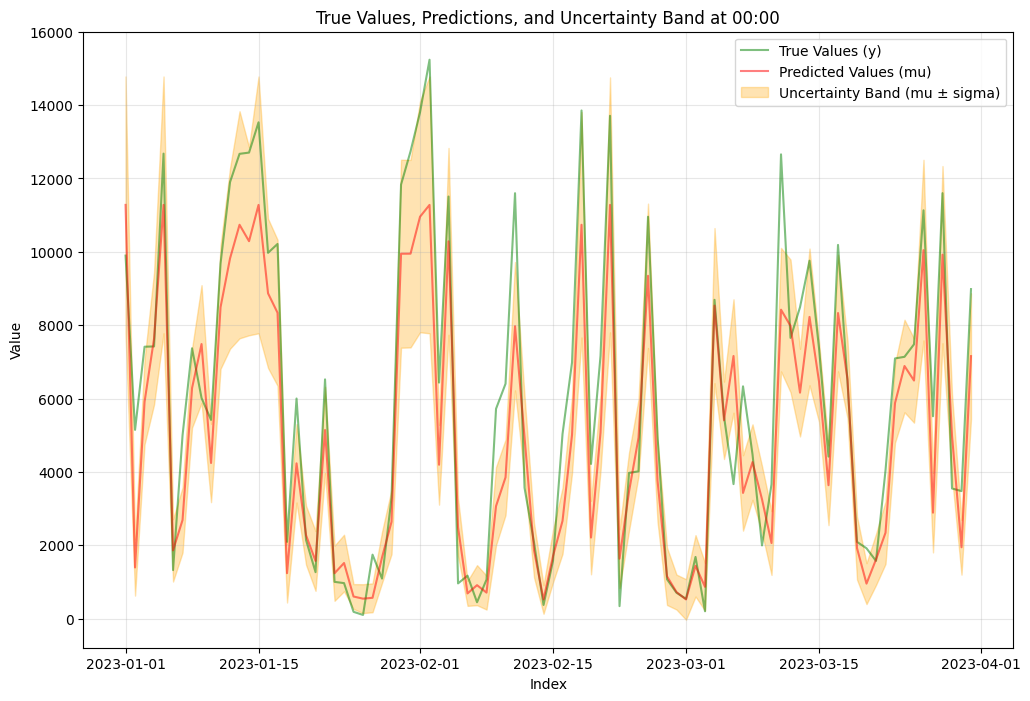

In [39]:
start = 0
end = 90
x = y_validation.index[start:end]
y = y_validation[start:end]
mu = y_val_pred[start:end]
sigma = [y.scale for y in y_val_dists][start:end]

# Plot
plt.figure(figsize=(12, 8))
plt.plot(x, y, label="True Values (y)", color="green", alpha=0.5)
plt.plot(x, mu, label="Predicted Values (mu)", color="red", alpha=0.5)
plt.fill_between(x, mu - sigma, mu + sigma, color="orange", alpha=0.3, label="Uncertainty Band (mu ± sigma)")

# Customize the plot
plt.xlabel("Index")
plt.ylabel("Value")
plt.title(f"True Values, Predictions, and Uncertainty Band at {time}")
plt.legend()
plt.grid(alpha=0.3)

In [42]:
loc = [y.loc for y in y_val_dists]
scale = [y.scale for y in y_val_dists]

In [43]:
_n = NormalCRPScore()
_n.loc = loc
_n.scale = scale
_n.total_score(y_validation)

761.8515615039604

In [3]:
df = load_entsoe()
df = df.rename(columns={"onshore": "power"})
df_daily = minute_to_daily(df)


df_daily_time = get_columns_by_time(df_daily, "00:00")
df_daily_time_delay = delay(df_daily_time, delays=1, columns="power") # delays "column"

# Step 1: Extract day of the year
df_daily_time_delay['day_of_year'] = df_daily_time_delay.index.dayofyear

# Step 2: Apply sine transformation for annual periodicity
df_daily_time_delay['sin_day'] = np.sin(2 * np.pi * df_daily_time_delay['day_of_year'] / 365)
df_daily_time_delay['cos_day'] = np.cos(2 * np.pi * df_daily_time_delay['day_of_year'] / 365)

df_daily_time_delay = df_daily_time_delay.drop(columns="day_of_year")


train, validation, test = to_train_validation_test_data(df_daily_time_delay, 
                                                        "2022-12-31", "2023-12-31")

X_train = train.drop(columns=['power'])
y_train = train['power']
X_validation = validation.drop(columns=['power'])
y_validation = validation['power']

Data loaded and transformed successfully. Shape of DataFrame: (78912, 22)
# of training observations: 2556 | 77.76%
# of validation observations: 365 | 11.10%
# of test observations: 366 | 11.13%


### Helper methods

### Hyperparameters

In [19]:
#seed = 42
n_estimators = 500
lr = 0.03
time = "09:00"

### Laden der entsoe daten (Aggregierte Powerdaten und Windgeschwindigkeitsdaten an den 10 größten Anlagenstandorten und am geographischen Zentrum gemessen an installierter Leistung)

In [20]:
df = load_entsoe()

df = df.drop(columns=["offshore"])
df = df.rename(columns={"onshore": "power"})
df_daily = minute_to_daily(df)
df_daily.head(5)

Data loaded and transformed successfully. Shape of DataFrame: (78912, 22)


power_00_00  power_00_15  power_00_30  power_00_45  power_01_00  \
date                                                                          
2016-01-01       1428.0       1379.0       1399.0       1448.0       1517.0   
2016-01-02        595.0        650.0        696.0        735.0        738.0   
2016-01-03       6600.0       6634.0       6645.0       6644.0       6646.0   
2016-01-04       5069.0       4983.0       4867.0       4754.0       4739.0   
2016-01-05       2081.0       2115.0       2108.0       2082.0       2083.0   

            power_01_15  power_01_30  power_01_45  power_02_00  power_02_15  \
date                                                                          
2016-01-01       1511.0       1539.0       1575.0       1628.0       1685.0   
2016-01-02        774.0        853.0        939.0        985.0       1030.0   
2016-01-03       6764.0       6858.0       6846.0       6846.0       6847.0   
2016-01-04       4644.0       4676.0       4629.0       4584.0       4394.0   
2016-01-05       2045.0       2050.0       2116.0       2089.0       2010.0   

            ...  ws_100m_loc_mean_21_30  ws_100m_loc_mean_21_45  \
date        ...                                                   
2016-01-01  ...                   3.875                  4.0325   
2016-01-02  ...                   9.155                  8.9575   
2016-01-03  ...                   9.085                  8.6775   
2016-01-04  ...                   6.785                  6.5925   
2016-01-05  ...                   5.470                  5.4500   

            ws_100m_loc_mean_22_00  ws_100m_loc_mean_22_15  \
date                                                         
2016-01-01                    4.19                  4.3175   
2016-01-02                    8.76                  8.7625   
2016-01-03                    8.27                  8.4350   
2016-01-04                    6.40                  6.4000   
2016-01-05                    5.43                  5.3975   

            ws_100m_loc_mean_22_30  ws_100m_loc_mean_22_45  \
date                                                         
2016-01-01                   4.445                  4.5725   
2016-01-02                   8.765                  8.7675   
2016-01-03                   8.600                  8.7650   
2016-01-04                   6.400                  6.4000   
2016-01-05                   5.365                  5.3325   

            ws_100m_loc_mean_23_00  ws_100m_loc_mean_23_15  \
date                                                         
2016-01-01                    4.70                  4.8225   
2016-01-02                    8.77                  8.7700   
2016-01-03                    8.93                  8.9275   
2016-01-04                    6.40                  6.3750   
2016-01-05                    5.30                  5.2725   

            ws_100m_loc_mean_23_30  ws_100m_loc_mean_23_45  
date                                                        
2016-01-01                   4.945                  5.0675  
2016-01-02                   8.770                  8.7700  
2016-01-03                   8.925                  8.9225  
2016-01-04                   6.350                  6.3250  
2016-01-05                   5.245                  5.2175  

[5 rows x 2208 columns]

### Filtern auf ein bestimmtes Zeitintervall

In [21]:
df_daily_time = get_columns_by_time(df_daily, time)
df_daily_time.head(5)

power  ws_10m_loc_1  ws_10m_loc_10  ws_10m_loc_2  ws_10m_loc_3  \
date                                                                          
2016-01-01  1080.0          2.53           3.14          2.92          2.52   
2016-01-02  4600.0          6.17           5.20          4.80          5.81   
2016-01-03  5673.0          6.50           5.45          5.46          6.65   
2016-01-04  3262.0          5.97           4.41          4.51          6.05   
2016-01-05  1863.0          4.20           4.06          4.04          4.82   

            ws_10m_loc_4  ws_10m_loc_5  ws_10m_loc_6  ws_10m_loc_7  \
date                                                                 
2016-01-01          2.42          2.19          2.25          2.56   
2016-01-02          5.83          5.32          5.36          5.33   
2016-01-03          5.82          6.17          6.10          5.85   
2016-01-04          4.28          5.62          5.51          5.10   
2016-01-05          4.26          4.71          4.60          4.51   

            ws_10m_loc_8  ...  ws_100m_loc_10  ws_100m_loc_2  ws_100m_loc_3  \
date                      ...                                                 
2016-01-01          2.46  ...            5.41           5.29           5.44   
2016-01-02          6.04  ...            7.90           7.22           9.05   
2016-01-03          6.26  ...            8.20           8.26           9.99   
2016-01-04          5.60  ...            7.08           7.20           9.34   
2016-01-05          3.91  ...            5.94           6.03           7.14   

            ws_100m_loc_4  ws_100m_loc_5  ws_100m_loc_6  ws_100m_loc_7  \
date                                                                     
2016-01-01           4.92           5.10           5.09           5.09   
2016-01-02           8.82           8.49           8.47           8.19   
2016-01-03           8.77           9.60           9.46           8.93   
2016-01-04           6.60           8.80           8.66           8.04   
2016-01-05           6.41           7.13           6.92           6.70   

            ws_100m_loc_8  ws_100m_loc_9  ws_100m_loc_mean  
date                                                        
2016-01-01           4.49           5.10              5.06  
2016-01-02           8.93           8.00              7.91  
2016-01-03           9.35           9.04              8.71  
2016-01-04           8.62           7.85              7.83  
2016-01-05           5.64           6.92              6.70  

[5 rows x 23 columns]

### Add power of today, add annual periodicity

In [14]:
df_daily_time_delay = delay(df_daily_time, delays=1, columns="power") # delays "column"


# Step 1: Extract day of the year
df_daily_time_delay['day_of_year'] = df_daily_time_delay.index.dayofyear

# Step 2: Apply sine transformation for annual periodicity
df_daily_time_delay['sin_day'] = np.sin(2 * np.pi * df_daily_time_delay['day_of_year'] / 365)
df_daily_time_delay['cos_day'] = np.cos(2 * np.pi * df_daily_time_delay['day_of_year'] / 365)

#df_daily_time_delay = df_daily_time_delay.drop(columns="day_of_year")

df_daily_time_delay.head(60)


power_t-1  offshore    power  ws_10m_loc_1  ws_10m_loc_10  \
date                                                                    
2016-01-02     1428.0     208.0    595.0          2.72           1.68   
2016-01-03      595.0     320.0   6600.0          6.02           5.40   
2016-01-04     6600.0     319.0   5069.0          5.39           4.54   
2016-01-05     5069.0     320.0   2081.0          4.30           3.40   
2016-01-06     2081.0     170.0   1177.0          3.16           2.82   
2016-01-07     1177.0     193.0    819.0          2.82           2.16   
2016-01-08      819.0     332.0   7139.0          6.54           4.75   
2016-01-09     7139.0     207.0   2151.0          4.10           2.73   
2016-01-10     2151.0     219.0   3285.0          3.84           2.10   
2016-01-11     3285.0      45.0   3263.0          3.00           2.96   
2016-01-12     3263.0      49.0   1884.0          2.38           1.50   
2016-01-13     1884.0      26.0   5519.0          3.55           4.41   
2016-01-14     5519.0       2.0   2543.0          3.00           2.48   
2016-01-15     2543.0      19.0   1716.0          2.27           2.10   
2016-01-16     1716.0       1.0    783.0          2.31           3.01   
2016-01-17      783.0     156.0   1194.0          1.30           1.26   
2016-01-18     1194.0      42.0    716.0          2.45           2.40   
2016-01-19      716.0     193.0   1295.0          3.48           1.99   
2016-01-20     1295.0     125.0   3233.0          3.64           4.14   
2016-01-21     3233.0      78.0   1529.0          3.42           2.48   
2016-01-22     1529.0      54.0    779.0          2.55           2.38   
2016-01-23      779.0     308.0   5854.0          4.59           3.91   
2016-01-24     5854.0      98.0   4145.0          4.00           3.71   
2016-01-25     4145.0     265.0   5121.0          4.31           3.82   
2016-01-26     5121.0     313.0   6077.0          4.33           3.96   
2016-01-27     6077.0     328.0   9316.0          6.62           5.71   
2016-01-28     9316.0     324.0   9904.0          6.94           6.16   
2016-01-29     9904.0     321.0   4710.0          4.43           3.00   
2016-01-30     4710.0     321.0  10339.0          7.52           6.50   
2016-01-31    10339.0     320.0   8253.0          5.51           5.28   
2016-02-01     8253.0     285.0   4007.0          4.98           3.48   
2016-02-02     4007.0     328.0  10734.0          8.62           8.17   
2016-02-03    10734.0     324.0  10519.0          9.95           6.64   
2016-02-04    10519.0     328.0   7867.0          5.90           5.35   
2016-02-05     7867.0     221.0   3935.0          3.83           3.86   
2016-02-06     3935.0     310.0   3608.0          4.36           3.42   
2016-02-07     3608.0     310.0   6460.0          4.14           4.06   
2016-02-08     6460.0     313.0   7129.0          4.78           5.17   
2016-02-09     7129.0     331.0  11835.0          8.08           7.28   
2016-02-10    11835.0     321.0  11660.0          8.63           8.99   
2016-02-11    11660.0      10.0   5569.0          3.54           4.66   
2016-02-12     5569.0      27.0   3985.0          4.27           3.64   
2016-02-13     3985.0       8.0    716.0          1.98           1.90   
2016-02-14      716.0     130.0   3761.0          4.03           3.61   
2016-02-15     3761.0     309.0   1349.0          2.55           2.34   
2016-02-16     1349.0      57.0   3346.0          4.22           4.34   
2016-02-17     3346.0      85.0   1481.0          1.80           2.75   
2016-02-18     1481.0      95.0   1900.0          2.59           3.41   
2016-02-19     1900.0       0.0    152.0          1.00           1.63   
2016-02-20      152.0     160.0   3015.0          2.64           3.13   
2016-02-21     3015.0     286.0   7984.0          4.97           5.45   
2016-02-22     7984.0     110.0  12542.0          9.76           9.31   
2016-02-23    12542.0     329.0   4591.0          5.82           3.62 

### Train, validation, test split, dropping power column in X_train, adding power column to y_train

In [23]:
train, validation, test = to_train_validation_test_data(df_daily_time_delay, 
                                                        "2022-12-31", "2023-12-31")

X_train = train.drop(columns=['power'])
y_train = train['power']
X_validation = validation.drop(columns=['power'])
y_validation = validation['power']

display(X_train.head(5))

display(y_train.head(5))

# of training observations: 2556 | 77.76%
# of validation observations: 365 | 11.10%
# of test observations: 366 | 11.13%


power_t-1  ws_10m_loc_1  ws_10m_loc_10  ws_10m_loc_2  \
date                                                               
2016-01-02     1080.0          6.17           5.20          4.80   
2016-01-03     4600.0          6.50           5.45          5.46   
2016-01-04     5673.0          5.97           4.41          4.51   
2016-01-05     3262.0          4.20           4.06          4.04   
2016-01-06     1863.0          3.79           2.88          2.92   

            ws_10m_loc_3  ws_10m_loc_4  ws_10m_loc_5  ws_10m_loc_6  \
date                                                                 
2016-01-02          5.81          5.83          5.32          5.36   
2016-01-03          6.65          5.82          6.17          6.10   
2016-01-04          6.05          4.28          5.62          5.51   
2016-01-05          4.82          4.26          4.71          4.60   
2016-01-06          4.03          3.31          3.74          3.71   

            ws_10m_loc_7  ws_10m_loc_8  ...  ws_100m_loc_3  ws_100m_loc_4  \
date                                    ...                                 
2016-01-02          5.33          6.04  ...           9.05           8.82   
2016-01-03          5.85          6.26  ...           9.99           8.77   
2016-01-04          5.10          5.60  ...           9.34           6.60   
2016-01-05          4.51          3.91  ...           7.14           6.41   
2016-01-06          3.38          3.59  ...           5.92           4.80   

            ws_100m_loc_5  ws_100m_loc_6  ws_100m_loc_7  ws_100m_loc_8  \
date                                                                     
2016-01-02           8.49           8.47           8.19           8.93   
2016-01-03           9.60           9.46           8.93           9.35   
2016-01-04           8.80           8.66           8.04           8.62   
2016-01-05           7.13           6.92           6.70           5.64   
2016-01-06           5.73           5.53           4.93           5.08   

            ws_100m_loc_9  ws_100m_loc_mean   sin_day   cos_day  
date                                                             
2016-01-02           8.00              7.91  0.034422  0.999407  
2016-01-03           9.04              8.71  0.051620  0.998667  
2016-01-04           7.85              7.83  0.068802  0.997630  
2016-01-05           6.92              6.70  0.085965  0.996298  
2016-01-06           5.08              4.97  0.103102  0.994671  

[5 rows x 25 columns]

date
2016-01-02    4600.0
2016-01-03    5673.0
2016-01-04    3262.0
2016-01-05    1863.0
2016-01-06    1074.0
Name: power, dtype: float64

### Train model using NGBoost

In [24]:
model = NGBRegressor(Dist=Normal, Score=CRPScore, n_estimators=n_estimators, learning_rate=lr, verbose_eval=True)

model.fit(X_train, y_train, X_val=X_validation, Y_val=y_validation)

# Predict on training data
y_train_pred = model.predict(X_train)
y_train_dists = model.pred_dist(X_train)


y_val_pred = model.predict(X_validation)
y_val_dists = model.pred_dist(X_validation)

# Calculate Mean Squared Error (MSE) for training and validation
train_mse = mean_squared_error(y_train, y_train_pred)
val_mse = mean_squared_error(y_validation, y_val_pred)

# Print the results
print(f"Training features: {[c for c in X_train.columns]} -> {y_train.name}")
print(f"Train MSE:\t {train_mse}")
print(f"Validation MSE:\t {val_mse}")

[iter 0] loss=1863.8893 val_loss=2198.2288 scale=512.0000 norm=451.8419
[iter 1] loss=1854.5974 val_loss=2187.5781 scale=512.0000 norm=450.4168
[iter 2] loss=1845.3773 val_loss=2176.9783 scale=512.0000 norm=448.9956
[iter 3] loss=1836.2285 val_loss=2166.5086 scale=512.0000 norm=447.5820
[iter 4] loss=1827.1501 val_loss=2156.0910 scale=512.0000 norm=446.1713
[iter 5] loss=1818.1417 val_loss=2145.7680 scale=512.0000 norm=444.7665
[iter 6] loss=1809.1827 val_loss=2135.5004 scale=512.0000 norm=443.3719
[iter 7] loss=1800.3105 val_loss=2125.3349 scale=512.0000 norm=441.9757
[iter 8] loss=1791.4868 val_loss=2115.2101 scale=512.0000 norm=440.5847
[iter 9] loss=1782.7488 val_loss=2105.2193 scale=512.0000 norm=439.2018
[iter 10] loss=1774.0588 val_loss=2095.3850 scale=512.0000 norm=437.8301
[iter 11] loss=1765.3486 val_loss=2085.4911 scale=512.0000 norm=436.4260
[iter 12] loss=1756.8052 val_loss=2075.8005 scale=512.0000 norm=435.0588
[iter 13] loss=1748.2227 val_loss=2066.2006 scale=512.0000 no

In [25]:
pd.DataFrame({'y': y_validation,'mu': y_val_pred, "sigma": [y.scale for y in y_val_dists]})

y            mu        sigma
date                                          
2023-01-01   7680.0  10377.876581  3946.543539
2023-01-02   9751.0   8565.976504  2392.114700
2023-01-03   3640.0   2740.656018   576.968916
2023-01-04  14492.0  10387.889335  3956.604124
2023-01-05  14153.0  10309.281254  3507.495491
...             ...           ...          ...
2023-12-27   1994.0   2346.965636   472.457999
2023-12-28  11945.0   9464.895881  3072.714531
2023-12-29  13606.0  10607.184206  3966.478799
2023-12-30  10308.0   8812.229658  2543.955131
2023-12-31   7639.0   6501.446895  1198.757527

[365 rows x 3 columns]

In [27]:
loc = [y.loc for y in y_val_dists]
scale = [y.scale for y in y_val_dists]

In [12]:
_n = NormalCRPScore()
_n.loc = loc
_n.scale = scale
_n.total_score(y_validation)

574.8347657209481

In [13]:
import numpy as np

In [14]:
loc = [y.loc for y in y_val_dists]
scale = [y.scale for y in y_val_dists]


In [15]:
_n = NormalCRPScore()
_n.loc = loc
_n.scale = scale
_n.total_score(y_validation)

574.8347657209481

### TBD

In [5]:
import properscoring as ps
np.mean(ps.crps_gaussian(y_validation, mu=loc, sig=scale))

1755.4278997069448

In [9]:
loss_df = pd.DataFrame(ps.crps_gaussian(y_validation, mu=loc, sig=scale), index=y_validation.index, columns=["crps_loss"])
loss_df.describe()

crps_loss
count   365.000000
mean   1755.427900
std    1555.987619
min     367.829779
25%     730.453842
50%    1208.774684
75%    2114.916867
max    8392.319063

In [17]:
import numpy as np
from sktime.performance_metrics.forecasting.probabilistic import CRPS
from scipy.stats import norm
from sktime.forecasting.probabilistic import Normal


ModuleNotFoundError: No module named 'sktime.forecasting.probabilistic'

(365,)

In [119]:
samples.shape

(1000, 365)

In [123]:
pd.DataFrame(y_validation.to_numpy()).T

0       1       2       3        4       5       6       7       8    \
0  9898.0  5146.0  7413.0  7421.0  12678.0  1323.0  4996.0  7371.0  6015.0   

      9    ...      355      356     357      358     359     360      361  \
0  5418.0  ...  14762.0  13977.0  5527.0  12419.0  7872.0  9581.0  11063.0   

       362      363     364  
0  11821.0  11653.0  4106.0  

[1 rows x 365 columns]

In [ ]:
forecast_distributions = norm(loc=loc, scale=scale)

samples = forecast_distributions.rvs(size=(1000, 365))

crps_metric = CRPS()
crps_metric.evaluate(pd.DataFrame(y_validation.to_numpy()).T, pd.DataFrame(samples).T)


AttributeError: 'DataFrame' object has no attribute 'energy'

In [89]:
forecast_distributions = norm(loc=loc, scale=scale)

# Instantiate CRPS metric
crps_metric = CRPS()
crps_metric.evaluate(y_validation, forecast_distributions)


AttributeError: 'rv_continuous_frozen' object has no attribute 'columns'

In [ ]:
forecast_distributions = norm(loc=loc, scale=scale)

# Instantiate CRPS metric
crps_metric = CRPS()

# Compute CRPS for each forecast distribution against true values
crps_values = []
for i, true_value in enumerate(y_validation):
    forecast = forecast_distributions[i]
    # CRPS is computed between the true value and the forecast distribution
    crps_value = crps_metric(true_value, forecast)
    crps_values.append(crps_value)

# Print CRPS scores
print("CRPS scores:", crps_values)


In [ ]:
from sktime.performance_metrics.forecasting.probabilistic import CRPS
CRPS().evaluate(y_validation, y_val_pred)

c:\Users\Manuel\Documents\Masterarbeit\.venv\Lib\site-packages\dask\dataframe\__init__.py:49: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [78]:
from sktime.performance_metrics.forecasting.probabilistic import PinballLoss

In [ ]:
pd.DataFrame({'y': y_validation,'mu': y_val_pred, "sigma": [y.scale for y in y_val_dists]})

y            mu        sigma
date                                          
2023-01-01   9898.0  11355.741723  3643.693987
2023-01-02   5146.0   3598.534031   563.249819
2023-01-03   7413.0   6535.339356   806.604846
2023-01-04   7421.0   5896.972327   927.667911
2023-01-05  12678.0  11355.741723  3643.693987
...             ...           ...          ...
2023-12-27   9581.0   8720.680208  1802.492838
2023-12-28  11063.0   9720.946554  2389.575028
2023-12-29  11821.0  10778.038468  3317.067313
2023-12-30  11653.0   9783.266578  2546.149052
2023-12-31   4106.0   3748.539545   564.908897

[365 rows x 3 columns]

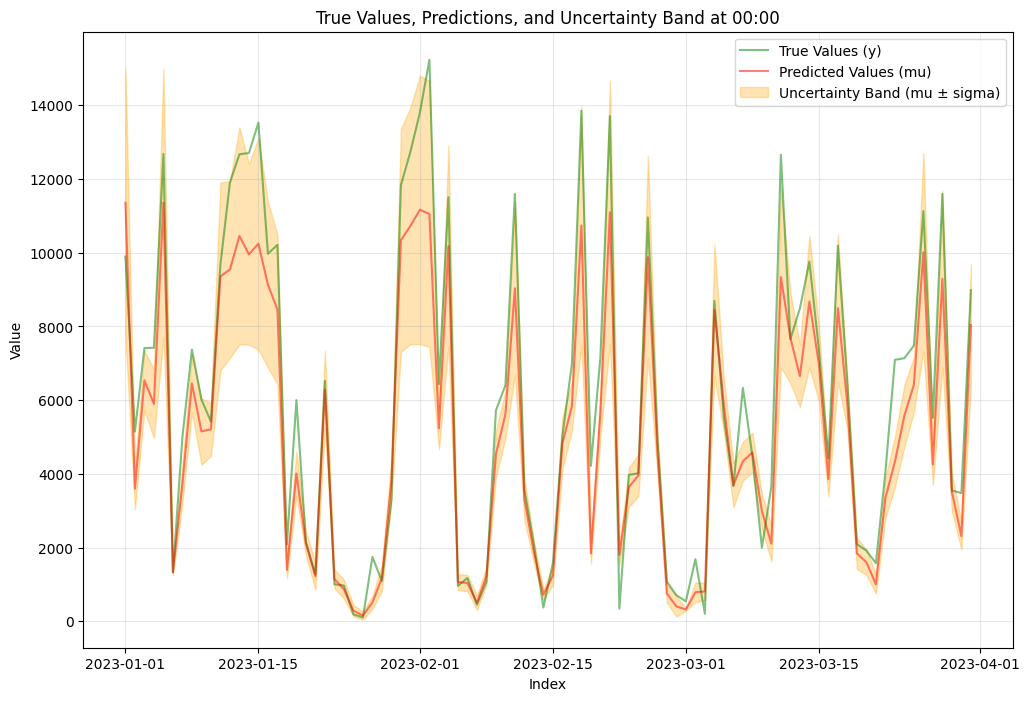

In [58]:
start = 0
end = 90
x = y_validation.index[start:end]
y = y_validation[start:end]
mu = y_val_pred[start:end]
sigma = [y.scale for y in y_val_dists][start:end]

# Plot
plt.figure(figsize=(12, 8))
plt.plot(x, y, label="True Values (y)", color="green", alpha=0.5)
plt.plot(x, mu, label="Predicted Values (mu)", color="red", alpha=0.5)
plt.fill_between(x, mu - sigma, mu + sigma, color="orange", alpha=0.3, label="Uncertainty Band (mu ± sigma)")

# Customize the plot
plt.xlabel("Index")
plt.ylabel("Value")
plt.title(f"True Values, Predictions, and Uncertainty Band at {time}")
plt.legend()
plt.grid(alpha=0.3)

In [ ]:
time = "00:00"
delays = 1
columns = "power"

df_daily_time = get_columns_by_time(df_daily, time) #filters for a specific time interval

display(df_daily_time)

df_daily_time_delay = delay(df_daily_time, delays=delays, columns=columns) # delays "column"

display(df_daily_time_delay)

# Move the second column (target variable) to the last position
target_col = df_daily_time_delay.columns[1]  # Get the name of the second column (target variable)
df_daily_time_delay = df_daily_time_delay[[col for col in df_daily_time_delay.columns if col != target_col] + [target_col]]

train, validation, test = to_train_validation_test_data(df_daily_time_delay, 
                                                        "2022-12-31", "2023-12-31")

model = NGBRegressor(Dist=Normal, Score=CRPScore)

#X_train, y_train = train.iloc[:, :-1], train.iloc[:, -1]
#X_val, y_val = validation.iloc[:, :-1], train.iloc[:, -1]





model.fit(X, y);
y_pred = model.predict(X)
y_dists = model.pred_dist(X)
train_mse = mean_squared_error(y, y_pred)
val_mse = mean_squared_error(validation.iloc[:, -1], model.predict(validation.iloc[:, :-1]))

print()
print(f"{[c for c in X.columns]} -> {y.name}")
print("Train MSE:\t", train_mse)
print("Validation MSE:\t", val_mse)

power  ws_10m_loc_1  ws_10m_loc_10  ws_10m_loc_2  ws_10m_loc_3  \
date                                                                          
2016-01-01  1428.0          1.90           2.48          2.41          1.97   
2016-01-02   595.0          2.72           1.68          2.64          3.14   
2016-01-03  6600.0          6.02           5.40          5.30          6.82   
2016-01-04  5069.0          5.39           4.54          4.85          6.18   
2016-01-05  2081.0          4.30           3.40          3.52          4.62   
...            ...           ...            ...           ...           ...   
2024-12-27   101.0          1.06           0.30          1.11          1.14   
2024-12-28    57.0          1.63           1.48          1.64          1.70   
2024-12-29  1527.0          2.53           2.55          2.64          2.40   
2024-12-30  6497.0          5.46           4.39          3.96          5.48   
2024-12-31  7838.0          6.39           4.76          3.65          6.09   

            ws_10m_loc_4  ws_10m_loc_5  ws_10m_loc_6  ws_10m_loc_7  \
date                                                                 
2016-01-01          2.48          1.80          1.80          1.86   
2016-01-02          3.11          3.21          3.11          2.63   
2016-01-03          5.49          6.48          6.41          5.93   
2016-01-04          5.32          5.66          5.32          5.22   
2016-01-05          3.77          4.31          4.30          4.10   
...                  ...           ...           ...           ...   
2024-12-27          1.47          1.25          0.67          0.54   
2024-12-28          0.55          1.55          1.38          0.75   
2024-12-29          2.28          2.15          1.92          1.85   
2024-12-30          5.02          5.33          5.28          4.91   
2024-12-31          6.05          5.76          5.95          5.09   

            ws_10m_loc_8  ...  ws_100m_loc_10  ws_100m_loc_2  ws_100m_loc_3  \
date                      ...                                                 
2016-01-01          2.20  ...            5.05           5.16           4.86   
2016-01-02          2.65  ...            2.42           3.86           5.39   
2016-01-03          5.66  ...            8.00           8.01          10.19   
2016-01-04          5.50  ...            8.98           9.37          10.38   
2016-01-05          4.14  ...            5.31           5.41           7.47   
...                  ...  ...             ...            ...            ...   
2024-12-27          1.27  ...            0.86           1.67           2.30   
2024-12-28          1.91  ...            2.95           3.13           2.11   
2024-12-29          2.59  ...            6.54           5.82           5.78   
2024-12-30          5.98  ...            7.69           7.10           9.35   
2024-12-31          7.31  ...            9.33           7.52          10.57   

            ws_100m_loc_4  ws_100m_loc_5  ws_100m_loc_6  ws_100m_loc_7  \
date                                                                     
2016-01-01           5.71           5.00           4.47           4.33   
2016-01-02           5.20           5.87           5.65           4.87   
2016-01-03           8.20           9.73           9.61           8.88   
2016-01-04           8.35           9.89          10.07           8.79   
2016-01-05           5.73           7.17           6.94           6.40   
...                   ...            ...            ...            ...   
2024-12-27           3.08           2.36           1.77           1.04   
2024-12-28           0.25           2.00           2.16           1.76   
2024-12-29           6.35           5.49           5.16           4.70   
2024-12-30           8.71           9.06           9.05           8.39   
2024-12-31          10.81          10.12          10.25           9.15   

            ws_100m_loc_8  ws_100m_loc_9  ws_100m_loc_mean  
date                  

power_t-1   power  ws_10m_loc_1  ws_10m_loc_10  ws_10m_loc_2  \
date                                                                       
2016-01-02     1428.0   595.0          2.72           1.68          2.64   
2016-01-03      595.0  6600.0          6.02           5.40          5.30   
2016-01-04     6600.0  5069.0          5.39           4.54          4.85   
2016-01-05     5069.0  2081.0          4.30           3.40          3.52   
2016-01-06     2081.0  1177.0          3.16           2.82          2.91   
...               ...     ...           ...            ...           ...   
2024-12-27      784.0   101.0          1.06           0.30          1.11   
2024-12-28      101.0    57.0          1.63           1.48          1.64   
2024-12-29       57.0  1527.0          2.53           2.55          2.64   
2024-12-30     1527.0  6497.0          5.46           4.39          3.96   
2024-12-31     6497.0  7838.0          6.39           4.76          3.65   

            ws_10m_loc_3  ws_10m_loc_4  ws_10m_loc_5  ws_10m_loc_6  \
date                                                                 
2016-01-02          3.14          3.11          3.21          3.11   
2016-01-03          6.82          5.49          6.48          6.41   
2016-01-04          6.18          5.32          5.66          5.32   
2016-01-05          4.62          3.77          4.31          4.30   
2016-01-06          3.88          3.22          4.00          3.67   
...                  ...           ...           ...           ...   
2024-12-27          1.14          1.47          1.25          0.67   
2024-12-28          1.70          0.55          1.55          1.38   
2024-12-29          2.40          2.28          2.15          1.92   
2024-12-30          5.48          5.02          5.33          5.28   
2024-12-31          6.09          6.05          5.76          5.95   

            ws_10m_loc_7  ...  ws_100m_loc_10  ws_100m_loc_2  ws_100m_loc_3  \
date                      ...                                                 
2016-01-02          2.63  ...            2.42           3.86           5.39   
2016-01-03          5.93  ...            8.00           8.01          10.19   
2016-01-04          5.22  ...            8.98           9.37          10.38   
2016-01-05          4.10  ...            5.31           5.41           7.47   
2016-01-06          3.32  ...            4.11           4.35           6.76   
...                  ...  ...             ...            ...            ...   
2024-12-27          0.54  ...            0.86           1.67           2.30   
2024-12-28          0.75  ...            2.95           3.13           2.11   
2024-12-29          1.85  ...            6.54           5.82           5.78   
2024-12-30          4.91  ...            7.69           7.10           9.35   
2024-12-31          5.09  ...            9.33           7.52          10.57   

            ws_100m_loc_4  ws_100m_loc_5  ws_100m_loc_6  ws_100m_loc_7  \
date                                                                     
2016-01-02           5.20           5.87           5.65           4.87   
2016-01-03           8.20           9.73           9.61           8.88   
2016-01-04           8.35           9.89          10.07           8.79   
2016-01-05           5.73           7.17           6.94           6.40   
2016-01-06           5.12           6.96           6.65           5.25   
...                   ...            ...            ...            ...   
2024-12-27           3.08           2.36           1.77           1.04   
2024-12-28           0.25           2.00           2.16           1.76   
2024-12-29           6.35           5.49           5.16           4.70   
2024-12-30           8.71           9.06           9.05           8.39   
2024-12-31          10.81          10.12          10.25           9.15   

            ws_100m_loc_8  ws_100m_loc_9  ws_100m_loc_mean  
date                                                        

# of training observations: 2556 | 77.76%
# of validation observations: 365 | 11.10%
# of test observations: 366 | 11.13%
[iter 0] loss=1735.1167 val_loss=0.0000 scale=512.0000 norm=449.1209
[iter 100] loss=1464.4111 val_loss=0.0000 scale=512.0000 norm=404.7802
[iter 200] loss=1251.6164 val_loss=0.0000 scale=512.0000 norm=366.5694
[iter 300] loss=1077.7116 val_loss=0.0000 scale=512.0000 norm=334.6166
[iter 400] loss=931.5457 val_loss=0.0000 scale=512.0000 norm=309.9416

['power_t-1', 'ws_10m_loc_1', 'ws_10m_loc_10', 'ws_10m_loc_2', 'ws_10m_loc_3', 'ws_10m_loc_4', 'ws_10m_loc_5', 'ws_10m_loc_6', 'ws_10m_loc_7', 'ws_10m_loc_8', 'ws_10m_loc_9', 'ws_10m_loc_mean', 'ws_100m_loc_1', 'ws_100m_loc_10', 'ws_100m_loc_2', 'ws_100m_loc_3', 'ws_100m_loc_4', 'ws_100m_loc_5', 'ws_100m_loc_6', 'ws_100m_loc_7', 'ws_100m_loc_8', 'ws_100m_loc_9', 'ws_100m_loc_mean'] -> power
Train MSE:	 2535800.446696702
Validation MSE:	 4445597.381172124


In [ ]:
pd.DataFrame({'y': y,'mu': y_pred, "sigma": [y.scale for y in y_dists]})

y           mu        sigma
date                                         
2016-01-02    595.0  1856.457628  1745.596623
2016-01-03   6600.0  5991.965861  2895.204422
2016-01-04   5069.0  6380.133049  3296.416554
2016-01-05   2081.0  3080.449931  1719.860772
2016-01-06   1177.0  2327.722807  1719.860772
...             ...          ...          ...
2022-12-27   6675.0  5639.306261  3007.657099
2022-12-28   7484.0  6176.152023  2479.380237
2022-12-29   9979.0  6981.874313  4135.109246
2022-12-30   8556.0  6794.585523  4055.837104
2022-12-31  10015.0  7085.501372  4228.121893

[2556 rows x 3 columns]

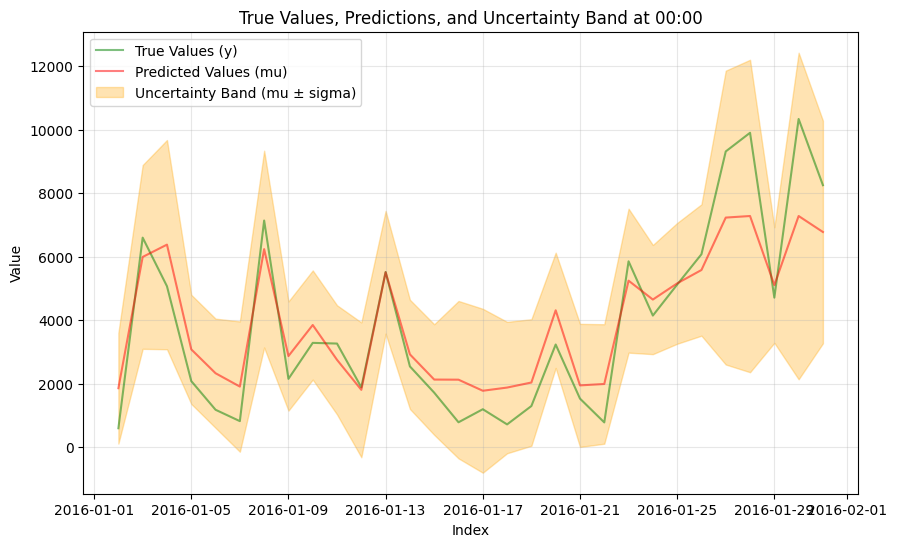

In [ ]:
start = 0
end = 30
x = y.index[start:end]
y = y[start:end]
mu = y_pred[start:end]
sigma = [y.scale for y in y_dists][start:end]
# Plot
plt.figure(figsize=(10, 6))
plt.plot(x, y, label="True Values (y)", color="green", alpha=0.5)
plt.plot(x, mu, label="Predicted Values (mu)", color="red", alpha=0.5)
plt.fill_between(x, mu - sigma, mu + sigma, color="orange", alpha=0.3, label="Uncertainty Band (mu ± sigma)")

# Customize the plot
plt.xlabel("Index")
plt.ylabel("Value")
plt.title(f"True Values, Predictions, and Uncertainty Band at {time}")
plt.legend()
plt.grid(alpha=0.3)

In [8]:
df_daily_time = get_columns_by_time(df_daily, "00:00")
df_daily_time

power  ws_10m_loc_1  ws_10m_loc_10  ws_10m_loc_2  ws_10m_loc_3  \
date                                                                          
2016-01-01  1428.0          1.90           2.48          2.41          1.97   
2016-01-02   595.0          2.72           1.68          2.64          3.14   
2016-01-03  6600.0          6.02           5.40          5.30          6.82   
2016-01-04  5069.0          5.39           4.54          4.85          6.18   
2016-01-05  2081.0          4.30           3.40          3.52          4.62   
...            ...           ...            ...           ...           ...   
2024-12-27   101.0          1.06           0.30          1.11          1.14   
2024-12-28    57.0          1.63           1.48          1.64          1.70   
2024-12-29  1527.0          2.53           2.55          2.64          2.40   
2024-12-30  6497.0          5.46           4.39          3.96          5.48   
2024-12-31  7838.0          6.39           4.76          3.65          6.09   

            ws_10m_loc_4  ws_10m_loc_5  ws_10m_loc_6  ws_10m_loc_7  \
date                                                                 
2016-01-01          2.48          1.80          1.80          1.86   
2016-01-02          3.11          3.21          3.11          2.63   
2016-01-03          5.49          6.48          6.41          5.93   
2016-01-04          5.32          5.66          5.32          5.22   
2016-01-05          3.77          4.31          4.30          4.10   
...                  ...           ...           ...           ...   
2024-12-27          1.47          1.25          0.67          0.54   
2024-12-28          0.55          1.55          1.38          0.75   
2024-12-29          2.28          2.15          1.92          1.85   
2024-12-30          5.02          5.33          5.28          4.91   
2024-12-31          6.05          5.76          5.95          5.09   

            ws_10m_loc_8  ...  ws_100m_loc_10  ws_100m_loc_2  ws_100m_loc_3  \
date                      ...                                                 
2016-01-01          2.20  ...            5.05           5.16           4.86   
2016-01-02          2.65  ...            2.42           3.86           5.39   
2016-01-03          5.66  ...            8.00           8.01          10.19   
2016-01-04          5.50  ...            8.98           9.37          10.38   
2016-01-05          4.14  ...            5.31           5.41           7.47   
...                  ...  ...             ...            ...            ...   
2024-12-27          1.27  ...            0.86           1.67           2.30   
2024-12-28          1.91  ...            2.95           3.13           2.11   
2024-12-29          2.59  ...            6.54           5.82           5.78   
2024-12-30          5.98  ...            7.69           7.10           9.35   
2024-12-31          7.31  ...            9.33           7.52          10.57   

            ws_100m_loc_4  ws_100m_loc_5  ws_100m_loc_6  ws_100m_loc_7  \
date                                                                     
2016-01-01           5.71           5.00           4.47           4.33   
2016-01-02           5.20           5.87           5.65           4.87   
2016-01-03           8.20           9.73           9.61           8.88   
2016-01-04           8.35           9.89          10.07           8.79   
2016-01-05           5.73           7.17           6.94           6.40   
...                   ...            ...            ...            ...   
2024-12-27           3.08           2.36           1.77           1.04   
2024-12-28           0.25           2.00           2.16           1.76   
2024-12-29           6.35           5.49           5.16           4.70   
2024-12-30           8.71           9.06           9.05           8.39   
2024-12-31          10.81          10.12          10.25           9.15   

            ws_100m_loc_8  ws_100m_loc_9  ws_100m_loc_mean  
date                  

In [9]:
df_daily_time_delay = delay(df_daily_time, 1, "power")
df_daily_time_delay

power_t-1   power  ws_10m_loc_1  ws_10m_loc_10  ws_10m_loc_2  \
date                                                                       
2016-01-02     1428.0   595.0          2.72           1.68          2.64   
2016-01-03      595.0  6600.0          6.02           5.40          5.30   
2016-01-04     6600.0  5069.0          5.39           4.54          4.85   
2016-01-05     5069.0  2081.0          4.30           3.40          3.52   
2016-01-06     2081.0  1177.0          3.16           2.82          2.91   
...               ...     ...           ...            ...           ...   
2024-12-27      784.0   101.0          1.06           0.30          1.11   
2024-12-28      101.0    57.0          1.63           1.48          1.64   
2024-12-29       57.0  1527.0          2.53           2.55          2.64   
2024-12-30     1527.0  6497.0          5.46           4.39          3.96   
2024-12-31     6497.0  7838.0          6.39           4.76          3.65   

            ws_10m_loc_3  ws_10m_loc_4  ws_10m_loc_5  ws_10m_loc_6  \
date                                                                 
2016-01-02          3.14          3.11          3.21          3.11   
2016-01-03          6.82          5.49          6.48          6.41   
2016-01-04          6.18          5.32          5.66          5.32   
2016-01-05          4.62          3.77          4.31          4.30   
2016-01-06          3.88          3.22          4.00          3.67   
...                  ...           ...           ...           ...   
2024-12-27          1.14          1.47          1.25          0.67   
2024-12-28          1.70          0.55          1.55          1.38   
2024-12-29          2.40          2.28          2.15          1.92   
2024-12-30          5.48          5.02          5.33          5.28   
2024-12-31          6.09          6.05          5.76          5.95   

            ws_10m_loc_7  ...  ws_100m_loc_10  ws_100m_loc_2  ws_100m_loc_3  \
date                      ...                                                 
2016-01-02          2.63  ...            2.42           3.86           5.39   
2016-01-03          5.93  ...            8.00           8.01          10.19   
2016-01-04          5.22  ...            8.98           9.37          10.38   
2016-01-05          4.10  ...            5.31           5.41           7.47   
2016-01-06          3.32  ...            4.11           4.35           6.76   
...                  ...  ...             ...            ...            ...   
2024-12-27          0.54  ...            0.86           1.67           2.30   
2024-12-28          0.75  ...            2.95           3.13           2.11   
2024-12-29          1.85  ...            6.54           5.82           5.78   
2024-12-30          4.91  ...            7.69           7.10           9.35   
2024-12-31          5.09  ...            9.33           7.52          10.57   

            ws_100m_loc_4  ws_100m_loc_5  ws_100m_loc_6  ws_100m_loc_7  \
date                                                                     
2016-01-02           5.20           5.87           5.65           4.87   
2016-01-03           8.20           9.73           9.61           8.88   
2016-01-04           8.35           9.89          10.07           8.79   
2016-01-05           5.73           7.17           6.94           6.40   
2016-01-06           5.12           6.96           6.65           5.25   
...                   ...            ...            ...            ...   
2024-12-27           3.08           2.36           1.77           1.04   
2024-12-28           0.25           2.00           2.16           1.76   
2024-12-29           6.35           5.49           5.16           4.70   
2024-12-30           8.71           9.06           9.05           8.39   
2024-12-31          10.81          10.12          10.25           9.15   

            ws_100m_loc_8  ws_100m_loc_9  ws_100m_loc_mean  
date                                                        

In [ ]:
train, validation, test = to_train_validation_test_data(df_daily_time_delay, "2022-12-31", "2023-12-31")

In [7]:
load_wind_park_data().index.max()

Data loaded and transformed successfully. Shape of DataFrame: (78192, 22)


Timestamp('2024-12-01 23:00:00')

In [ ]:
# Example usage
wind_park_data = load_wind_park_data()
display(wind_park_data.head(3))
electricity_data = load_entsoe()
display(electricity_data.head(3))

merged_df = process_and_merge_dataframes(wind_park_data, electricity_data)
merged_df = merged_df.dropna()
display(merged_df.head(3))

time = "09:30"
df_time = get_columns_by_time(merged_df, time)
display(df_time.head(3))
df_time.columns = [c[:-6] for c in df_time.columns]
display(df_time.head(3))

train, validation, test = to_train_validation_test_data(df_time, "2023-01-01", "2024-01-01")

def transform(df):
    df = df.copy()
    df["onshore_m1"] = df["onshore"].shift(1)
    df = df.dropna()
    y = df["onshore"]
    X = df.drop(columns=["onshore"])
    return X, y

X_train, y_train = transform(train)
X_val, y_val = transform(validation)


from ngboost.scores import LogScore, CRPScore
from ngboost.distns import Normal

model = NGBRegressor(Dist=Normal, Score=CRPScore)

model.fit(X_train, y_train)

y_preds = model.predict(X_train)
y_dists = model.pred_dist(X_train)

# train Mean Squared Error
mse = mean_squared_error(y_preds, y_train)
print('train MSE', mse)

# train Negative Log Likelihood
nll = -y_dists.logpdf(y_train).mean()
print('train NLL', nll)

pd.DataFrame({"y": y_train, "mu": y_preds, "sigma": [y.scale for y in y_dists]})


start = 0
end = 30
x = y_train.index[start:end]
y = y_train[start:end]
mu = y_preds[start:end]
sigma = [y.scale for y in y_dists][start:end]
# Plot
plt.figure(figsize=(10, 6))
plt.plot(x, y, label="True Values (y)", color="green", alpha=0.5)
plt.plot(x, mu, label="Predicted Values (mu)", color="red", alpha=0.5)
plt.fill_between(x, mu - sigma, mu + sigma, color="orange", alpha=0.3, label="Uncertainty Band (mu ± sigma)")

# Customize the plot
plt.xlabel("Index")
plt.ylabel("Value")
plt.title(f"True Values, Predictions, and Uncertainty Band at {time}")
plt.legend()
plt.grid(alpha=0.3)


y_preds = model.predict(X_val)
y_dists = model.pred_dist(X_val)

# val Mean Squared Error
val_mse = mean_squared_error(y_preds, y_val)
print('Val MSE', val_mse)

# val Negative Log Likelihood
val_nll = -y_dists.logpdf(y_val).mean()
print('Val NLL', val_nll)


start = 0
end = 30
x = y_val.index[start:end]
y = y_val[start:end]
mu = y_preds[start:end]
sigma = [y.scale for y in y_dists][start:end]
# Plot
plt.figure(figsize=(10, 6))
plt.plot(x, y, label="True Values (y)", color="green", alpha=0.5)
plt.plot(x, mu, label="Predicted Values (mu)", color="red", alpha=0.5)
plt.fill_between(x, mu - sigma, mu + sigma, color="orange", alpha=0.3, label="Uncertainty Band (mu ± sigma)")

# Customize the plot
plt.xlabel("Index")
plt.ylabel("Value")
plt.title(f"True Values, Predictions, and Uncertainty Band at {time}")
plt.legend()
plt.grid(alpha=0.3)


In [2]:
# Example usage
wind_park_data = load_wind_park_data()
display(wind_park_data.head(3))
electricity_data = load_entsoe()
display(electricity_data.head(3))

merged_df = process_and_merge_dataframes(wind_park_data, electricity_data)
merged_df = merged_df.dropna()
display(merged_df.head(3))


Data loaded and transformed successfully. Shape of DataFrame: (78192, 22)


wind_speed_10m_51.84534_13.656307  \
time                                                     
2016-01-01 00:00:00                               2.48   
2016-01-01 01:00:00                               2.77   
2016-01-01 02:00:00                               2.75   

                     wind_speed_10m_51.98594_13.045872  \
time                                                     
2016-01-01 00:00:00                               2.41   
2016-01-01 01:00:00                               2.55   
2016-01-01 02:00:00                               2.62   

                     wind_speed_10m_52.26713_11.312384  wind_speed_10m_mean  \
time                                                                          
2016-01-01 00:00:00                               2.48                 1.94   
2016-01-01 01:00:00                               2.62                 2.00   
2016-01-01 02:00:00                               2.64                 2.12   

                     wind_speed_10m_52.618626_12.761193  \
time                                                      
2016-01-01 00:00:00                                1.86   
2016-01-01 01:00:00                                2.00   
2016-01-01 02:00:00                                2.12   

                     wind_speed_10m_52.829525_11.6510315  \
time                                                       
2016-01-01 00:00:00                                 1.84   
2016-01-01 01:00:00                                 2.05   
2016-01-01 02:00:00                                 2.06   

                     wind_speed_10m_52.97012_12.372882  \
time                                                     
2016-01-01 00:00:00                               1.80   
2016-01-01 01:00:00                               1.78   
2016-01-01 02:00:00                               1.91   

                     wind_speed_10m_53.110718_12.079395  \
time                                                      
2016-01-01 00:00:00                                1.97   
2016-01-01 01:00:00                                1.94   
2016-01-01 02:00:00                                2.06   

                     wind_speed_10m_53.18102_11.761364  \
time                                                     
2016-01-01 00:00:00                               1.80   
2016-01-01 01:00:00                               1.72   
2016-01-01 02:00:00                               1.84   

                     wind_speed_10m_53.321613_13.859315  ...  \
time                                                     ...   
2016-01-01 00:00:00                                1.90  ...   
2016-01-01 01:00:00                                2.02  ...   
2016-01-01 02:00:00                                1.90  ...   

                     wind_speed_100m_51.98594_13.045872  \
time                                                      
2016-01-01 00:00:00                                5.16   
2016-01-01 01:00:00                                5.50   
2016-01-01 02:00:00                                5.49   

                     wind_speed_100m_52.26713_11.312384  wind_speed_100m_mean  \
time                                                                            
2016-01-01 00:00:00                                5.71                  4.52   
2016-01-01 01:00:00                                5.97                  4.69   
2016-01-01 02:00:00                                5.87                  4.97   

                     wind_speed_100m_52.618626_12.761193  \
time                                                       
2016-01-01 00:00:00                                 4.33   
2016-01-01 01:00:00                                 4.47   
2016-01-01 02:00:00                                 4.80   

                     wind_speed_100m_52.829525_11.6510315  \
time                                                        
2016-01-01 00:00:00                                  5.02   
2016-01-01 01:00:00                                  5.24   


offshore  onshore
time                                  
2016-01-01 00:00:00      21.0   1428.0
2016-01-01 00:15:00      27.0   1379.0
2016-01-01 00:30:00      24.0   1399.0

wind_speed_10m_mean_00_00  wind_speed_10m_mean_00_15  \
date                                                               
2016-01-01                       1.94                     1.9550   
2016-01-02                       2.83                     2.8250   
2016-01-03                       5.83                     5.8325   

            wind_speed_10m_mean_00_30  wind_speed_10m_mean_00_45  \
date                                                               
2016-01-01                      1.970                     1.9850   
2016-01-02                      2.820                     2.8150   
2016-01-03                      5.835                     5.8375   

            wind_speed_10m_mean_01_00  wind_speed_10m_mean_01_15  \
date                                                               
2016-01-01                       2.00                      2.030   
2016-01-02                       2.81                      2.835   
2016-01-03                       5.84                      5.840   

            wind_speed_10m_mean_01_30  wind_speed_10m_mean_01_45  \
date                                                               
2016-01-01                       2.06                      2.090   
2016-01-02                       2.86                      2.885   
2016-01-03                       5.84                      5.840   

            wind_speed_10m_mean_02_00  wind_speed_10m_mean_02_15  ...  \
date                                                              ...   
2016-01-01                       2.12                     2.1225  ...   
2016-01-02                       2.91                     2.9975  ...   
2016-01-03                       5.84                     5.8425  ...   

            onshore_21_30  onshore_21_45  onshore_22_00  onshore_22_15  \
date                                                                     
2016-01-01          316.0          350.0          359.0          385.0   
2016-01-02         6813.0         6809.0         6785.0         6760.0   
2016-01-03         5377.0         5335.0         5253.0         5296.0   

            onshore_22_30  onshore_22_45  onshore_23_00  onshore_23_15  \
date                                                                     
2016-01-01          425.0          432.0          467.0          503.0   
2016-01-02         6790.0         6771.0         6700.0         6682.0   
2016-01-03         5265.0         5255.0         5255.0         5239.0   

            onshore_23_30  onshore_23_45  
date                                      
2016-01-01          509.0          528.0  
2016-01-02         6672.0         6721.0  
2016-01-03         5234.0         5220.0  

[3 rows x 288 columns]

In [3]:
time = "09:30"
df_time = get_columns_by_time(merged_df, time)
display(df_time.head(3))
df_time.columns = [c[:-6] for c in df_time.columns]
display(df_time.head(3))

wind_speed_10m_mean_09_30  wind_speed_100m_mean_09_30  \
date                                                                
2016-01-01                      2.110                       4.205   
2016-01-02                      5.175                       7.930   
2016-01-03                      5.515                       8.310   

            onshore_09_30  
date                       
2016-01-01          951.0  
2016-01-02         4758.0  
2016-01-03         5702.0

wind_speed_10m_mean  wind_speed_100m_mean  onshore
date                                                          
2016-01-01                2.110                 4.205    951.0
2016-01-02                5.175                 7.930   4758.0
2016-01-03                5.515                 8.310   5702.0

In [4]:
df_time.index.min(), df_time.index.max(), df_time.count()

(Timestamp('2016-01-01 00:00:00'),
 Timestamp('2024-10-10 00:00:00'),
 wind_speed_10m_mean     3206
 wind_speed_100m_mean    3206
 onshore                 3206
 dtype: int64)

In [5]:
train, validation, test = to_train_validation_test_data(df_time, "2023-01-01", "2024-01-01")

# of training observations: 2557 | 79.76%
# of validation observations: 365 | 11.38%
# of test observations: 284 | 8.86%


In [6]:
print("train:", train.index.min(), train.index.max())
print("val:", validation.index.min(), validation.index.max())
print("test:", test.index.min(), test.index.max())

train: 2016-01-01 00:00:00 2022-12-31 00:00:00
val: 2023-01-01 00:00:00 2023-12-31 00:00:00
test: 2024-01-01 00:00:00 2024-10-10 00:00:00


In [7]:
def transform(df):
    df = df.copy()
    df["onshore_m1"] = df["onshore"].shift(1)
    df = df.dropna()
    y = df["onshore"]
    X = df.drop(columns=["onshore"])
    return X, y


In [8]:
X_train, y_train = transform(train)
X_val, y_val = transform(validation)

In [9]:
from ngboost.scores import LogScore, CRPScore
from ngboost.distns import Normal

In [10]:
model = NGBRegressor(Dist=Normal, Score=CRPScore)

In [11]:
model.fit(X_train, y_train)

[iter 0] loss=1870.1748 val_loss=0.0000 scale=512.0000 norm=452.6658
[iter 100] loss=1592.7554 val_loss=0.0000 scale=512.0000 norm=408.7787
[iter 200] loss=1377.0597 val_loss=0.0000 scale=512.0000 norm=371.7943
[iter 300] loss=1204.5239 val_loss=0.0000 scale=512.0000 norm=342.1967
[iter 400] loss=1062.7566 val_loss=0.0000 scale=512.0000 norm=320.2085


NGBRegressor(Score=<class 'ngboost.scores.CRPScore'>,
             random_state=RandomState(MT19937) at 0x1DBA1B07C40)

In [12]:
y_preds = model.predict(X_train)
y_dists = model.pred_dist(X_train)

# train Mean Squared Error
mse = mean_squared_error(y_preds, y_train)
print('train MSE', mse)

# train Negative Log Likelihood
nll = -y_dists.logpdf(y_train).mean()
print('train NLL', nll)

train MSE 3437941.611170776
train NLL 8.867858751943569


In [13]:
X_train

wind_speed_10m_mean  wind_speed_100m_mean  onshore_m1
date                                                             
2016-01-02                5.175                 7.930       951.0
2016-01-03                5.515                 8.310      4758.0
2016-01-04                4.930                 7.640      5702.0
2016-01-05                4.450                 6.600      3013.0
2016-01-06                3.515                 5.110      1721.0
...                         ...                   ...         ...
2022-12-27                6.345                10.280      7328.0
2022-12-28                6.250                10.715     11375.0
2022-12-29                6.585                11.150     10855.0
2022-12-30                4.375                 7.465     10845.0
2022-12-31                7.375                12.400      5340.0

[2556 rows x 3 columns]

In [14]:
y_train

date
2016-01-02     4758.0
2016-01-03     5702.0
2016-01-04     3013.0
2016-01-05     1721.0
2016-01-06      938.0
               ...   
2022-12-27    11375.0
2022-12-28    10855.0
2022-12-29    10845.0
2022-12-30     5340.0
2022-12-31     9537.0
Name: onshore, Length: 2556, dtype: float64

In [15]:
pd.DataFrame({"y": y_train, "mu": y_preds, "sigma": [y.scale for y in y_dists]})

y           mu        sigma
date                                         
2016-01-02   4758.0  5105.597505  2905.974637
2016-01-03   5702.0  5315.674441  2827.082496
2016-01-04   3013.0  4875.120328  2716.734554
2016-01-05   1721.0  3556.078437  2016.026979
2016-01-06    938.0  2272.014272  1984.849518
...             ...          ...          ...
2022-12-27  11375.0  6670.793475  4719.812541
2022-12-28  10855.0  6888.354059  4884.320687
2022-12-29  10845.0  6888.354059  5363.197565
2022-12-30   5340.0  4570.980284  2160.037585
2022-12-31   9537.0  6888.354059  5831.492904

[2556 rows x 3 columns]

results for train

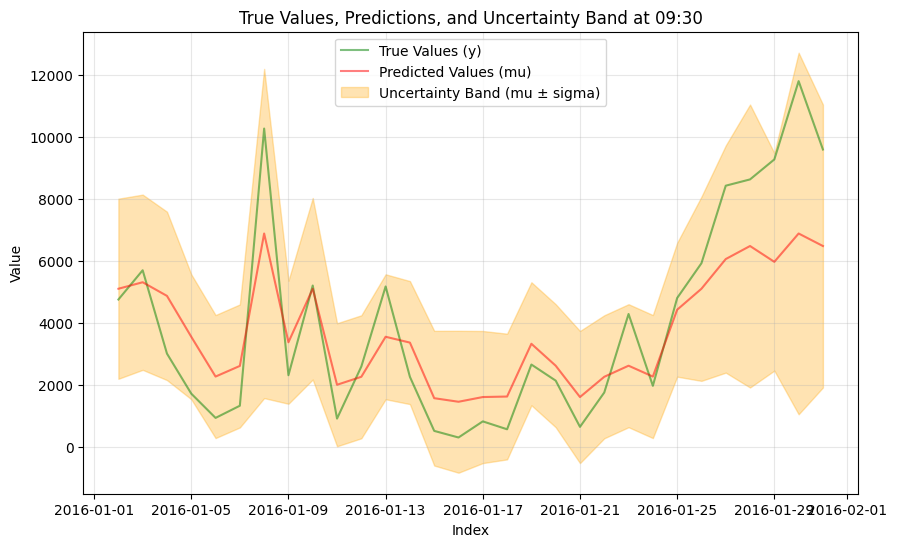

In [16]:
start = 0
end = 30
x = y_train.index[start:end]
y = y_train[start:end]
mu = y_preds[start:end]
sigma = [y.scale for y in y_dists][start:end]
# Plot
plt.figure(figsize=(10, 6))
plt.plot(x, y, label="True Values (y)", color="green", alpha=0.5)
plt.plot(x, mu, label="Predicted Values (mu)", color="red", alpha=0.5)
plt.fill_between(x, mu - sigma, mu + sigma, color="orange", alpha=0.3, label="Uncertainty Band (mu ± sigma)")

# Customize the plot
plt.xlabel("Index")
plt.ylabel("Value")
plt.title(f"True Values, Predictions, and Uncertainty Band at {time}")
plt.legend()
plt.grid(alpha=0.3)

Results for val

In [17]:
y_preds = model.predict(X_val)
y_dists = model.pred_dist(X_val)

# val Mean Squared Error
val_mse = mean_squared_error(y_preds, y_val)
print('Val MSE', val_mse)

# val Negative Log Likelihood
val_nll = -y_dists.logpdf(y_val).mean()
print('Val NLL', val_nll)

Val MSE 5880431.0927422475
Val NLL 8.986781121261618


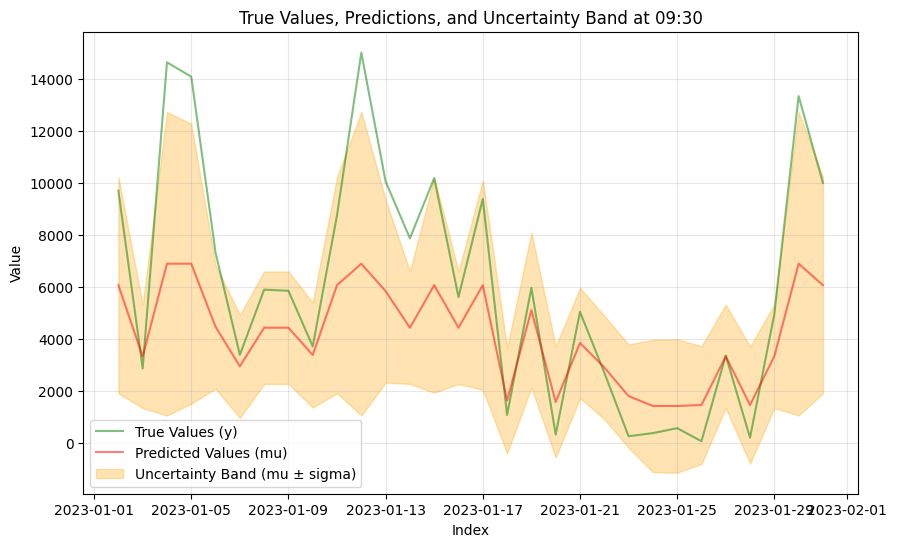

In [18]:
start = 0
end = 30
x = y_val.index[start:end]
y = y_val[start:end]
mu = y_preds[start:end]
sigma = [y.scale for y in y_dists][start:end]
# Plot
plt.figure(figsize=(10, 6))
plt.plot(x, y, label="True Values (y)", color="green", alpha=0.5)
plt.plot(x, mu, label="Predicted Values (mu)", color="red", alpha=0.5)
plt.fill_between(x, mu - sigma, mu + sigma, color="orange", alpha=0.3, label="Uncertainty Band (mu ± sigma)")

# Customize the plot
plt.xlabel("Index")
plt.ylabel("Value")
plt.title(f"True Values, Predictions, and Uncertainty Band at {time}")
plt.legend()
plt.grid(alpha=0.3)